# Telecom Churn Case Study

## Objective of the case - to analyse customer-level data of a leading telecom firm, build predictive models to identify customers at high risk of churn and identify the main indicators of churn.

### Steps

  - Clean the data and do an EDA using CRISP DM 
  - Calculate and Predict churn only on high-value customers, >70th percentile
  - Create new features
  - Churn in our case has two defitions - 
     - Usage-based churn: Customers who have not done any usage, either incoming or outgoing - in terms of calls, internet etc. over a period of time.
     - Revenue-based churn: Customers who have not utilised any revenue-generating facilities such as mobile internet, outgoing calls, SMS etc. over a given period of time. One could also use aggregate metrics such as ‘customers who have generated less than INR 4 per month in total/average/median revenue’.
  - Do a PCA to reduce the number of dimensions 
  - Develop a model which can be used in future by the company
     
-  Churn Phases/definitions for reference

     - The ‘good’ phase: In this phase, the customer is happy with the service and behaves as usual.

     - The ‘action’ phase: The customer experience starts to sore in this phase, for e.g. he/she gets a compelling offer from a  competitor, faces unjust charges, becomes unhappy with service quality etc. In this phase, the customer usually shows different behaviour than the ‘good’ months. Also, it is crucial to identify high-churn-risk customers in this phase, since some corrective actions can be taken at this point (such as matching the competitor’s offer/improving the service quality etc.)

   - The ‘churn’ phase: In this phase, the customer is said to have churned. You define churn based on this phase. Also, it is important to note that at the time of prediction (i.e. the action months), this data is not available to you for prediction. Thus, after tagging churn as 1/0 based on this phase, you discard all data corresponding to this phase.

In [1]:
# import required libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import skew
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import QuantileTransformer
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, make_scorer, \
confusion_matrix

import warnings
warnings.filterwarnings('ignore')
from time import time
pd.set_option('display.max_rows', 999)

## Contents
***
I. <a href='#I'>**Data Understanding**</a>

II. <a href='#II'>**Data Preparation and EDA**</a>

III. <a href='#III'>**Spliting and PCA**</a>

IV. <a href='#IV'>**Model Building**</a>

V. <a href='#V'>**Model Performace**</a>

VI. <a href='#VI'>**Important Variables**</a>
*****

## I. Data Understanding<a id='I'></a>

In [2]:
# imoport data into a dataframe
data = pd.read_csv('telecom_churn_data.csv')
data.head()

mobile_number  circle_id  loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou  \
0     7000842753        109             0.0             0.0             0.0   
1     7001865778        109             0.0             0.0             0.0   
2     7001625959        109             0.0             0.0             0.0   
3     7001204172        109             0.0             0.0             0.0   
4     7000142493        109             0.0             0.0             0.0   

  last_date_of_month_6 last_date_of_month_7 last_date_of_month_8  \
0            6/30/2014            7/31/2014            8/31/2014   
1            6/30/2014            7/31/2014            8/31/2014   
2            6/30/2014            7/31/2014            8/31/2014   
3            6/30/2014            7/31/2014            8/31/2014   
4            6/30/2014            7/31/2014            8/31/2014   

  last_date_of_month_9   arpu_6  ...  sachet_3g_9  fb_user_6  fb_user_7  \
0            9/30/2014  197.385  ...            0        1.0        1.0   
1            9/30/2014   34.047  ...            0        NaN        1.0   
2            9/30/2014  167.690  ...            0        NaN        NaN   
3            9/30/2014  221.338  ...            0        NaN        NaN   
4            9/30/2014  261.636  ...            0        0.0        NaN   

   fb_user_8  fb_user_9   aon  aug_vbc_3g  jul_vbc_3g  jun_vbc_3g  sep_vbc_3g  
0        1.0        NaN   968        30.4         0.0      101.20        3.58  
1        1.0        NaN  1006         0.0         0.0        0.00        0.00  
2        NaN        1.0  1103         0.0         0.0        4.17        0.00  
3        NaN        NaN  2491         0.0         0.0        0.00        0.00  
4        NaN        NaN  1526         0.0         0.0        0.00        0.00  

[5 rows x 226 columns]

In [3]:
data.shape

(99999, 226)

Data consists of almost 1 lakh observations including both high value and low value customers.

In [4]:
data.info(verbose=True,null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Data columns (total 226 columns):
mobile_number               99999 non-null int64
circle_id                   99999 non-null int64
loc_og_t2o_mou              98981 non-null float64
std_og_t2o_mou              98981 non-null float64
loc_ic_t2o_mou              98981 non-null float64
last_date_of_month_6        99999 non-null object
last_date_of_month_7        99398 non-null object
last_date_of_month_8        98899 non-null object
last_date_of_month_9        98340 non-null object
arpu_6                      99999 non-null float64
arpu_7                      99999 non-null float64
arpu_8                      99999 non-null float64
arpu_9                      99999 non-null float64
onnet_mou_6                 96062 non-null float64
onnet_mou_7                 96140 non-null float64
onnet_mou_8                 94621 non-null float64
onnet_mou_9                 92254 non-null float64
offnet_mou_6                960

There are 2 types of variables present in the data i.e. numerical and date. Also, there are missing values in various variables.

***Filtering for high value customers***

As mentioned, we need to predict churn only for the high-value customers. Define high-value customers as follows: Those who have recharged with an amount more than or equal to X, where X is the 70th percentile of the average recharge amount in the first two months (the good phase).

In [5]:
avg_reach_amt_6_7 = (data['total_rech_amt_6'] + data['total_rech_amt_7'])/2
quant_70 = avg_reach_amt_6_7.quantile(0.7)
print('70th percentile of recharge amount in good phase: ',quant_70)

70th percentile of recharge amount in good phase:  368.5


In [6]:
high_valued = data[avg_reach_amt_6_7 > quant_70].reset_index(drop=True)
high_valued.shape

(29979, 226)

After filtering we are left with `29979` high value customers.

***Tag churners and remove attributes of the churn phase***

Now tag the churned customers (churn=1, else 0) based on the fourth month as follows: Those who have not made any calls (either incoming or outgoing) AND have not used mobile internet even once in the churn phase. The attributes you need to use to tag churners are: total_ic_mou_9, total_og_mou_9, vol_2g_mb_9, vol_3g_mb_9

In [7]:
total_usage = high_valued['total_ic_mou_9'] + high_valued['total_og_mou_9'] + high_valued['vol_2g_mb_9'] + high_valued['vol_3g_mb_9']
high_valued['churn'] = list(map(int,total_usage == 0))
high_valued.head()

mobile_number  circle_id  loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou  \
0     7000701601        109             0.0             0.0             0.0   
1     7001524846        109             0.0             0.0             0.0   
2     7002191713        109             0.0             0.0             0.0   
3     7000875565        109             0.0             0.0             0.0   
4     7000187447        109             0.0             0.0             0.0   

  last_date_of_month_6 last_date_of_month_7 last_date_of_month_8  \
0            6/30/2014            7/31/2014            8/31/2014   
1            6/30/2014            7/31/2014            8/31/2014   
2            6/30/2014            7/31/2014            8/31/2014   
3            6/30/2014            7/31/2014            8/31/2014   
4            6/30/2014            7/31/2014            8/31/2014   

  last_date_of_month_9    arpu_6  ...  fb_user_6  fb_user_7  fb_user_8  \
0            9/30/2014  1069.180  ...        NaN        NaN        NaN   
1            9/30/2014   378.721  ...        NaN        1.0        1.0   
2            9/30/2014   492.846  ...        NaN        NaN        1.0   
3            9/30/2014   430.975  ...        NaN        NaN        NaN   
4            9/30/2014   690.008  ...        NaN        NaN        NaN   

   fb_user_9   aon  aug_vbc_3g  jul_vbc_3g  jun_vbc_3g  sep_vbc_3g  churn  
0        NaN   802       57.74       19.38       18.74         0.0      1  
1        NaN   315       21.03      910.65      122.16         0.0      0  
2        NaN  2607        0.00        0.00        0.00         0.0      0  
3        NaN   511        0.00        2.45       21.89         0.0      0  
4        NaN   667        0.00        0.00        0.00         0.0      0  

[5 rows x 227 columns]

In [8]:
col_list_without_9 = list(map(lambda x: not x.endswith('_9') and x.find('sep')==-1, list(high_valued.columns)))
high_valued.columns[col_list_without_9]

Index(['mobile_number', 'circle_id', 'loc_og_t2o_mou', 'std_og_t2o_mou',
       'loc_ic_t2o_mou', 'last_date_of_month_6', 'last_date_of_month_7',
       'last_date_of_month_8', 'arpu_6', 'arpu_7',
       ...
       'sachet_3g_7', 'sachet_3g_8', 'fb_user_6', 'fb_user_7', 'fb_user_8',
       'aon', 'aug_vbc_3g', 'jul_vbc_3g', 'jun_vbc_3g', 'churn'],
      dtype='object', length=172)

After tagging churners, remove all the attributes corresponding to the churn phase (all attributes having ‘ _9’, etc. in their names).

In [9]:
high_valued = high_valued[high_valued.columns[col_list_without_9]]
high_valued.shape

(29979, 172)

In [10]:
high_valued.columns

Index(['mobile_number', 'circle_id', 'loc_og_t2o_mou', 'std_og_t2o_mou',
       'loc_ic_t2o_mou', 'last_date_of_month_6', 'last_date_of_month_7',
       'last_date_of_month_8', 'arpu_6', 'arpu_7',
       ...
       'sachet_3g_7', 'sachet_3g_8', 'fb_user_6', 'fb_user_7', 'fb_user_8',
       'aon', 'aug_vbc_3g', 'jul_vbc_3g', 'jun_vbc_3g', 'churn'],
      dtype='object', length=172)

## II. Data Preparation and EDA<a id='II'></a>

### Feature engineering

Lets create new features representing inter-month revenue and call traffic difference. 

In [11]:
high_valued['arpu_6_7'] = high_valued['arpu_7'] - high_valued['arpu_6']
high_valued['arpu_7_8'] = high_valued['arpu_8'] - high_valued['arpu_7']
high_valued['arpu_3g_6_7'] = high_valued['arpu_3g_7'] - high_valued['arpu_3g_6']
high_valued['arpu_3g_7_8'] = high_valued['arpu_3g_8'] - high_valued['arpu_3g_7']
high_valued['arpu_2g_6_7'] = high_valued['arpu_2g_7'] - high_valued['arpu_2g_6']
high_valued['arpu_2g_7_8'] = high_valued['arpu_2g_8'] - high_valued['arpu_2g_7']
high_valued['onnet_mou_6_7'] = high_valued['onnet_mou_7'] - high_valued['onnet_mou_6']
high_valued['onnet_mou_7_8'] = high_valued['onnet_mou_8'] - high_valued['onnet_mou_7']
high_valued['offnet_mou_6_7'] = high_valued['offnet_mou_7'] - high_valued['offnet_mou_6']
high_valued['offnet_mou_7_8'] = high_valued['offnet_mou_8'] - high_valued['offnet_mou_7']

In [12]:
# function for ploting categorical and numerical features (boxplot and countplot)
def plot_cat(col_list):
    global high_valued
    sns.set_style('whitegrid')
    temp = high_valued
    temp = temp.fillna('missing')
    for col in col_list:
        plt.figure(figsize=(15,4))
        
        count = temp[col].value_counts(normalize=True)*100

        plt.subplot(121)
        ax = sns.countplot(x=col, hue='churn', data=temp, order=count.index)    
        plt.xticks(rotation=90)

        plt.subplot(122)
        ax = sns.barplot(x=count.index, y=count, order=count.index)    
        plt.xticks(rotation=90)

        plt.show()
        
def plot_num(col_list, log=False, dist=False):
    global high_valued
    sns.set_style('whitegrid')
    for col in col_list:
        plt.figure(figsize=(15,4))

        plt.subplot(121)
        ax = sns.boxplot(y=col, x='churn', data=high_valued)
        plt.xticks(rotation=90)
        if log:
            ax.set_yscale('log')

        plt.subplot(122)
        temp = high_valued[col][~np.isnan(high_valued[col])]
        sns.distplot(temp)        
        
        plt.show()

In [13]:
# utility function used for data preparation

def null_percent(col_list):
    global high_valued
    return (high_valued[col_list].isnull().sum()/len(high_valued)*100).sort_values(ascending=False)

def skewness(col_list):
    global high_valued
    return (high_valued[col_list].apply(lambda x: skew(x))).sort_values(ascending=False)

norm = QuantileTransformer(output_distribution='normal',random_state=100)
def transform(col_list):
    global high_valued
    high_valued[col_list] = norm.fit_transform(high_valued[col_list])
    return skewness(col_list)
    
def drop_col(col_list):
    global high_valued
    high_valued = high_valued.drop(col_list, axis=1)
    return high_valued.shape

itim = IterativeImputer(min_value=0,random_state=100)
def impute(col_list):
    global high_valued
    high_valued[col_list] = itim.fit_transform(high_valued[col_list])
    return null_percent(col_list) 

def max_count(col_list):
    global high_valued
    def count(series):
        c = (series.value_counts()/len(high_valued)*100)
        n = c.index[0]
        v = c[n]
        return (n,v)
    return high_valued[col_list].apply(lambda x: count(x))

### Data Preparation

***mobile_number***

In [14]:
null_percent(['mobile_number'])

mobile_number    0.0
dtype: float64

In [15]:
sum(high_valued.duplicated(subset = 'mobile_number')) == 0

True

There are no null or duplicate values in `mobile_number` column which act as id and hence it is safe to drop the column.

In [16]:
drop_col(['mobile_number'])

(29979, 181)

***Categorical and numerical columns with very high null values or very less variance***

In [17]:
cat_list = ['circle_id','loc_og_t2o_mou','std_og_t2o_mou','loc_ic_t2o_mou','last_date_of_month_6','last_date_of_month_7',
            'last_date_of_month_8','std_og_t2c_mou_6','std_og_t2c_mou_7','std_og_t2c_mou_8','night_pck_user_6',
            'night_pck_user_7','night_pck_user_8','monthly_2g_6','monthly_2g_7','monthly_2g_8','sachet_2g_6','sachet_2g_7',
            'sachet_2g_8','monthly_3g_6','monthly_3g_7','monthly_3g_8','sachet_3g_6','sachet_3g_7','sachet_3g_8',
            'fb_user_6','fb_user_7','fb_user_8']

In [18]:
num_list = ['roam_ic_mou_6','roam_ic_mou_7','roam_ic_mou_8','roam_og_mou_6','roam_og_mou_7','roam_og_mou_8','loc_og_t2f_mou_6',
            'loc_og_t2f_mou_7','loc_og_t2f_mou_8','loc_og_t2c_mou_6','loc_og_t2c_mou_7','loc_og_t2c_mou_8','std_og_t2f_mou_6',
            'std_og_t2f_mou_7','std_og_t2f_mou_8','isd_og_mou_6','isd_og_mou_7','isd_og_mou_8','og_others_6','og_others_7',
            'og_others_8','std_ic_t2f_mou_6','std_ic_t2f_mou_7','std_ic_t2f_mou_8','std_ic_t2o_mou_6','std_ic_t2o_mou_7',
            'std_ic_t2o_mou_8','spl_ic_mou_6','spl_ic_mou_7','spl_ic_mou_8','isd_ic_mou_6','isd_ic_mou_7','isd_ic_mou_8',
            'ic_others_6','ic_others_7','ic_others_8','total_rech_data_6','total_rech_data_7','total_rech_data_8',
            'max_rech_data_6','max_rech_data_7','max_rech_data_8','count_rech_2g_6','count_rech_2g_7','count_rech_2g_8',
            'count_rech_3g_6','count_rech_3g_7','count_rech_3g_8','av_rech_amt_data_6','av_rech_amt_data_7',
            'av_rech_amt_data_8','vol_2g_mb_6','vol_2g_mb_7','vol_2g_mb_8','vol_3g_mb_6','vol_3g_mb_7','vol_3g_mb_8',
            'arpu_3g_6','arpu_3g_7','arpu_3g_8','arpu_2g_6','arpu_2g_7','arpu_2g_8','aug_vbc_3g','jul_vbc_3g','jun_vbc_3g',
            'arpu_6_7','arpu_7_8','arpu_3g_6_7','arpu_3g_7_8','arpu_2g_6_7','arpu_2g_7_8','onnet_mou_6_7','onnet_mou_7_8',
            'offnet_mou_6_7','offnet_mou_7_8']

In [19]:
len(cat_list+num_list)

104

In [20]:
# find percentage of null values in variables
null_percent(cat_list+num_list)

arpu_2g_7_8             69.895594
arpu_3g_7_8             69.895594
arpu_2g_6_7             69.265152
arpu_3g_6_7             69.265152
max_rech_data_6         62.016745
count_rech_2g_6         62.016745
night_pck_user_6        62.016745
total_rech_data_6       62.016745
fb_user_6               62.016745
av_rech_amt_data_6      62.016745
count_rech_3g_6         62.016745
arpu_3g_6               62.016745
arpu_2g_6               62.016745
max_rech_data_7         61.132793
av_rech_amt_data_7      61.132793
total_rech_data_7       61.132793
arpu_3g_7               61.132793
count_rech_3g_7         61.132793
arpu_2g_7               61.132793
night_pck_user_7        61.132793
count_rech_2g_7         61.132793
fb_user_7               61.132793
count_rech_3g_8         60.835918
av_rech_amt_data_8      60.835918
count_rech_2g_8         60.835918
max_rech_data_8         60.835918
total_rech_data_8       60.835918
fb_user_8               60.835918
arpu_3g_8               60.835918
arpu_2g_8     

Variables with high null values cannot be handled and hence are unusable.

In [21]:
max_count(cat_list+num_list)

circle_id                                             (109, 100.0)
loc_og_t2o_mou                            (0.0, 99.61973381366957)
std_og_t2o_mou                            (0.0, 99.61973381366957)
loc_ic_t2o_mou                            (0.0, 99.61973381366957)
last_date_of_month_6                            (6/30/2014, 100.0)
last_date_of_month_7                (7/31/2014, 99.89659428266452)
last_date_of_month_8                (8/31/2014, 99.47630007672036)
std_og_t2c_mou_6                          (0.0, 98.94592881683846)
std_og_t2c_mou_7                          (0.0, 98.98929250475332)
std_og_t2c_mou_8                           (0.0, 96.8711431335268)
night_pck_user_6                          (0.0, 36.94586210347243)
night_pck_user_7                          (0.0, 37.87984922779279)
night_pck_user_8                          (0.0, 38.23343006771407)
monthly_2g_6                                (0, 88.89889589379231)
monthly_2g_7                                 (0, 88.4819373561

Variables with very low variance or having occurance of same value more than 80% of the time will not contribute to prediction.

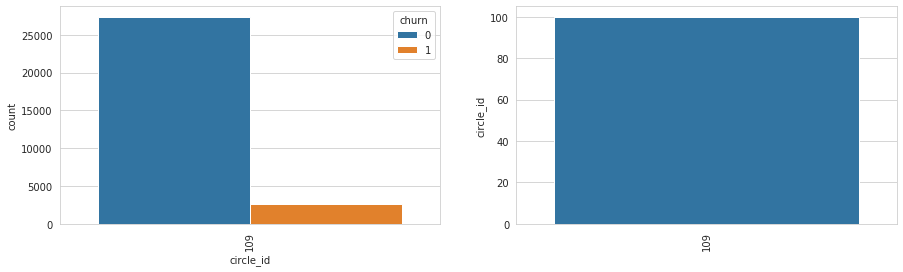

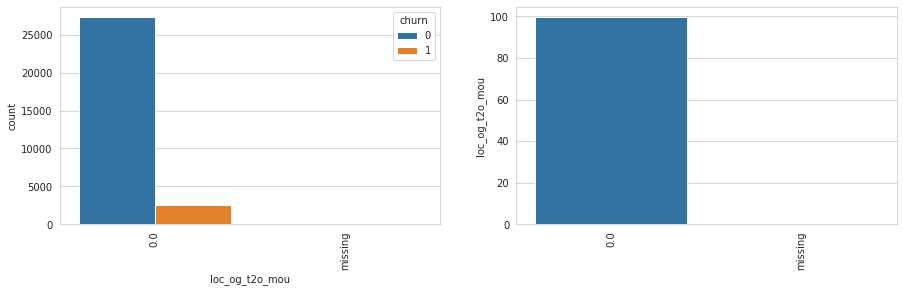

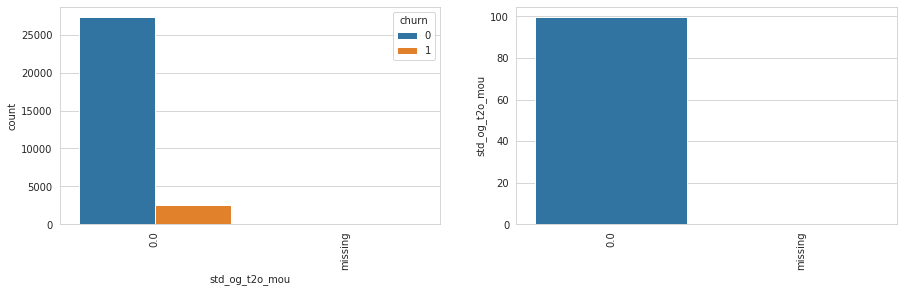

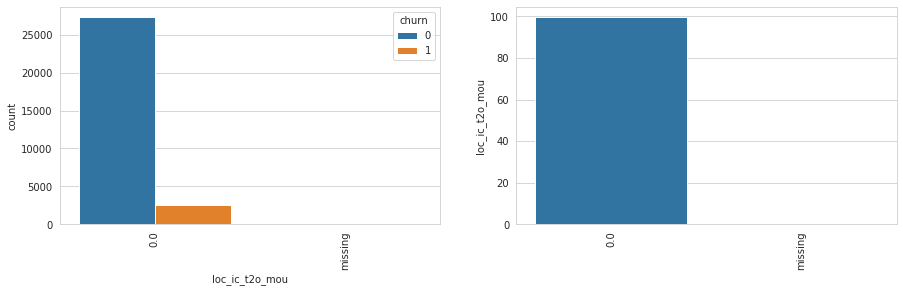

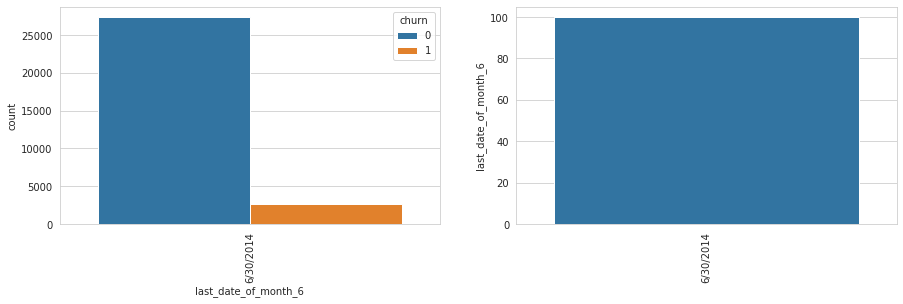

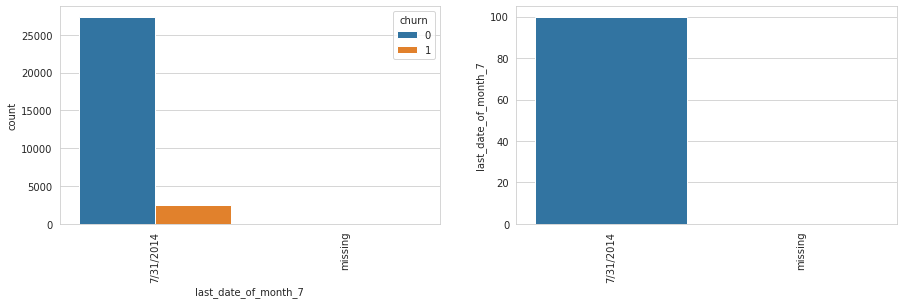

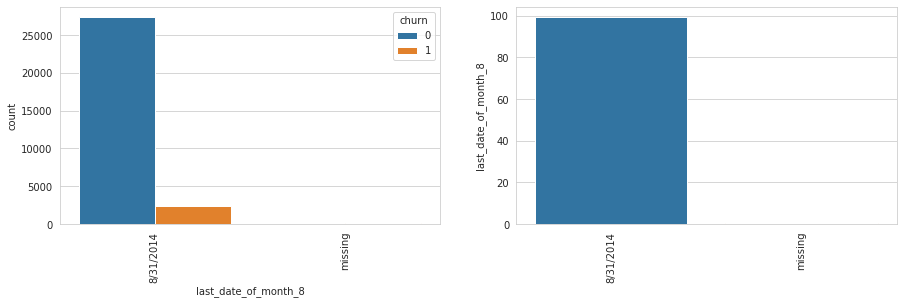

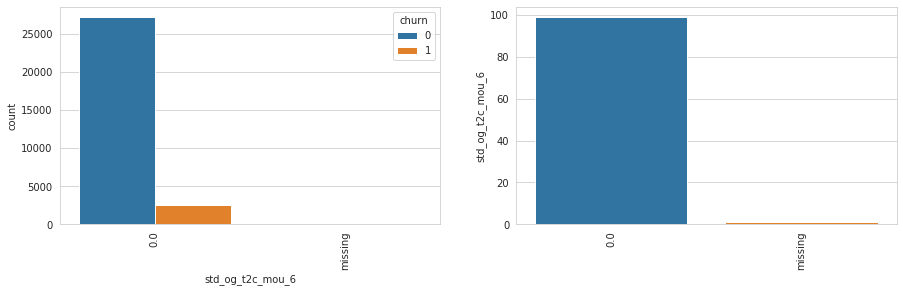

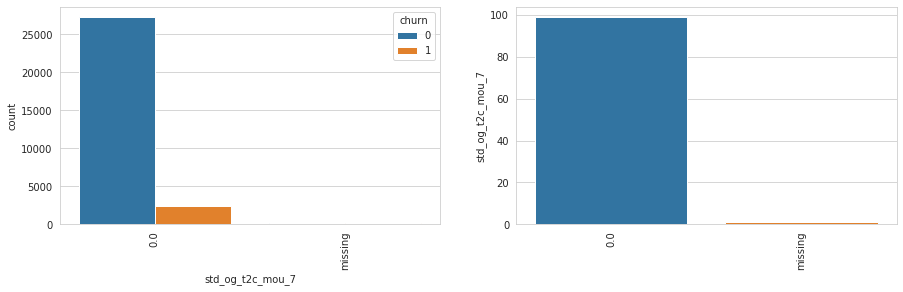

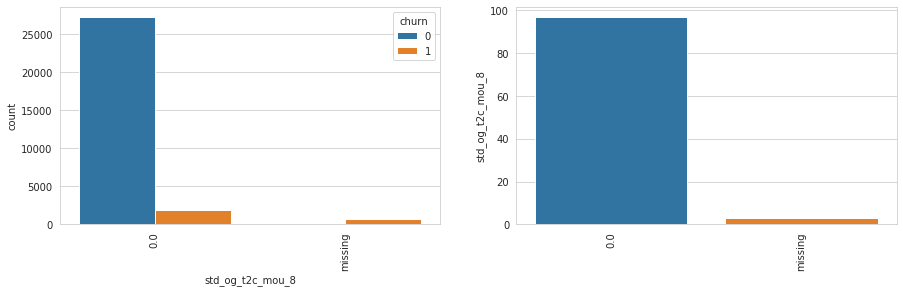

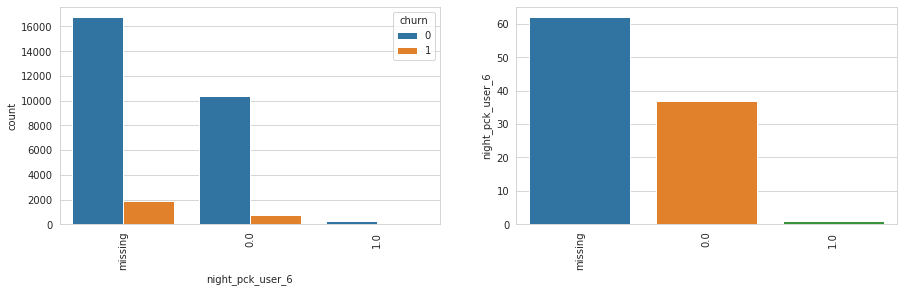

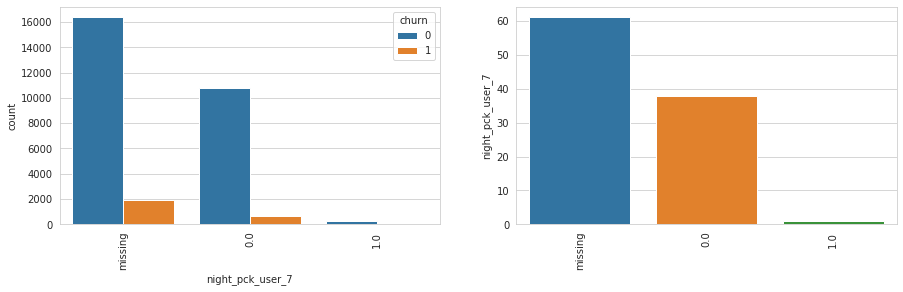

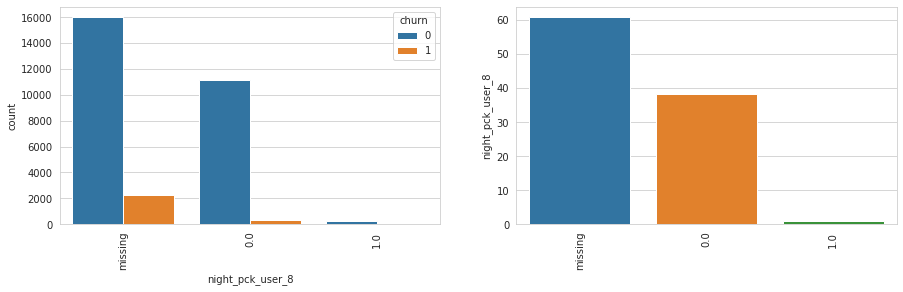

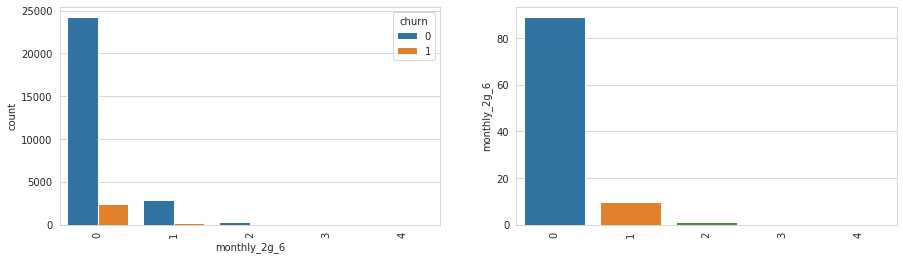

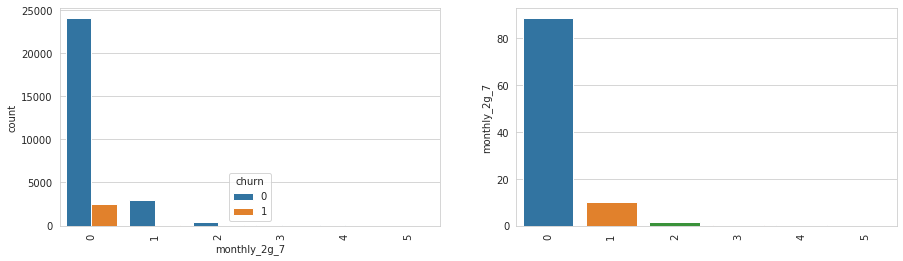

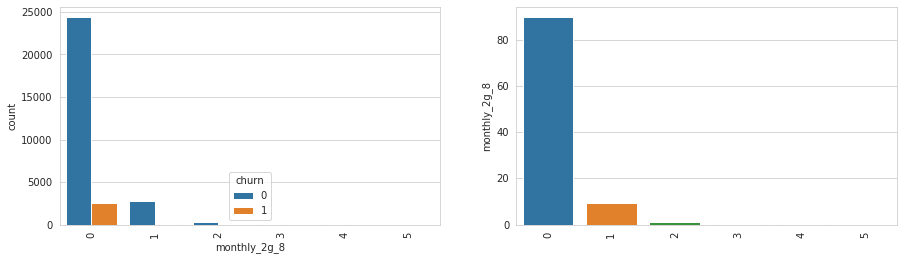

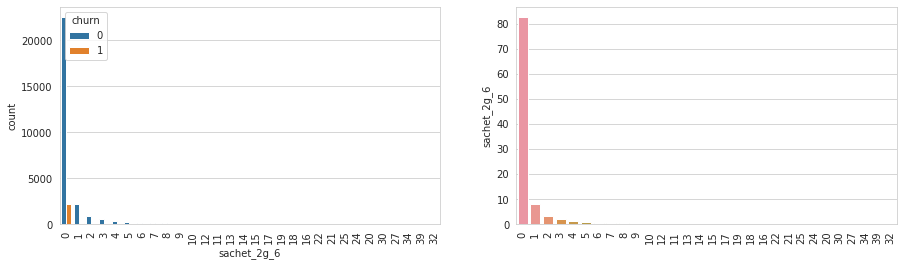

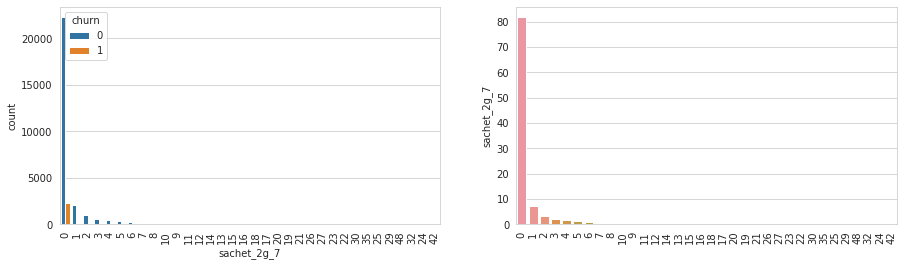

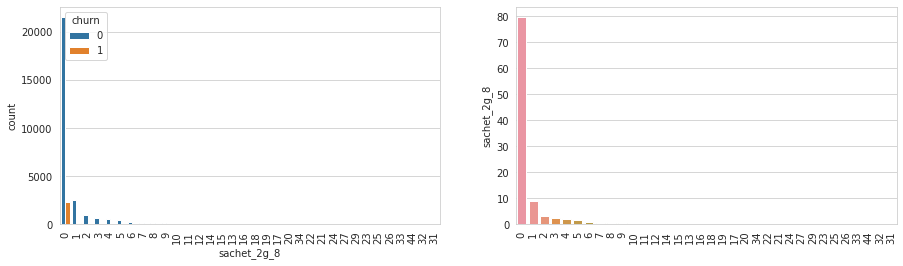

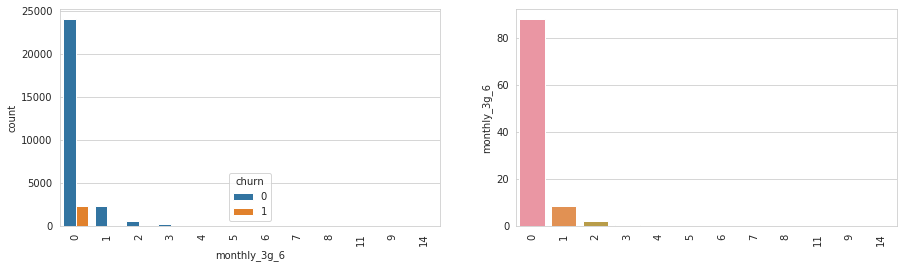

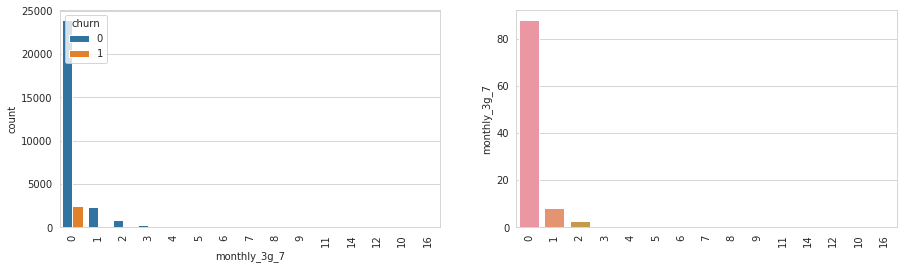

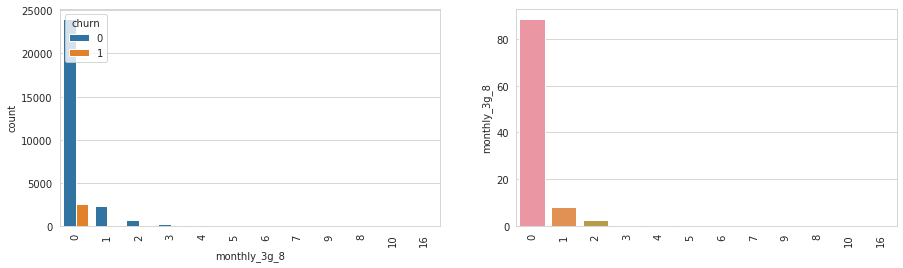

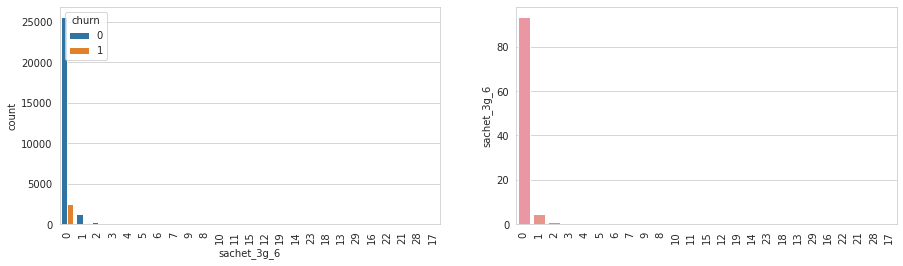

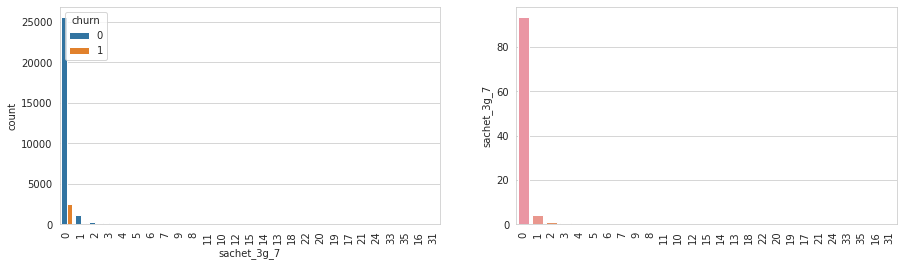

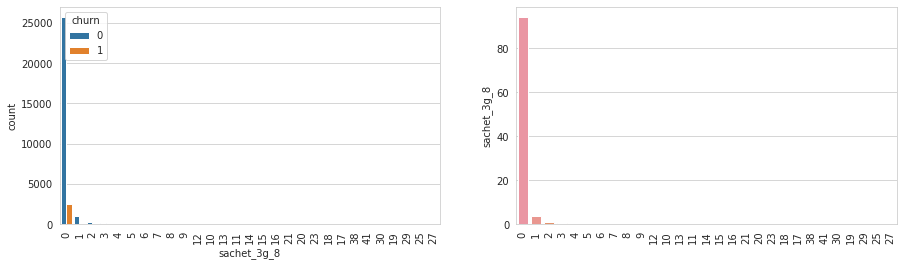

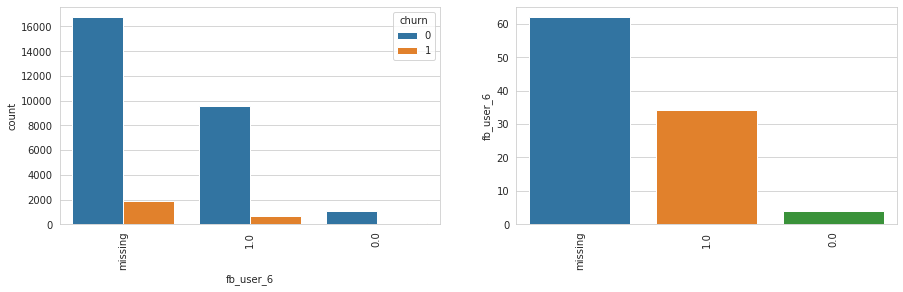

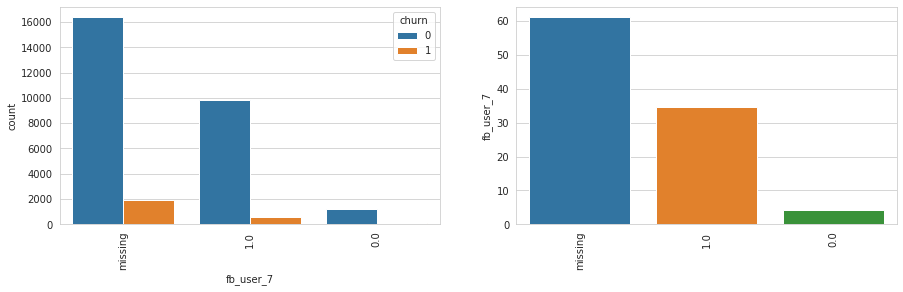

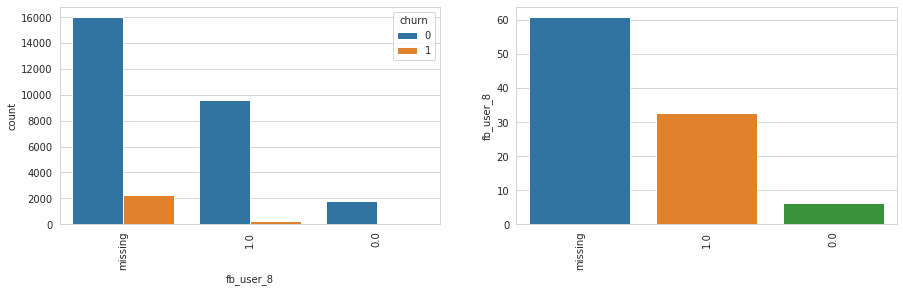

In [22]:
# plot categorical columns
plot_cat(cat_list)

As we can seen there variables with high missing and low variance (80% same value)

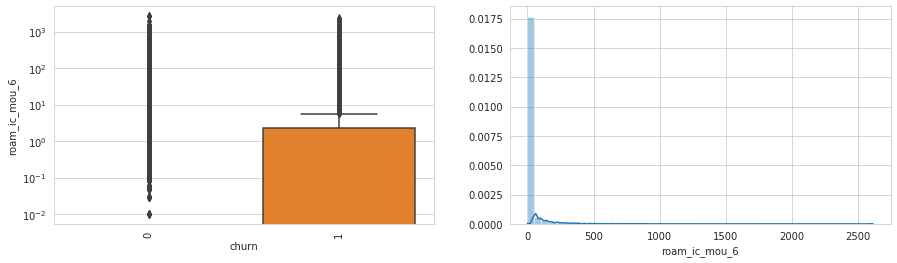

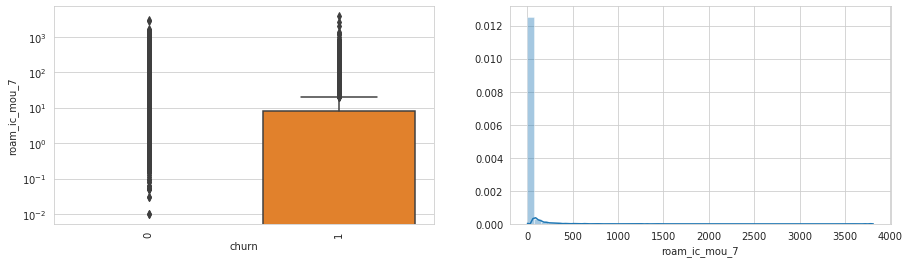

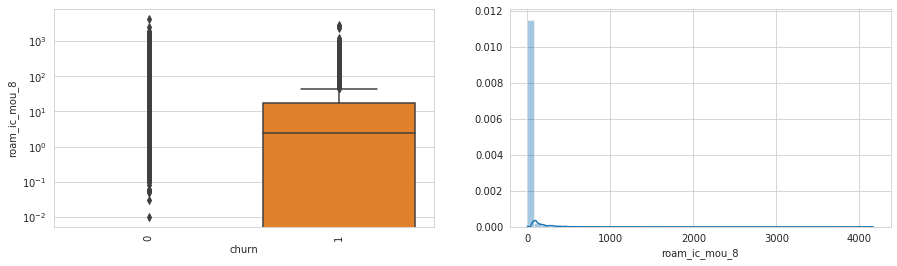

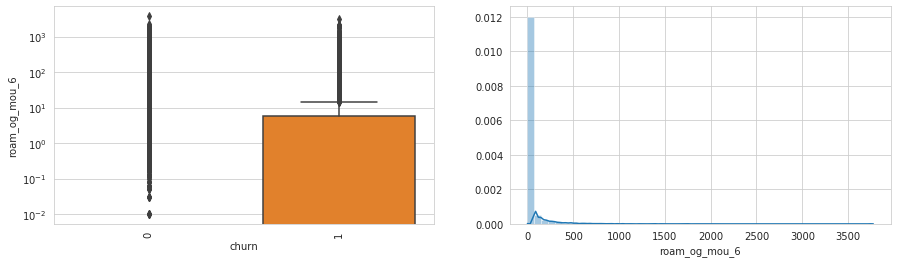

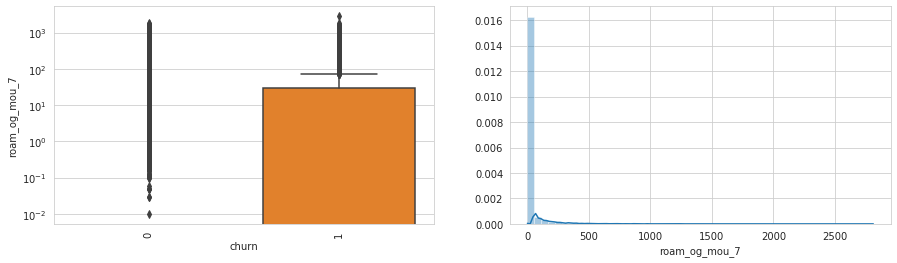

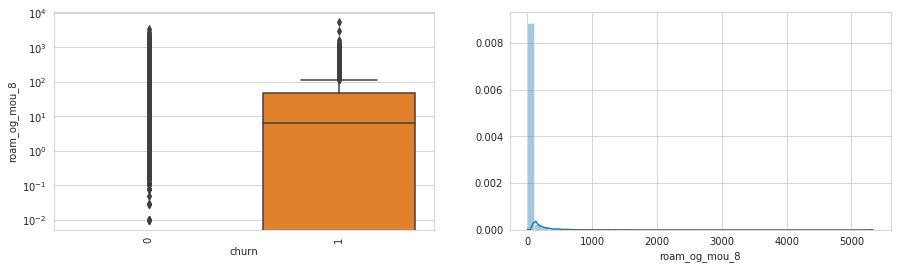

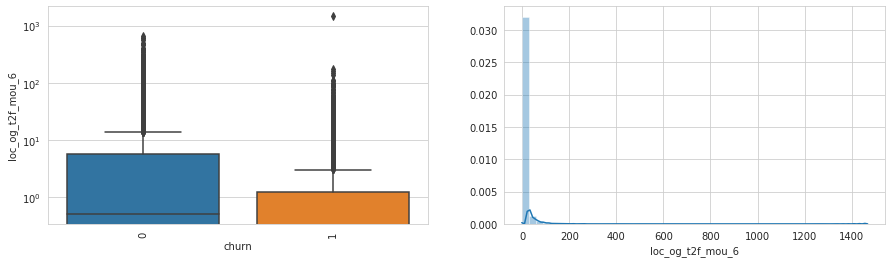

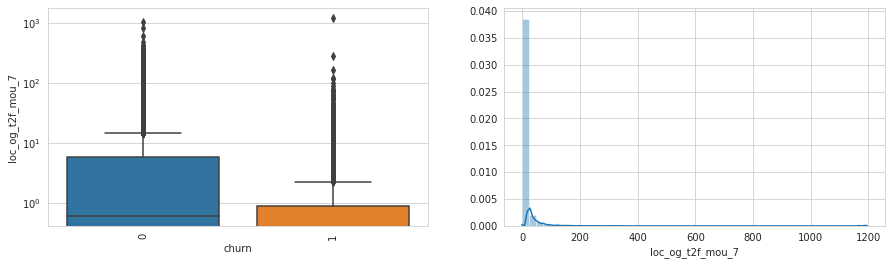

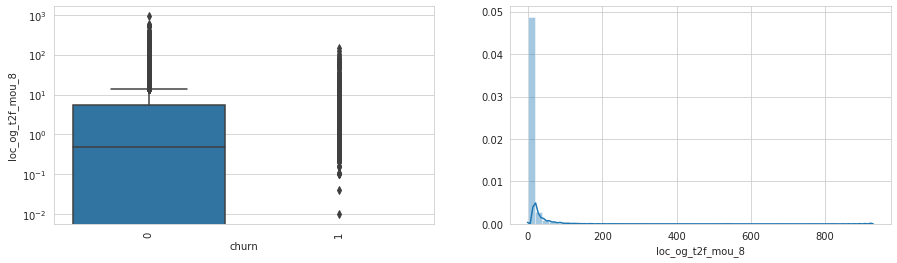

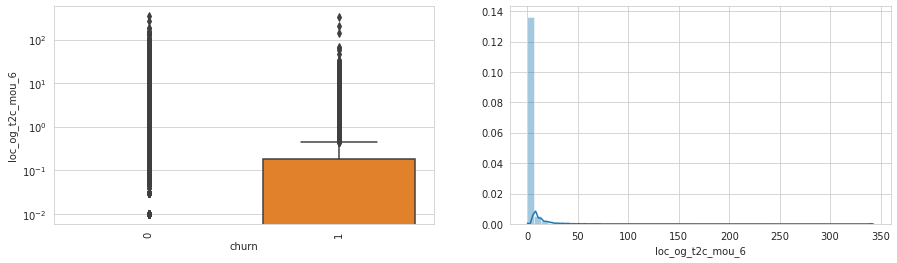

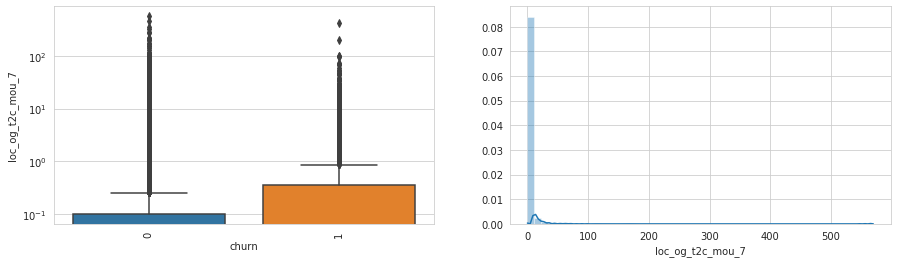

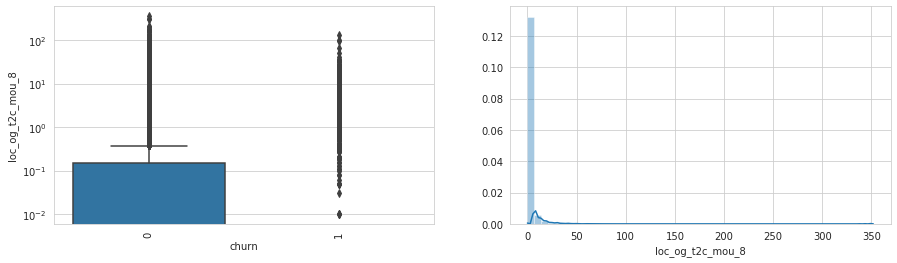

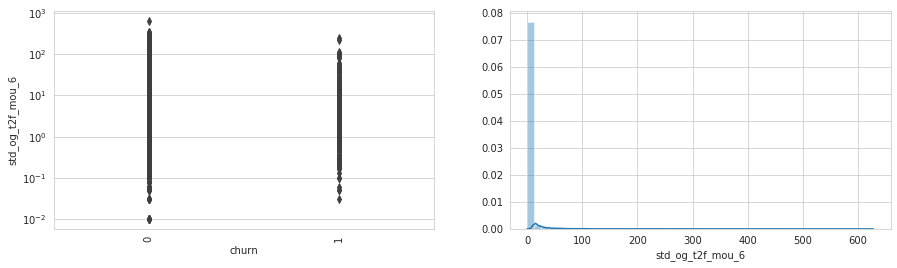

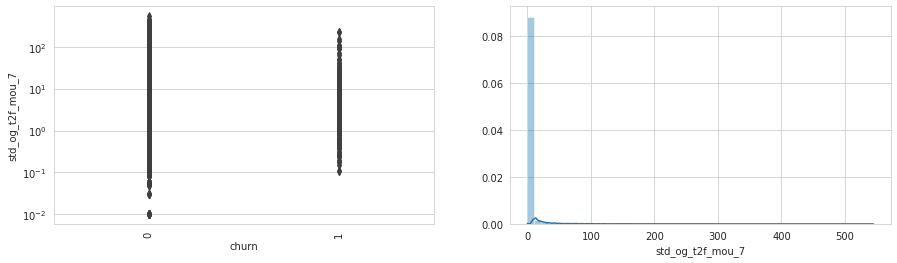

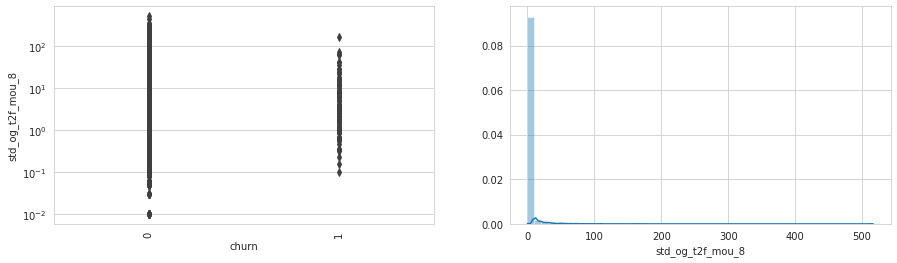

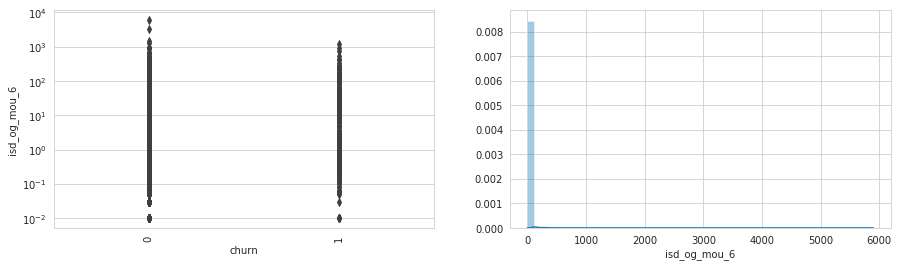

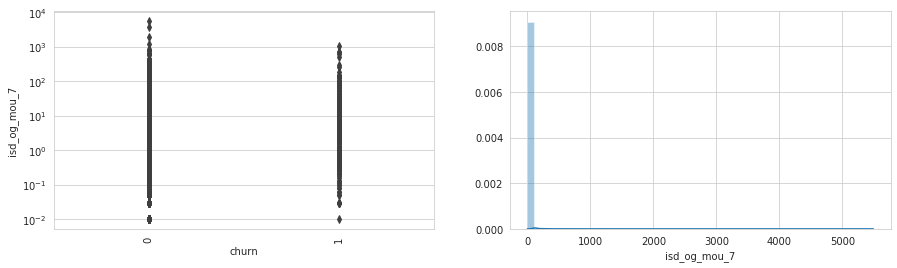

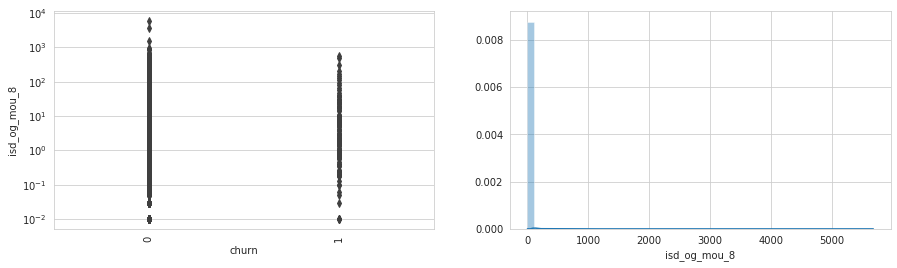

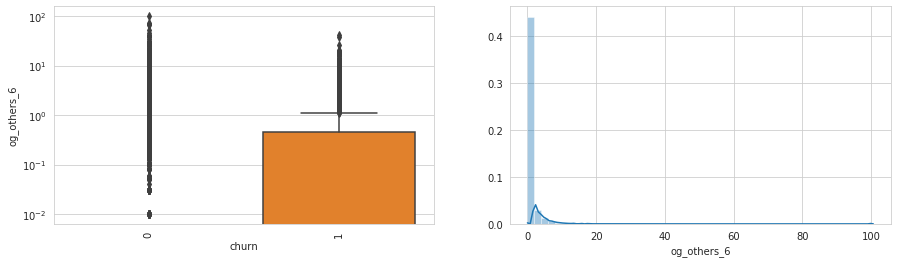

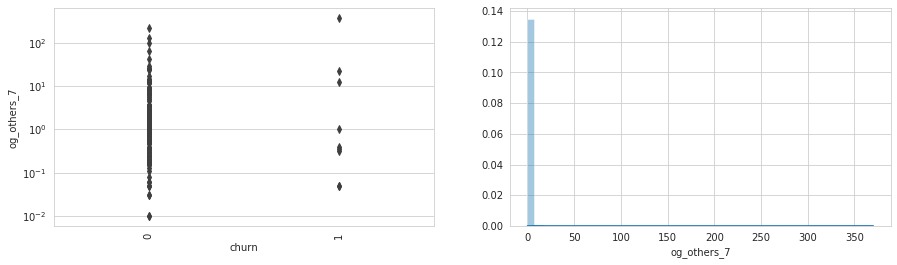

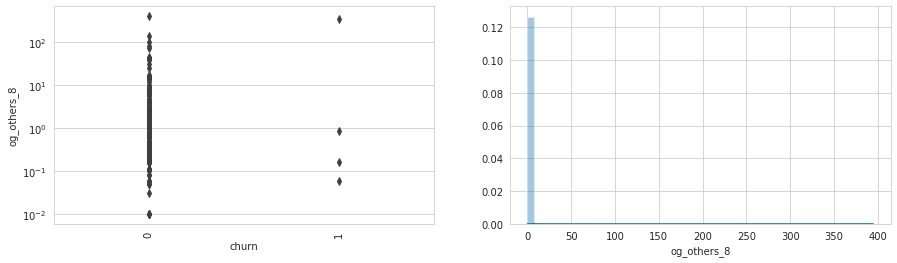

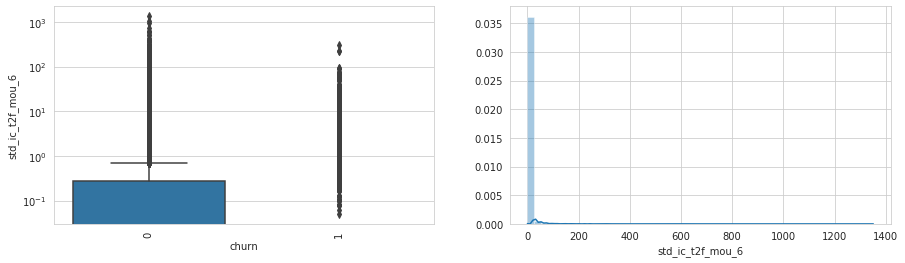

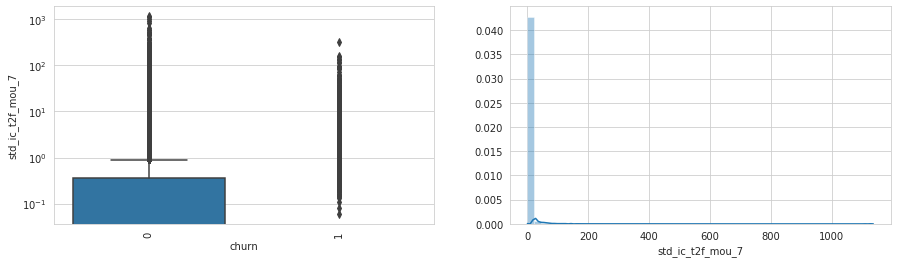

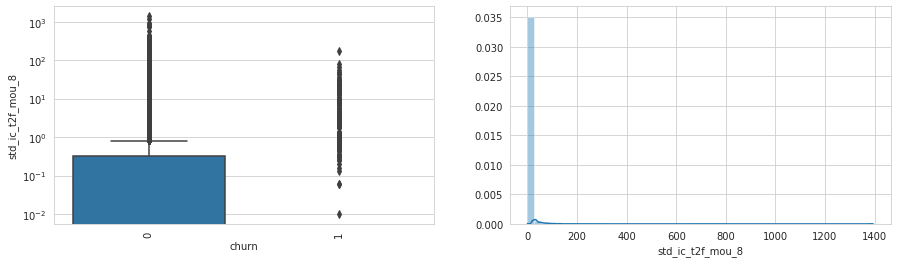

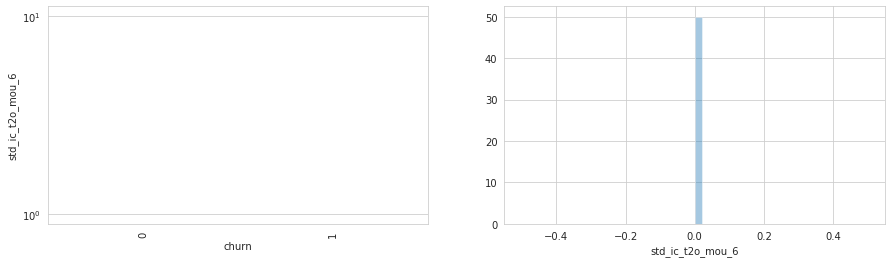

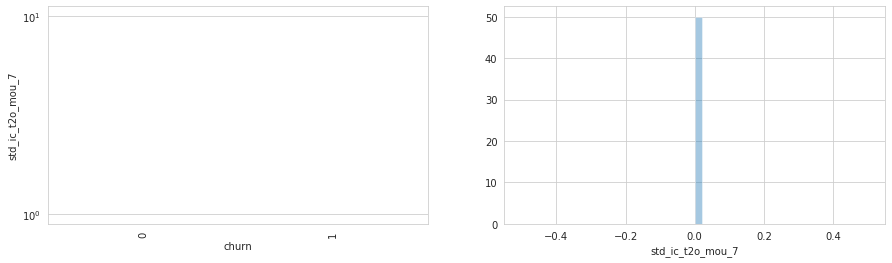

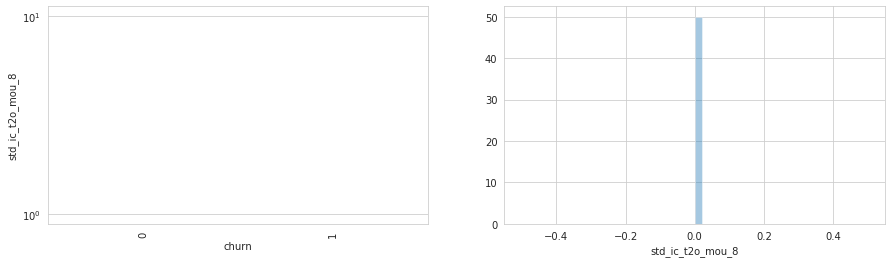

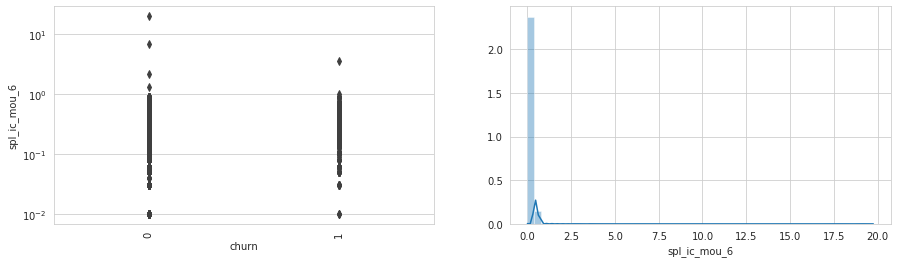

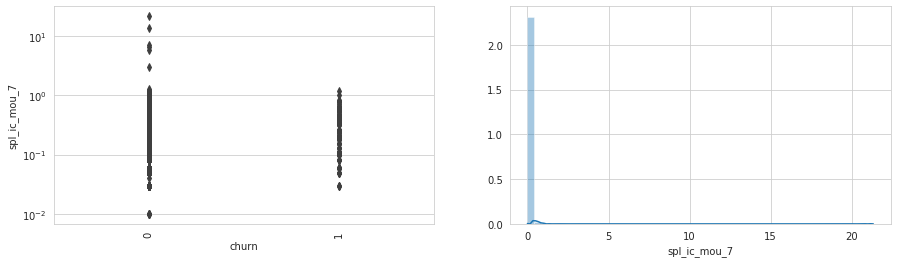

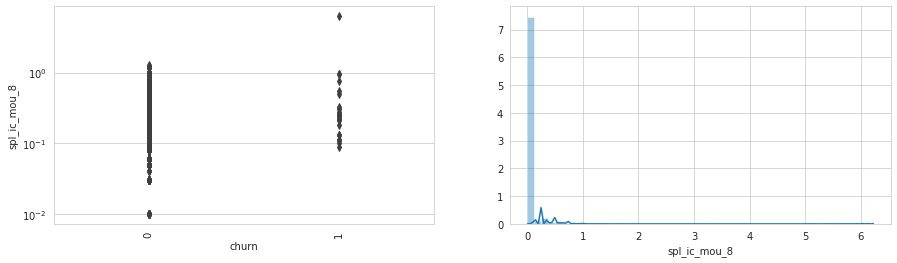

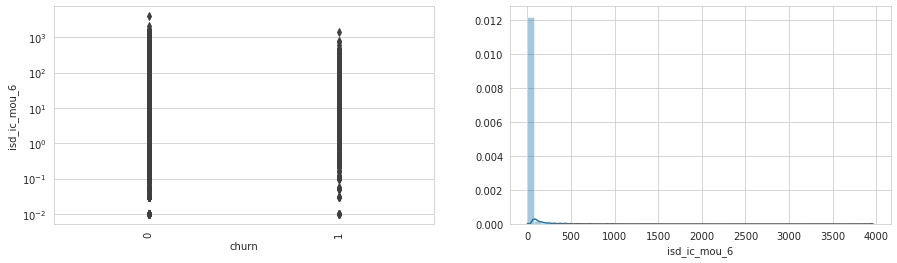

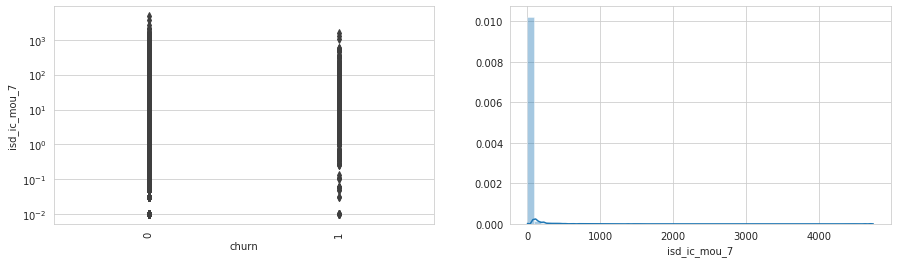

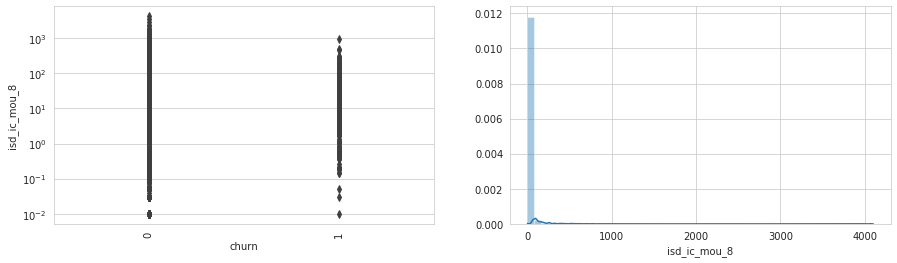

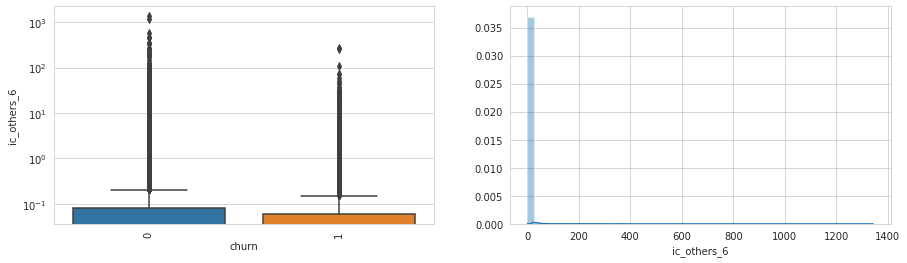

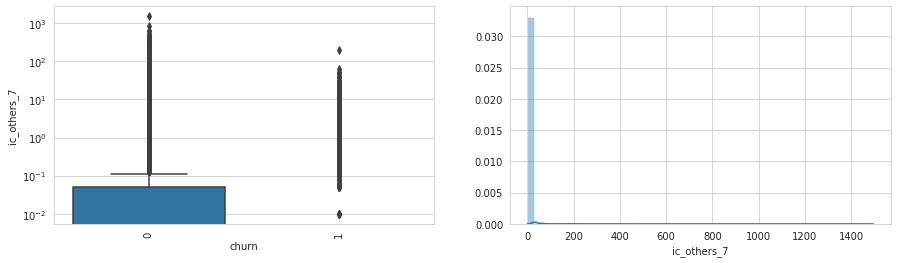

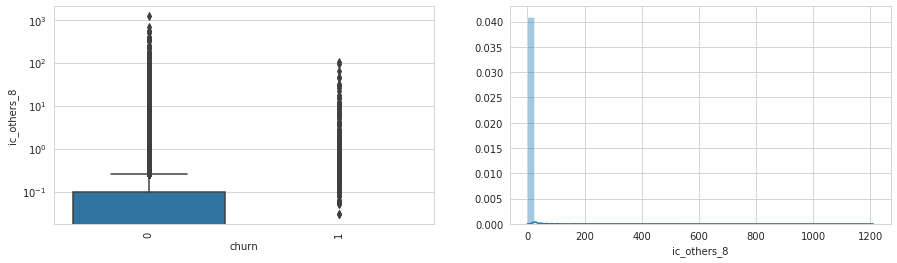

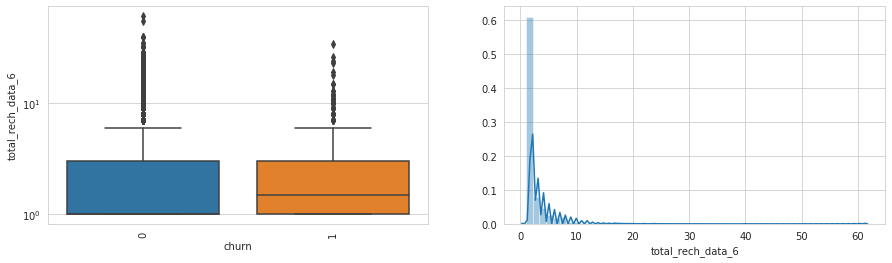

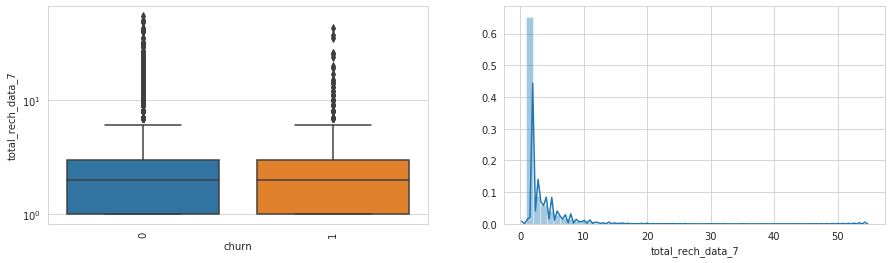

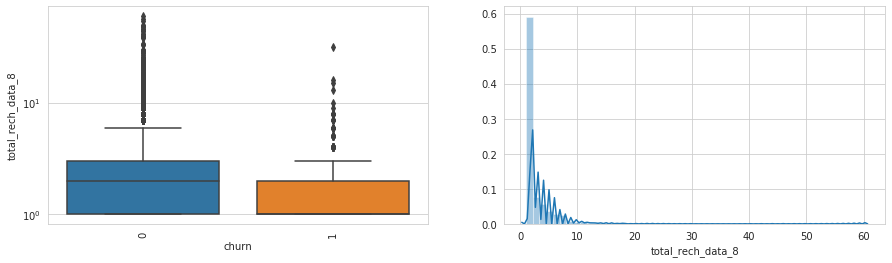

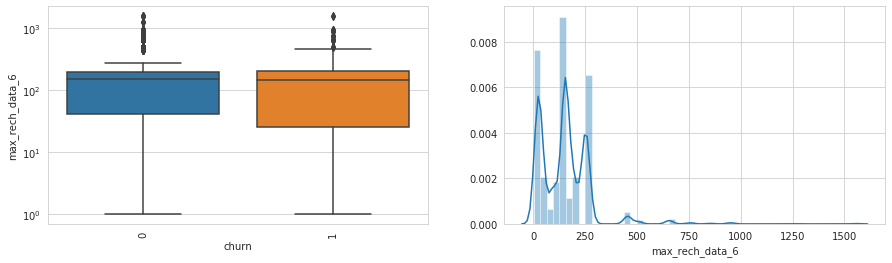

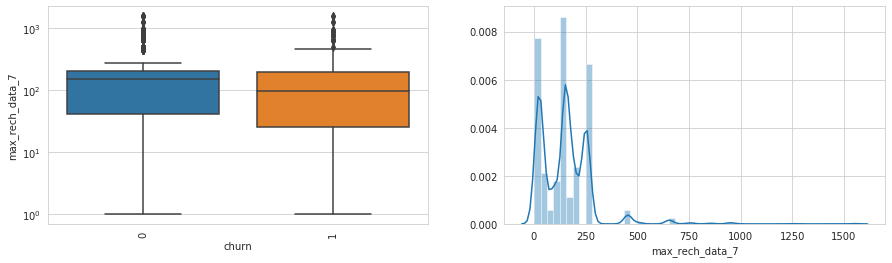

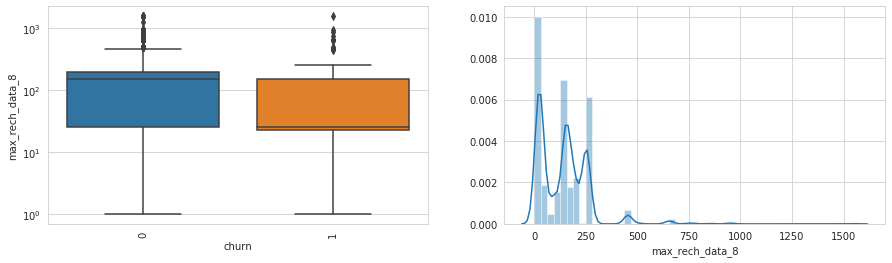

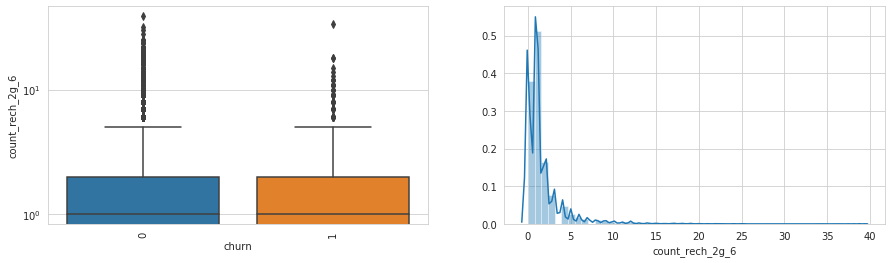

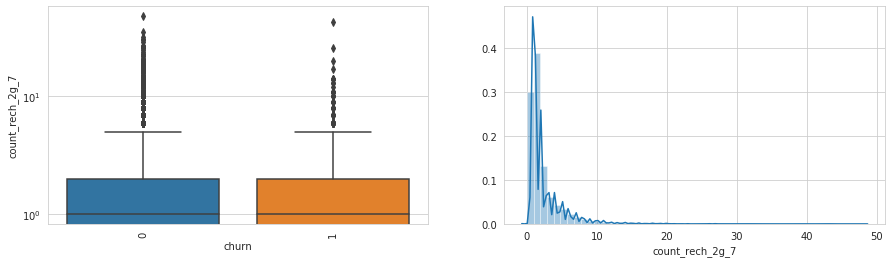

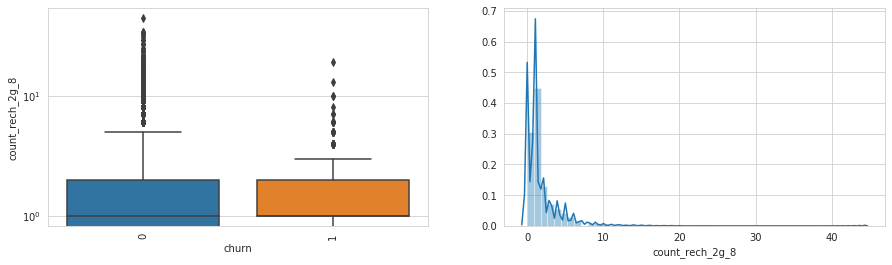

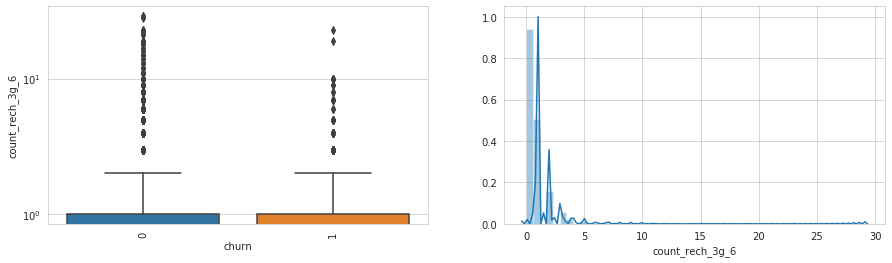

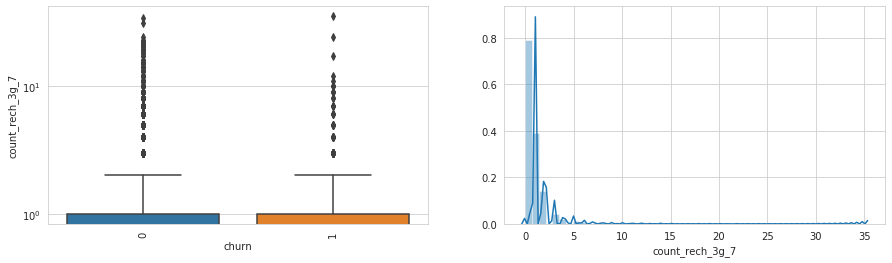

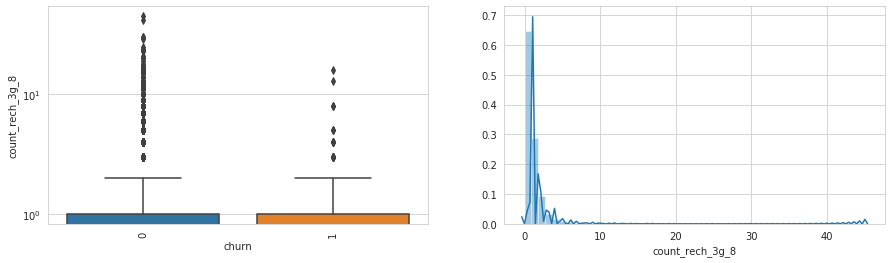

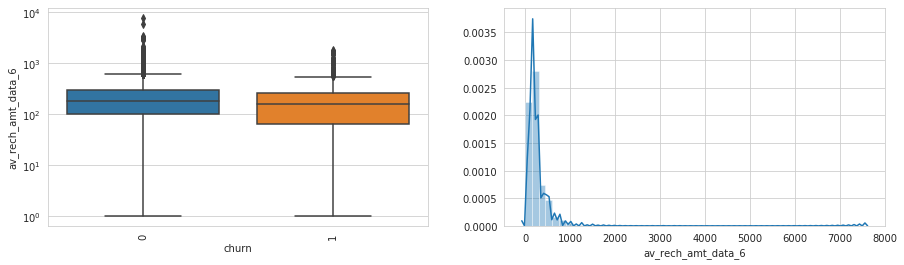

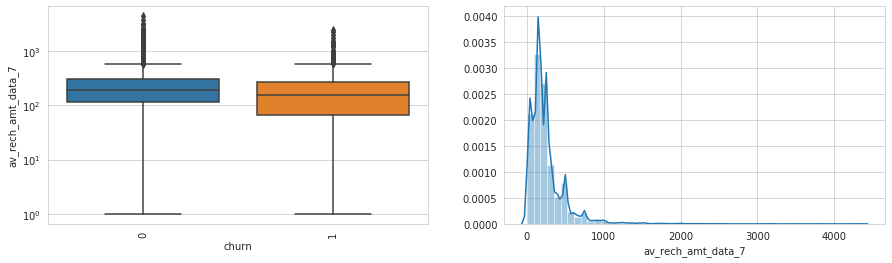

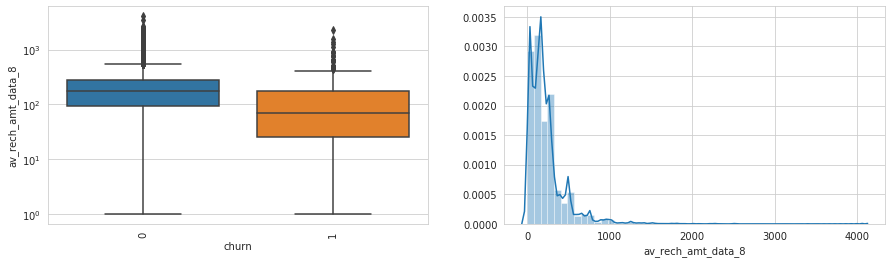

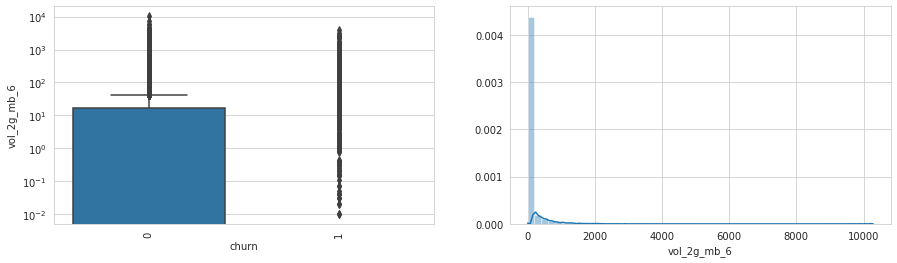

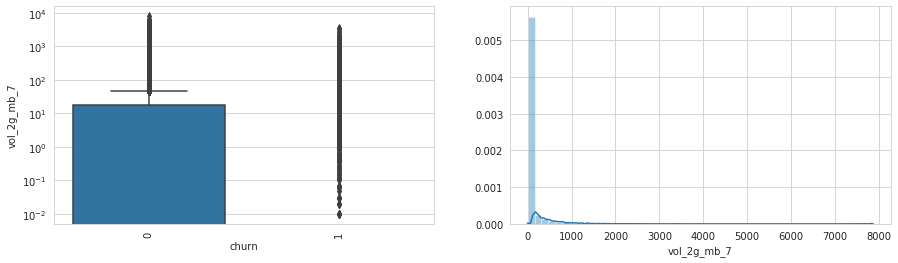

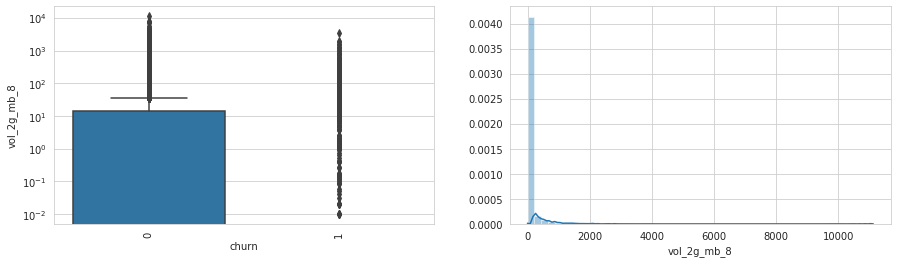

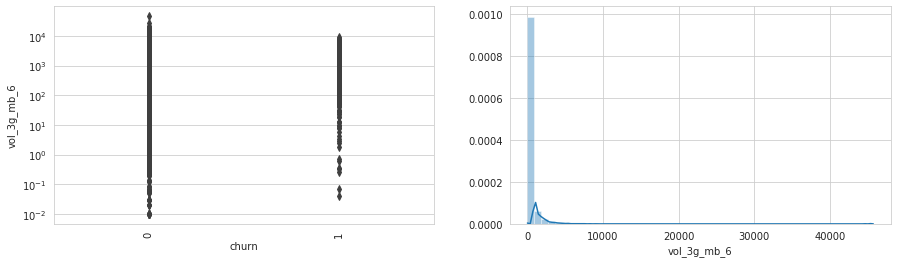

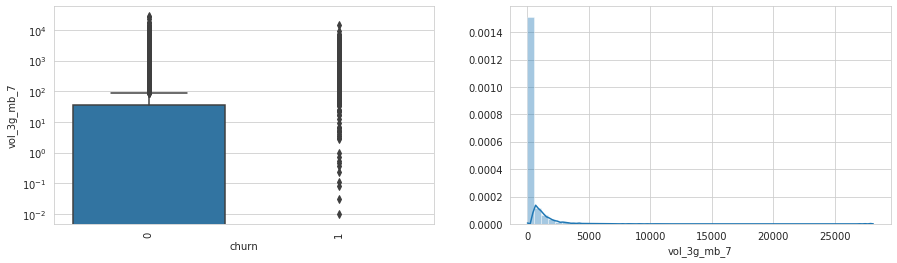

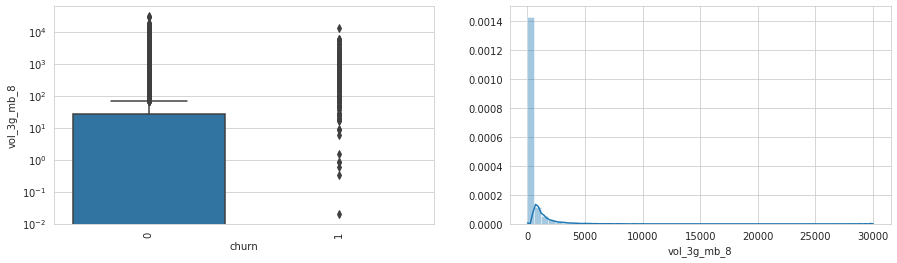

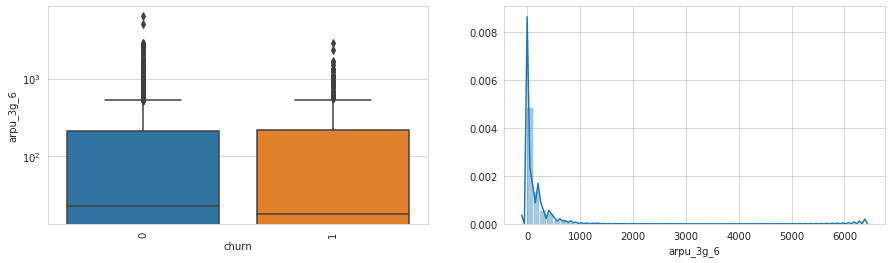

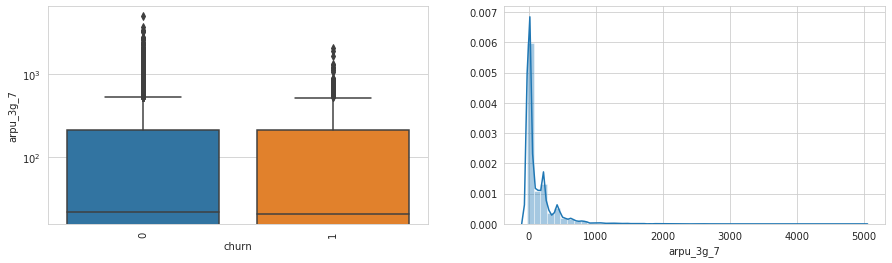

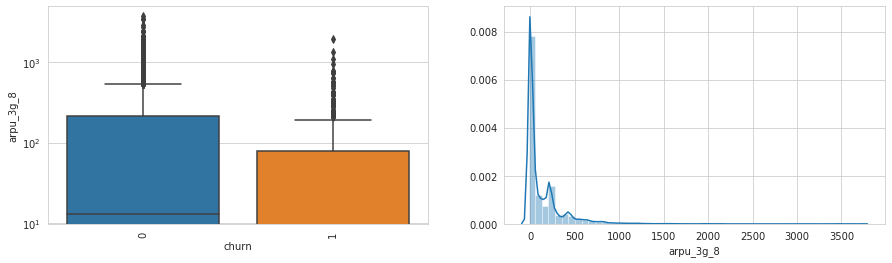

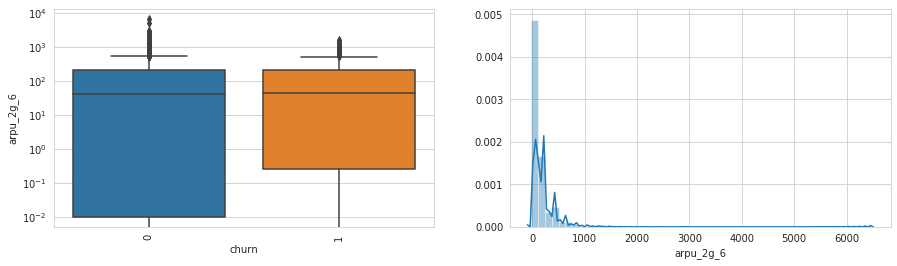

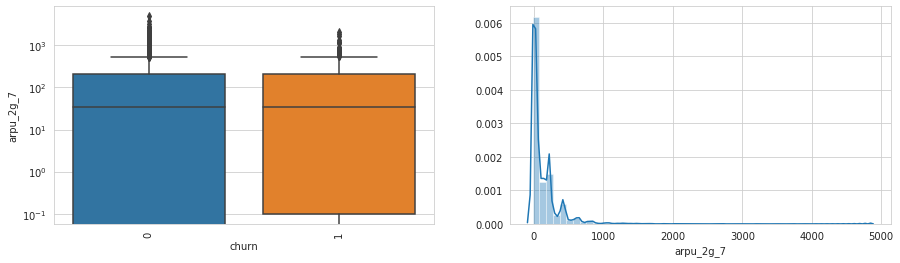

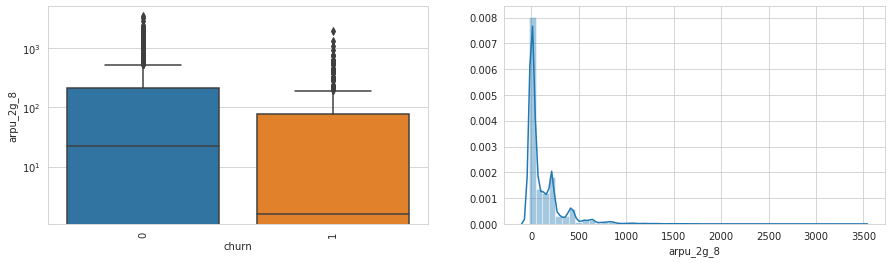

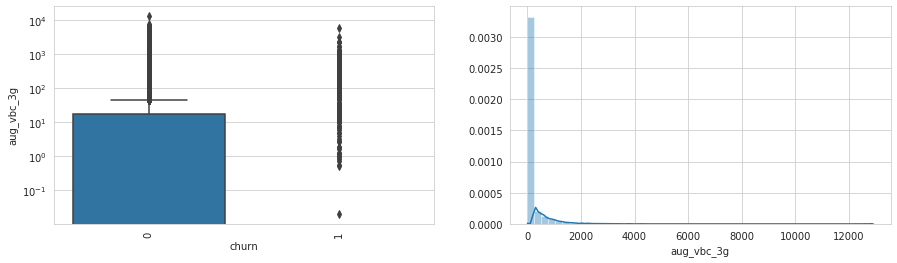

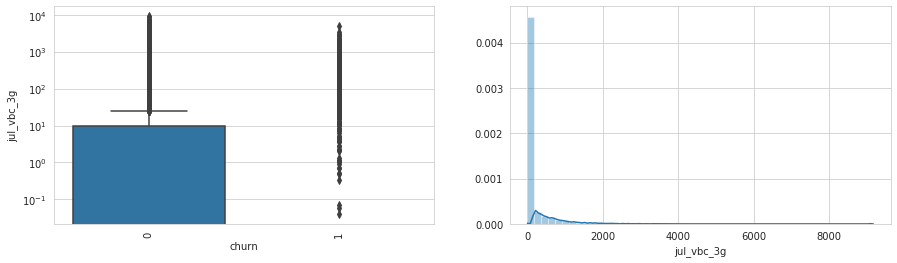

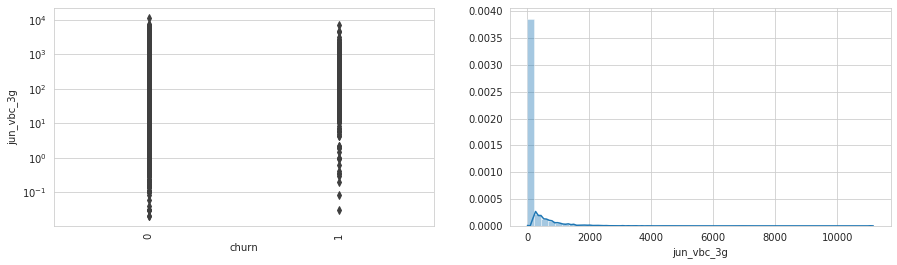

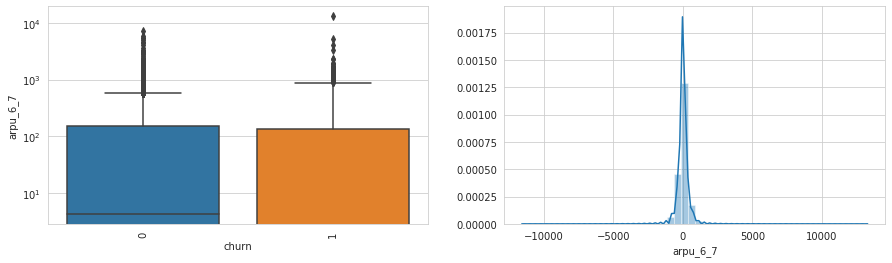

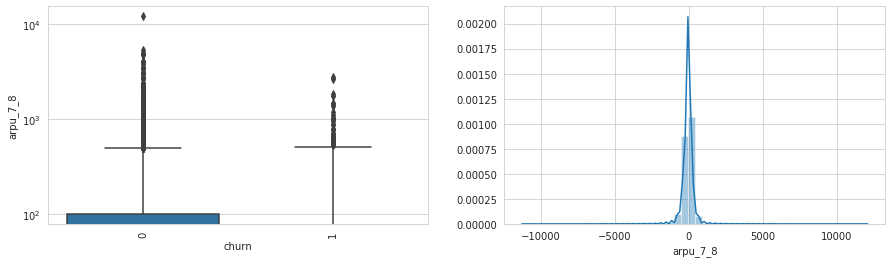

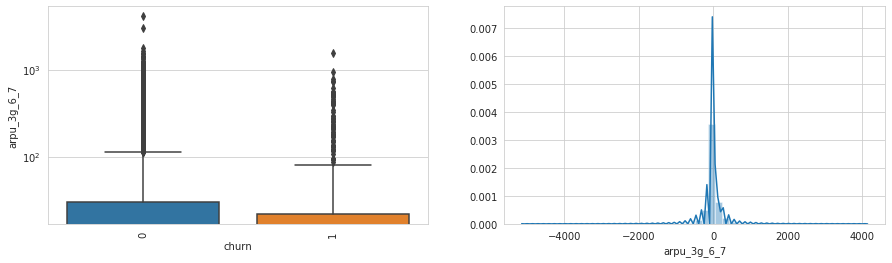

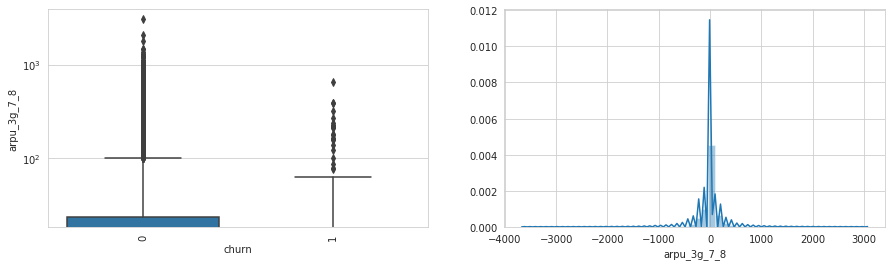

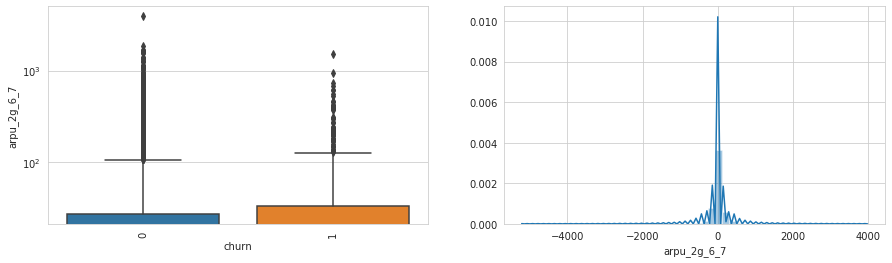

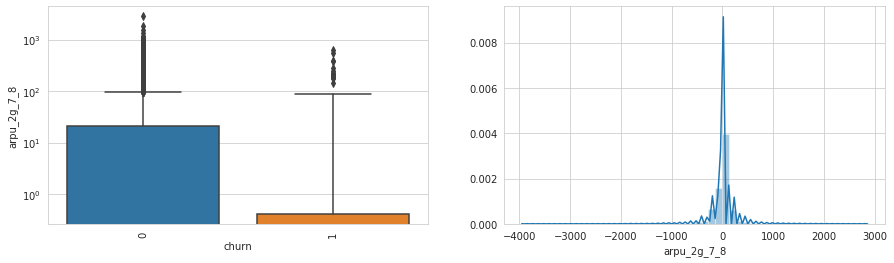

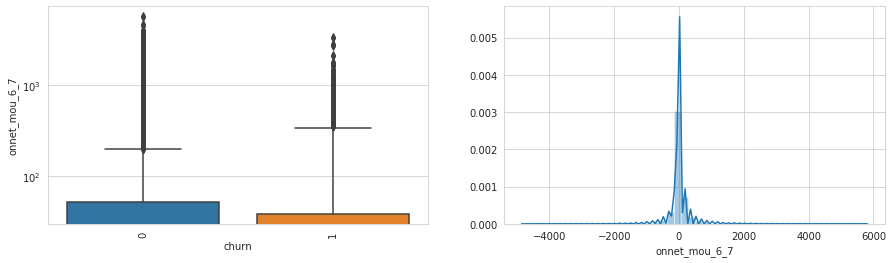

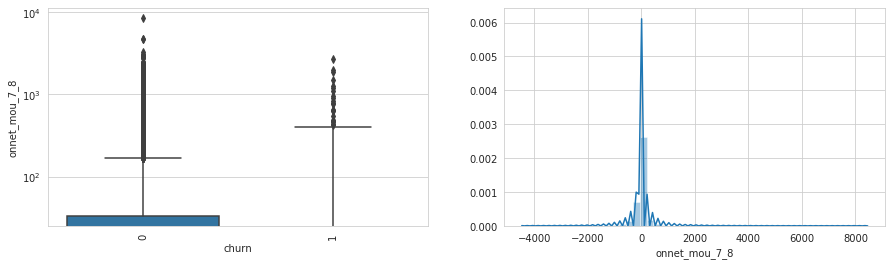

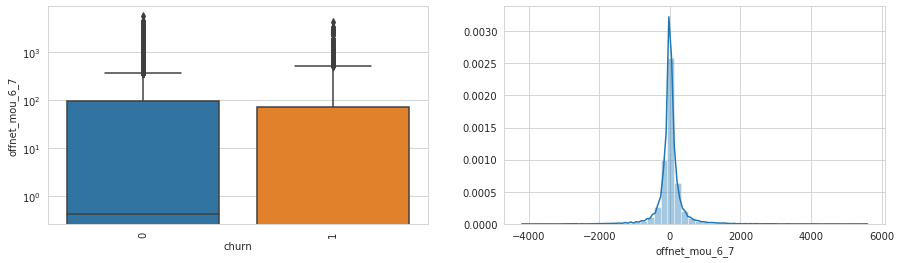

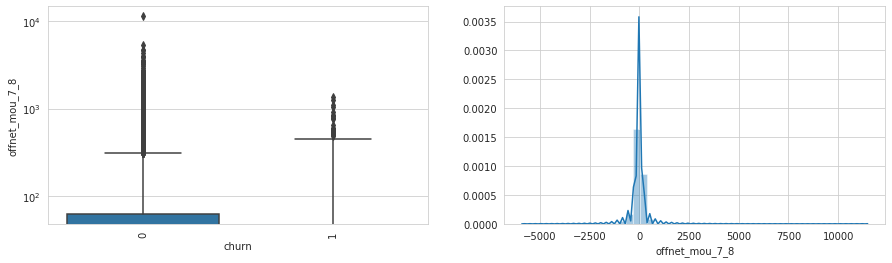

In [23]:
# plot numerical columns
plot_num(num_list, True)

As we can see, these variables behave identically for both churn and non-churn customers and have high outliers hence we will drop these columns

In [24]:
# drop unusable columns
drop_col(cat_list+num_list)

(29979, 77)

***Data preparations for columns showing relation with churn***

In [25]:
col_list = ['arpu_6','arpu_7','arpu_8','onnet_mou_6','onnet_mou_7','onnet_mou_8','offnet_mou_6','offnet_mou_7','offnet_mou_8',
            'loc_og_t2t_mou_6','loc_og_t2t_mou_7','loc_og_t2t_mou_8','loc_og_t2m_mou_6','loc_og_t2m_mou_7','loc_og_t2m_mou_8',
            'loc_og_mou_6','loc_og_mou_7','loc_og_mou_8','std_og_t2t_mou_6','std_og_t2t_mou_7','std_og_t2t_mou_8',
            'std_og_t2m_mou_6','std_og_t2m_mou_7','std_og_t2m_mou_8','std_og_mou_6','std_og_mou_7','std_og_mou_8',
            'spl_og_mou_6','spl_og_mou_7','spl_og_mou_8','total_og_mou_6','total_og_mou_7','total_og_mou_8','loc_ic_t2t_mou_6',
            'loc_ic_t2t_mou_7','loc_ic_t2t_mou_8','loc_ic_t2m_mou_6','loc_ic_t2m_mou_7','loc_ic_t2m_mou_8','loc_ic_t2f_mou_6',
            'loc_ic_t2f_mou_7','loc_ic_t2f_mou_8','loc_ic_mou_6','loc_ic_mou_7','loc_ic_mou_8','std_ic_t2t_mou_6',
            'std_ic_t2t_mou_7','std_ic_t2t_mou_8','std_ic_t2m_mou_6','std_ic_t2m_mou_7','std_ic_t2m_mou_8',
            'std_ic_mou_6','std_ic_mou_7','std_ic_mou_8','total_ic_mou_6','total_ic_mou_7','total_ic_mou_8','total_rech_num_6',
            'total_rech_num_7','total_rech_num_8','total_rech_amt_6','total_rech_amt_7','total_rech_amt_8','max_rech_amt_6',
            'max_rech_amt_7','max_rech_amt_8','last_day_rch_amt_6','last_day_rch_amt_7','last_day_rch_amt_8','aon']

In [26]:
len(col_list)

70

Lets plot the variables to understand their distribution and behaviour w.r.t. churn

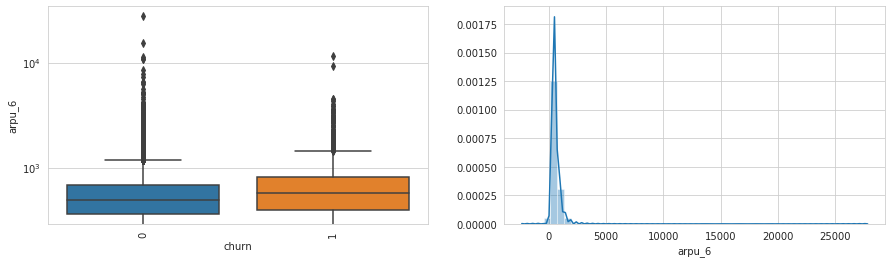

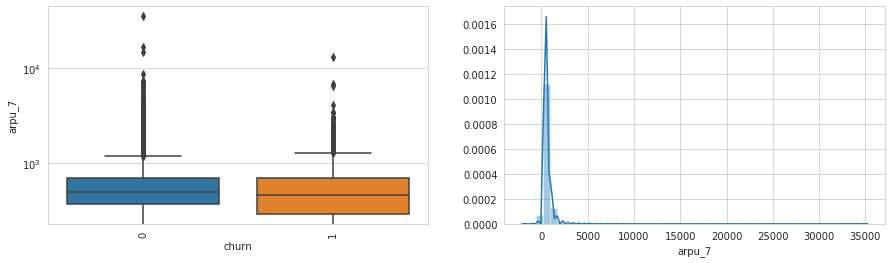

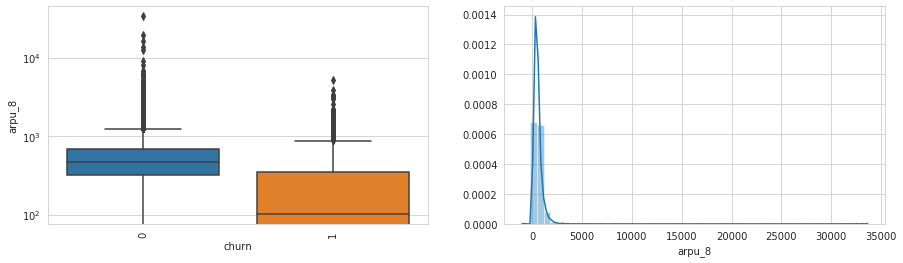

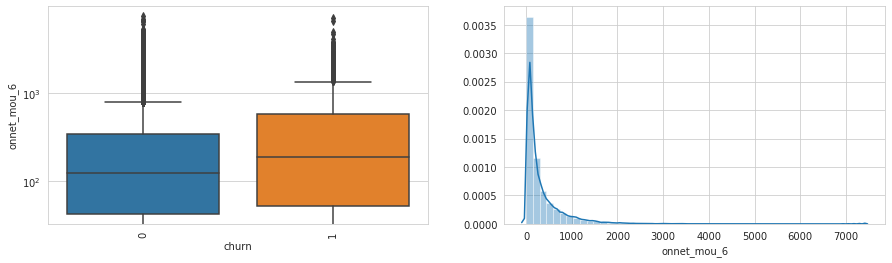

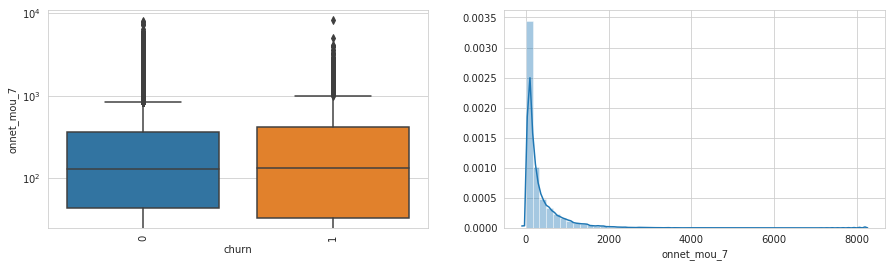

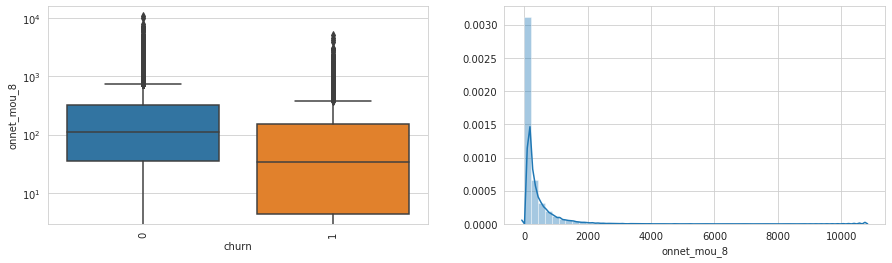

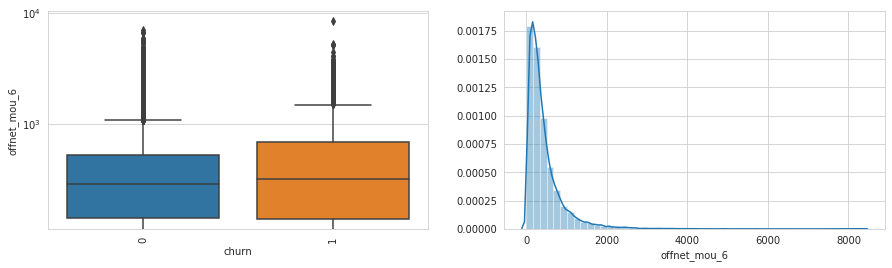

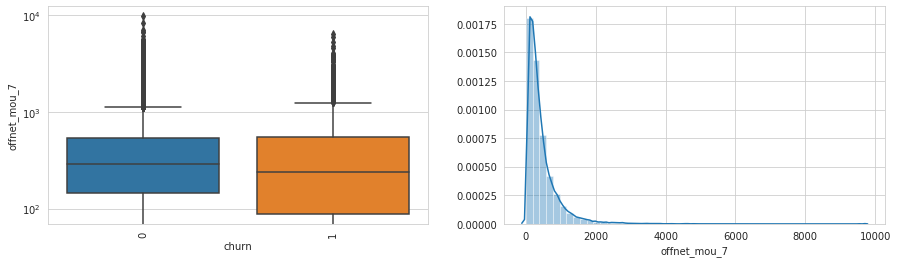

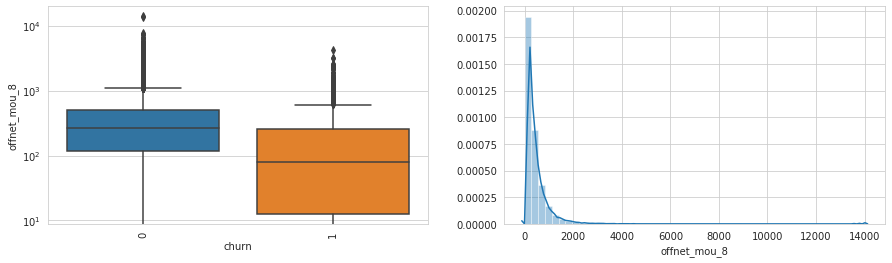

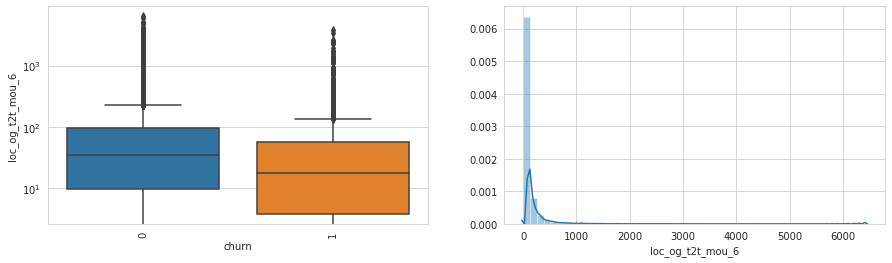

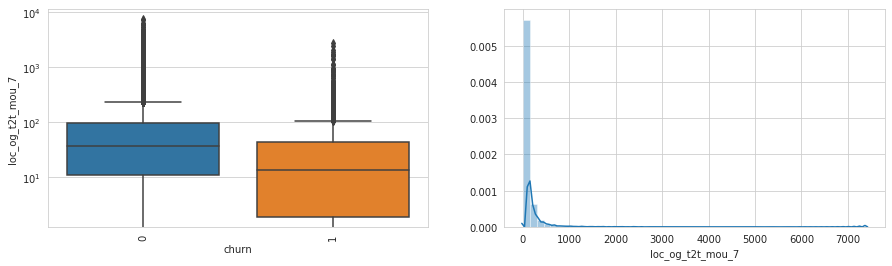

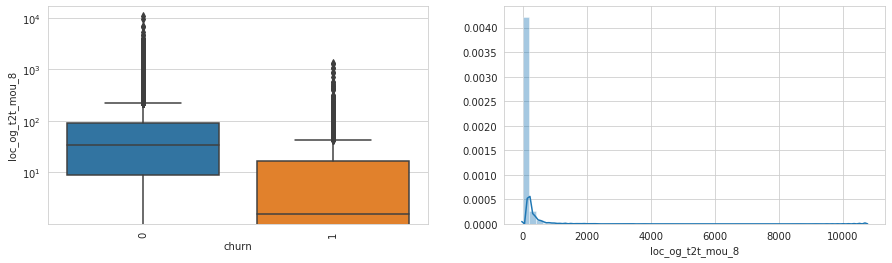

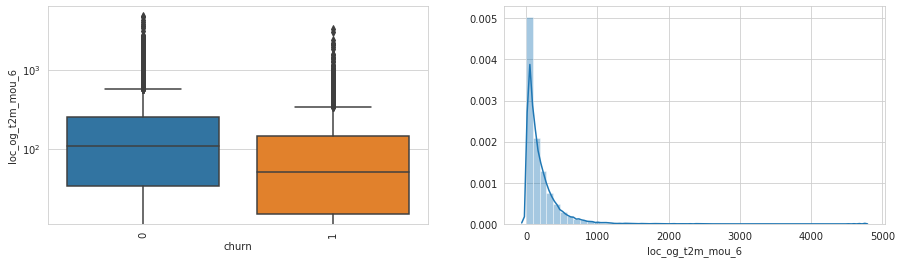

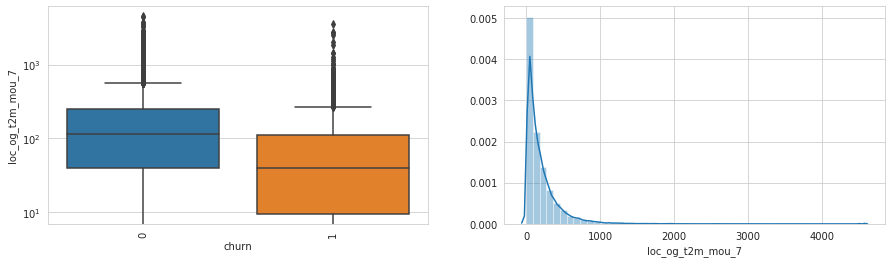

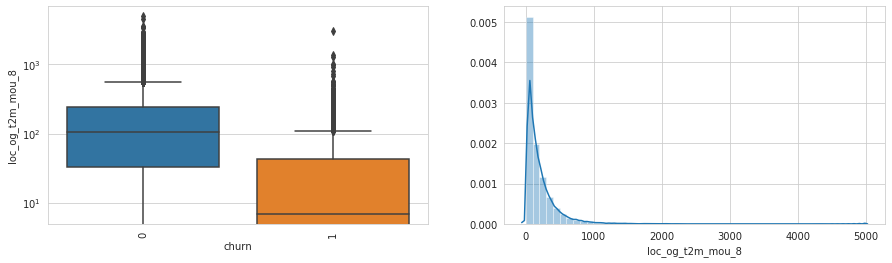

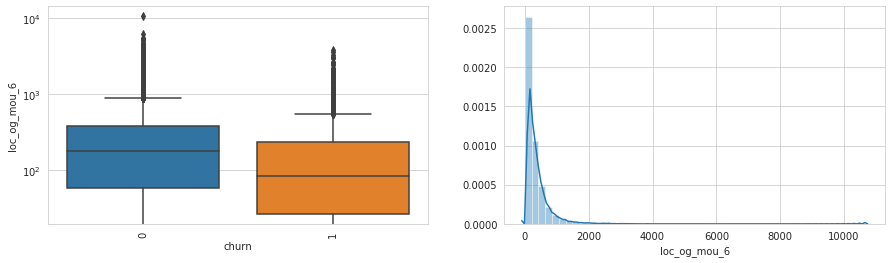

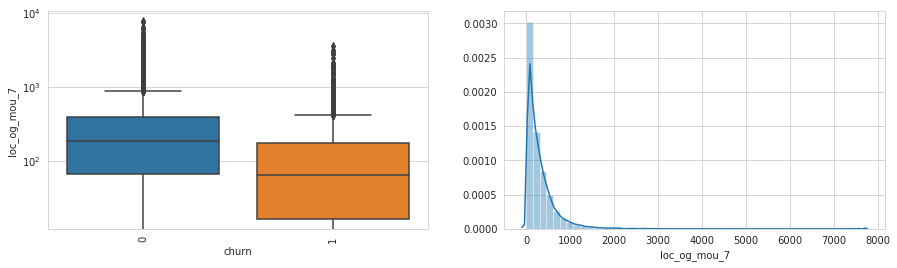

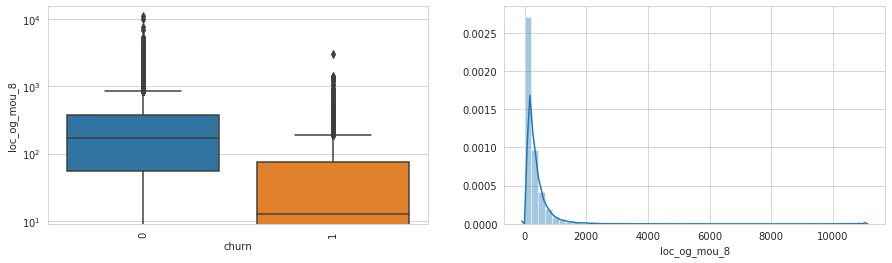

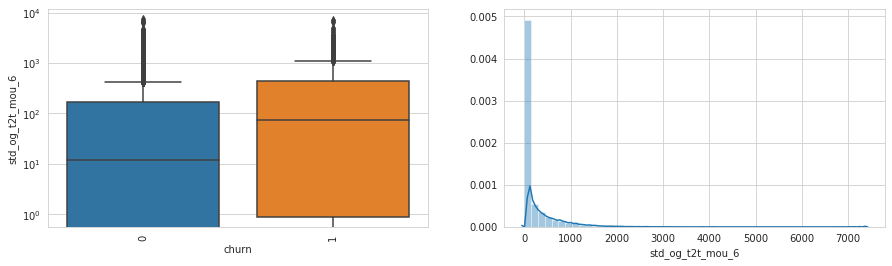

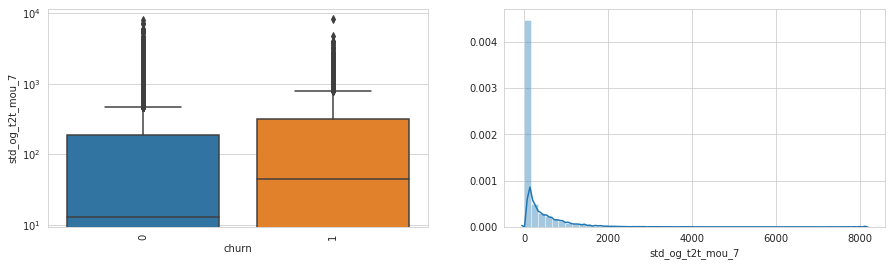

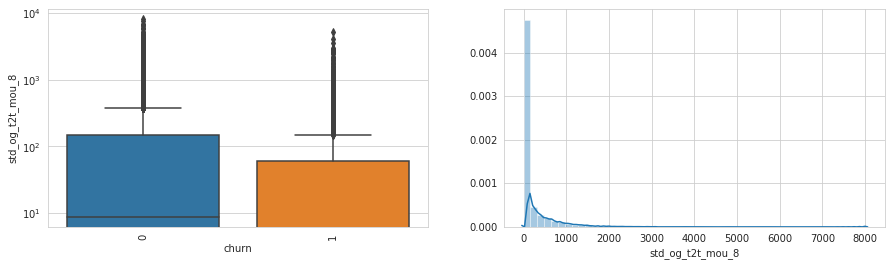

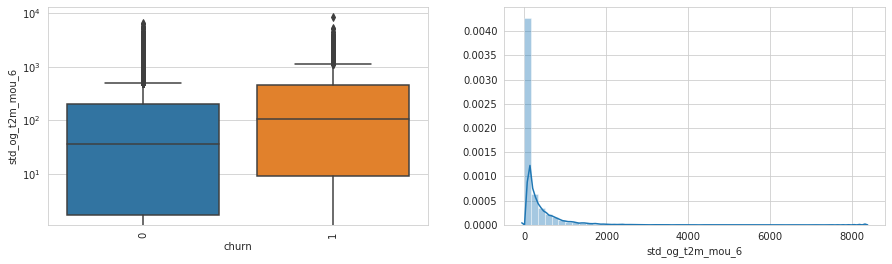

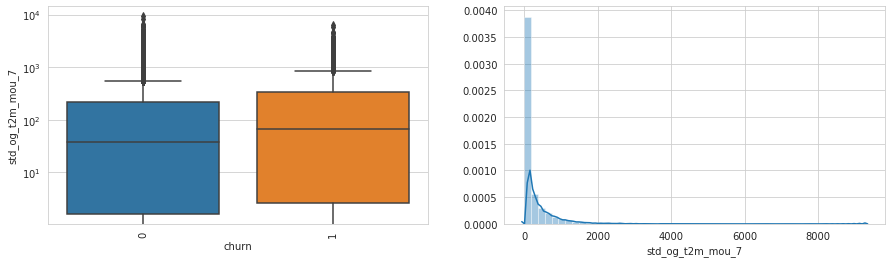

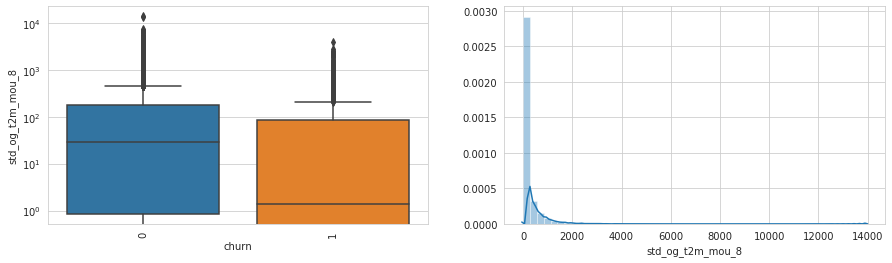

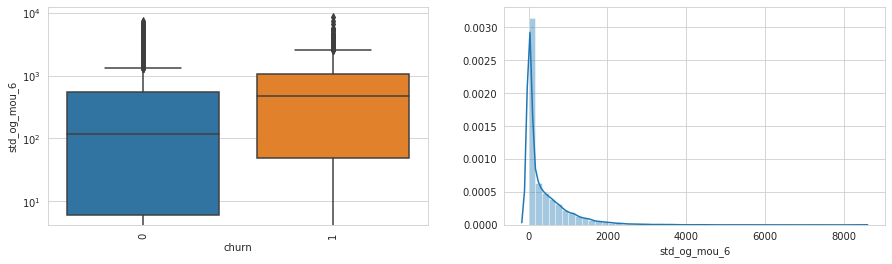

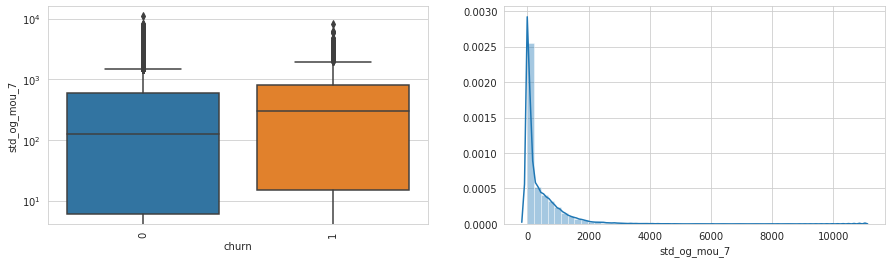

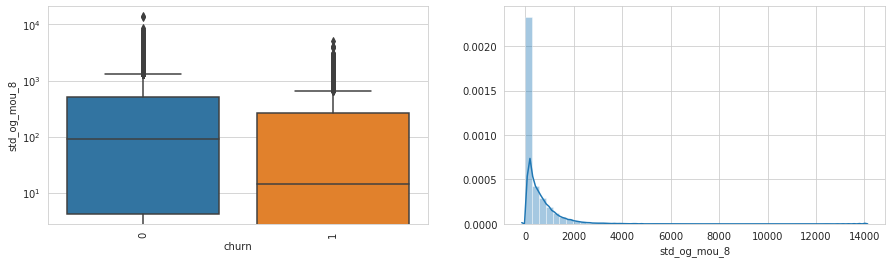

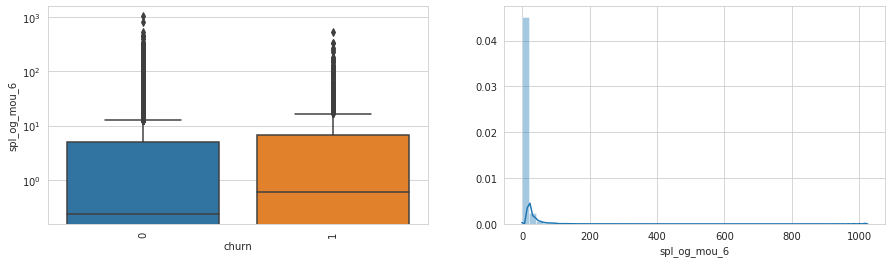

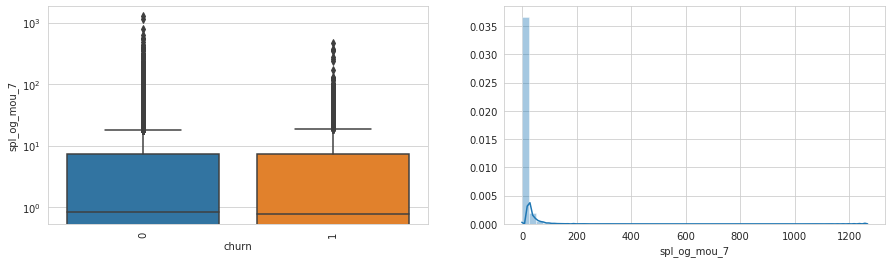

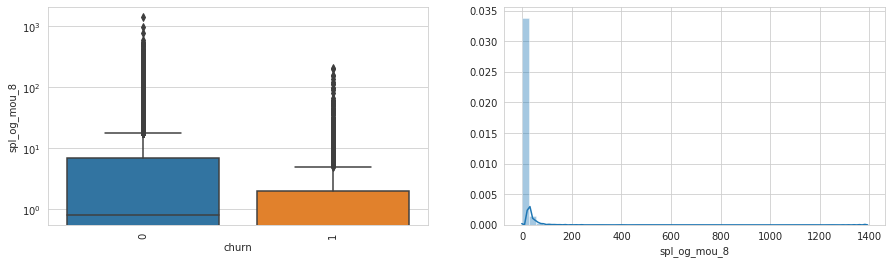

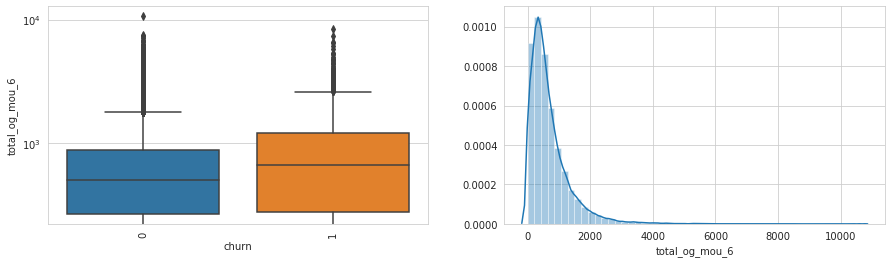

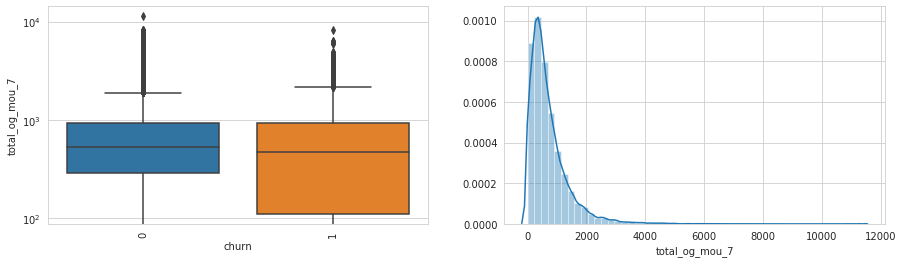

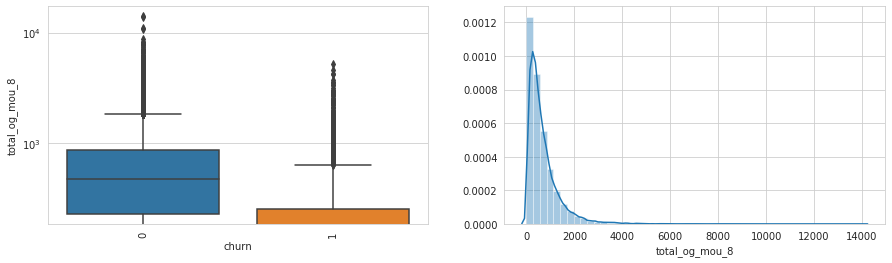

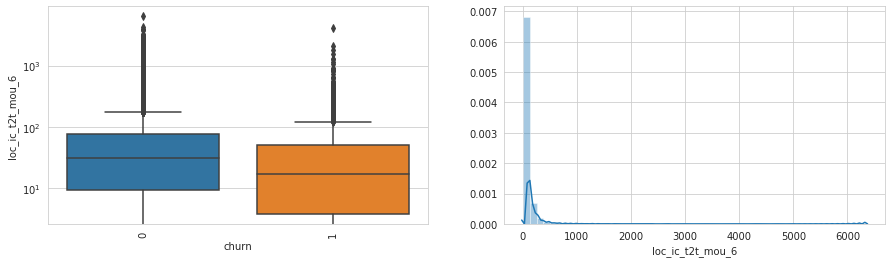

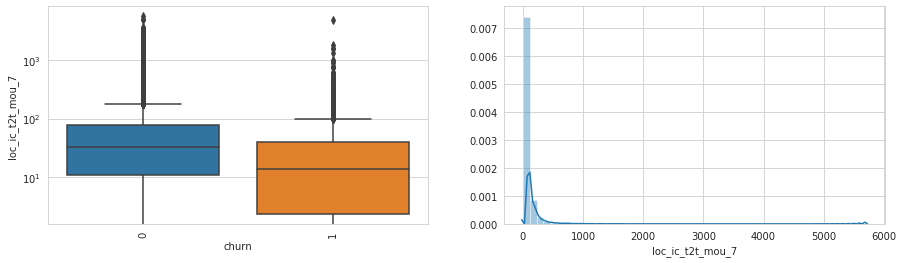

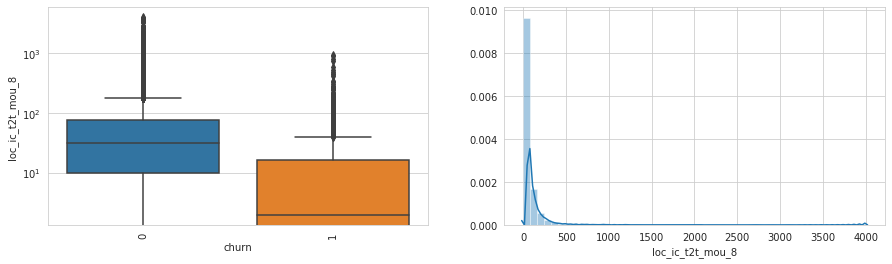

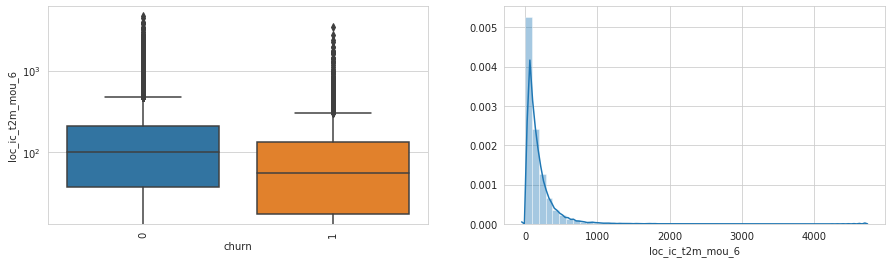

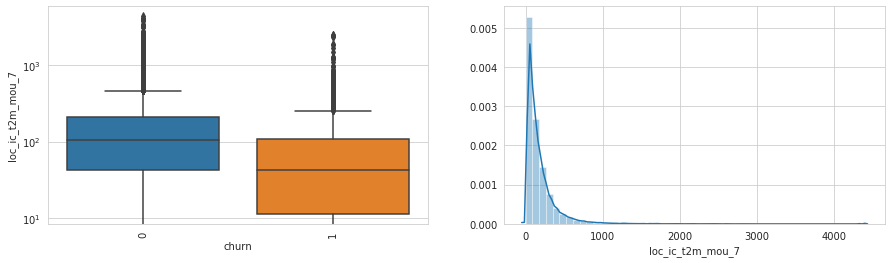

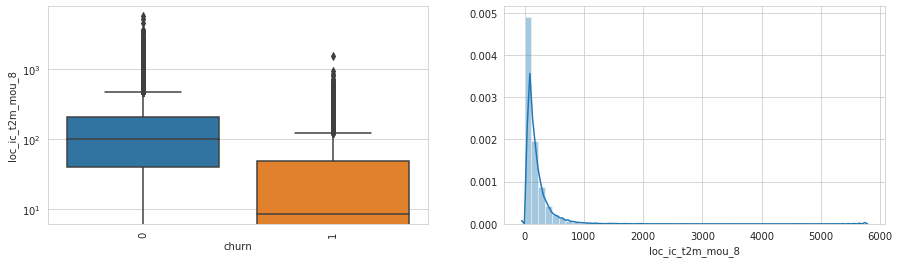

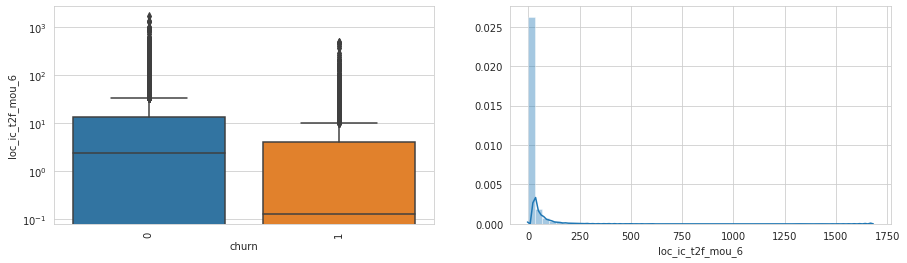

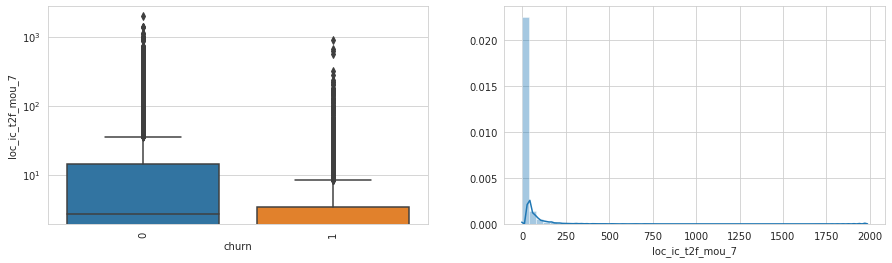

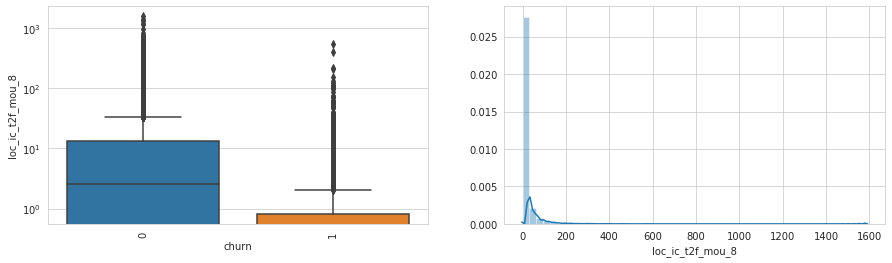

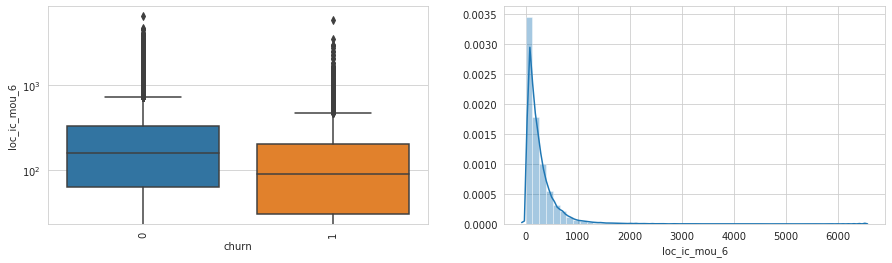

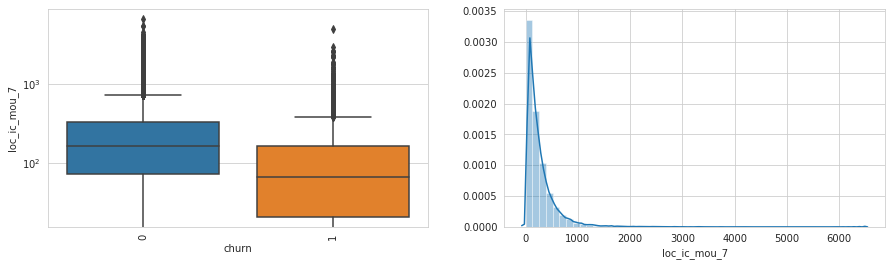

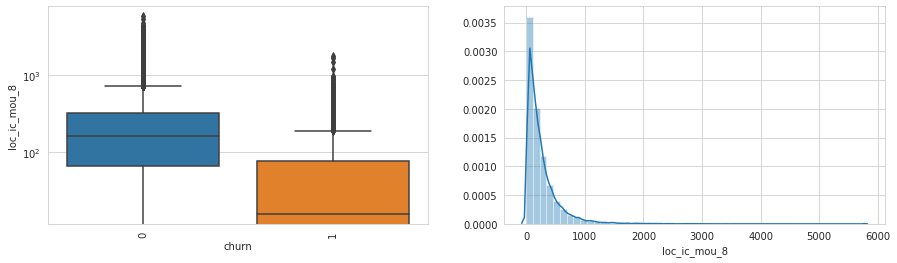

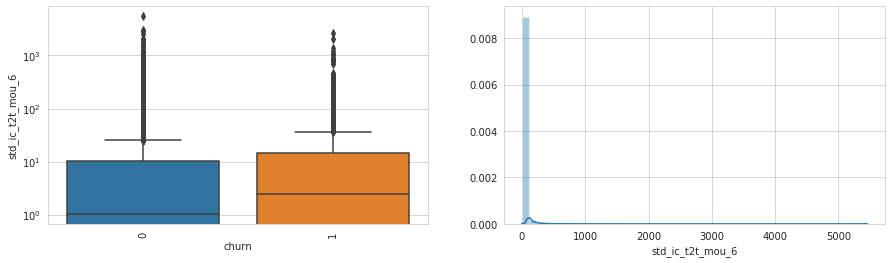

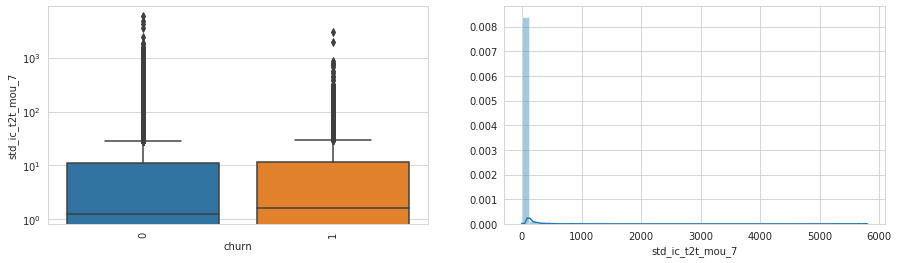

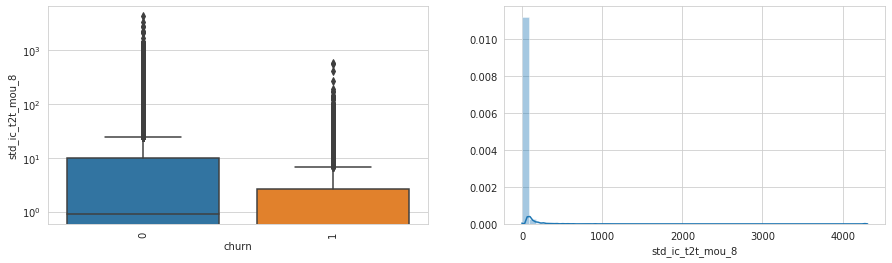

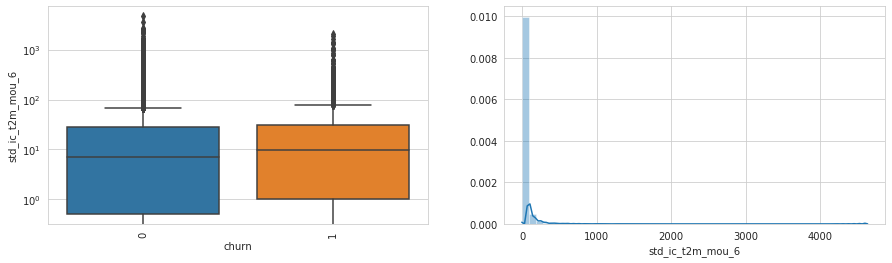

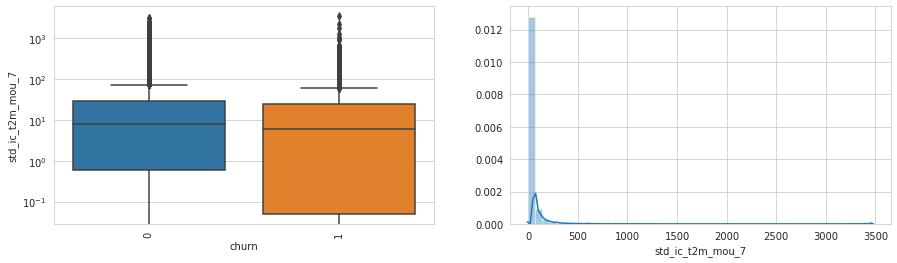

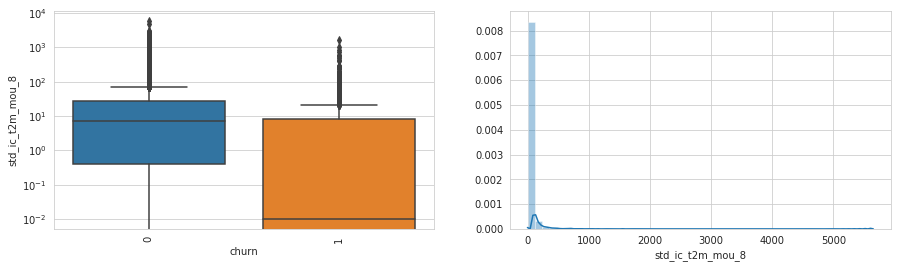

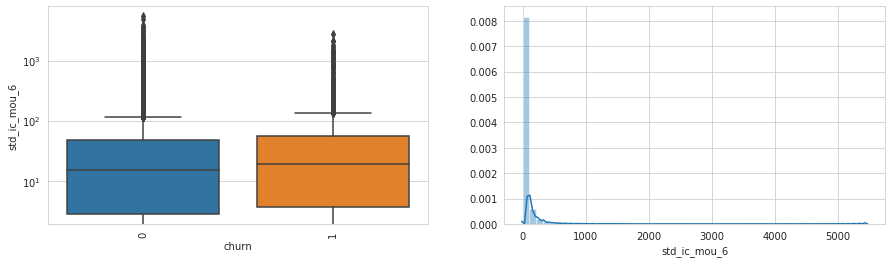

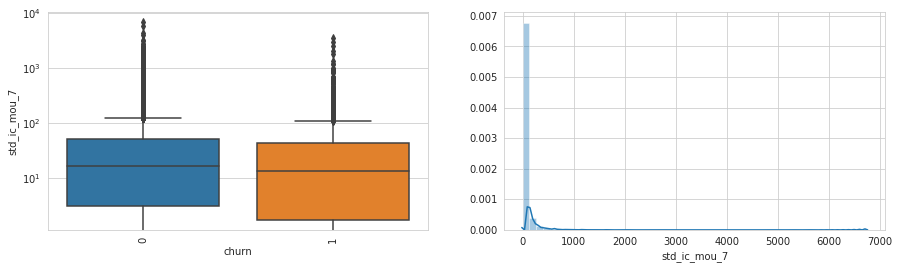

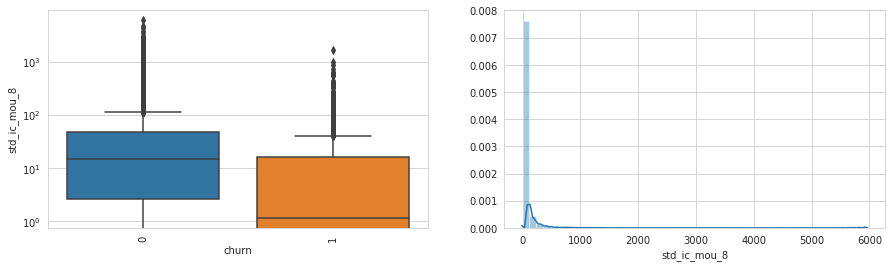

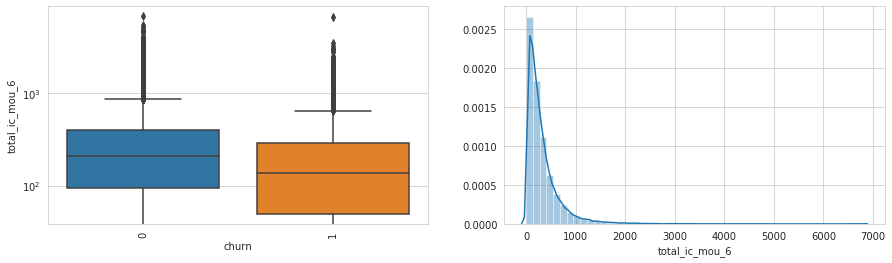

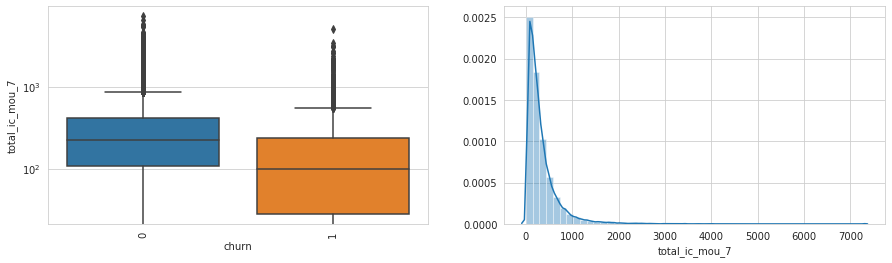

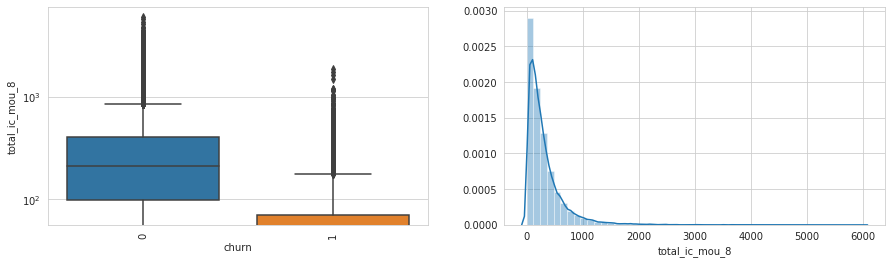

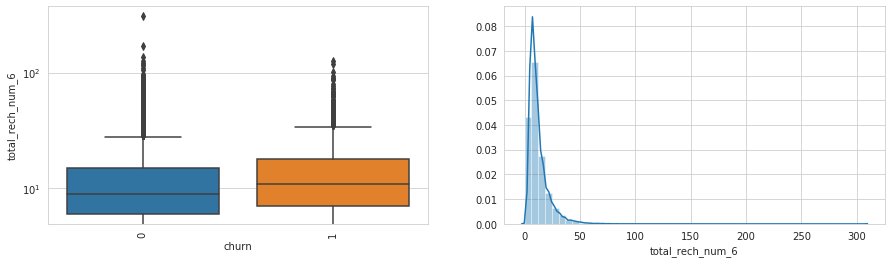

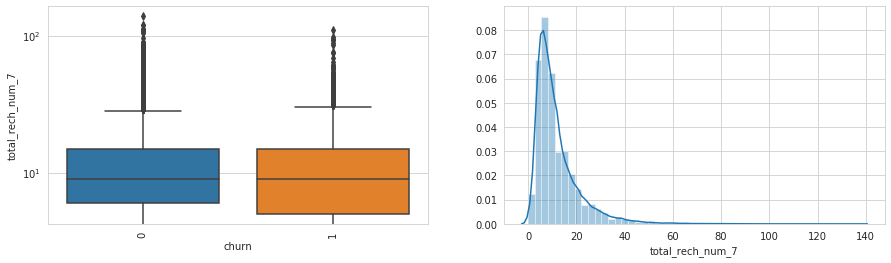

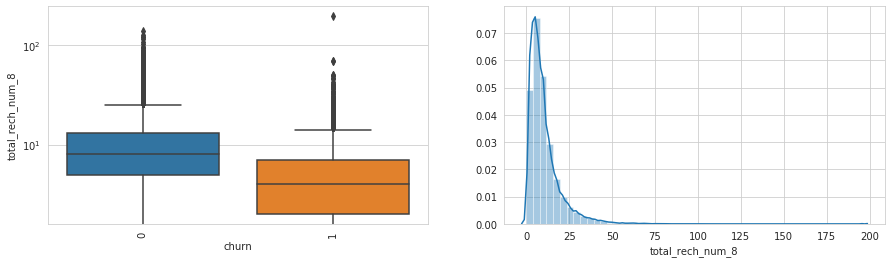

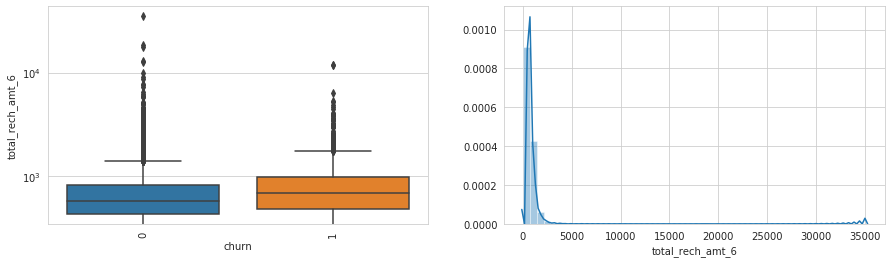

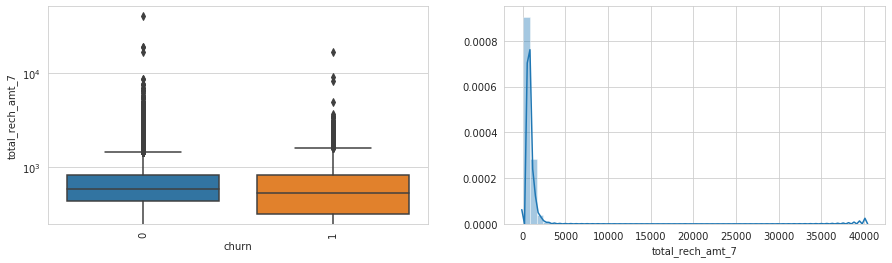

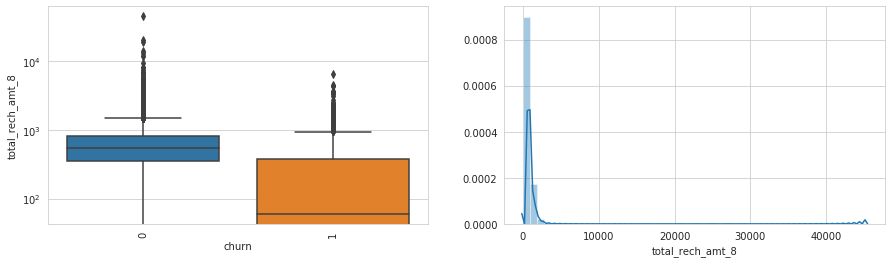

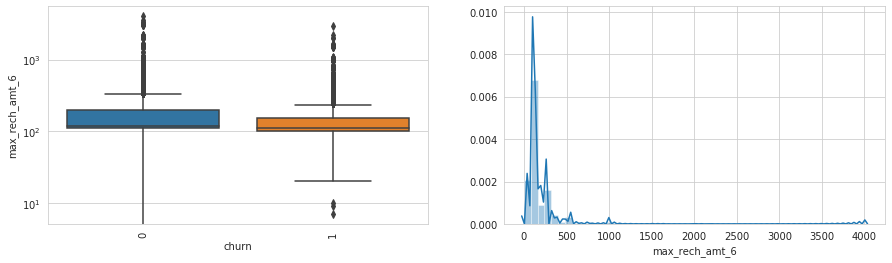

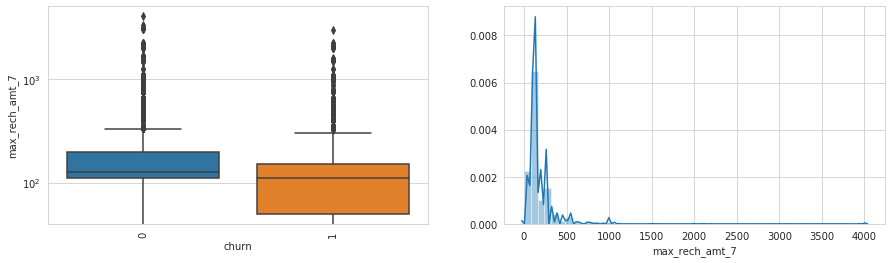

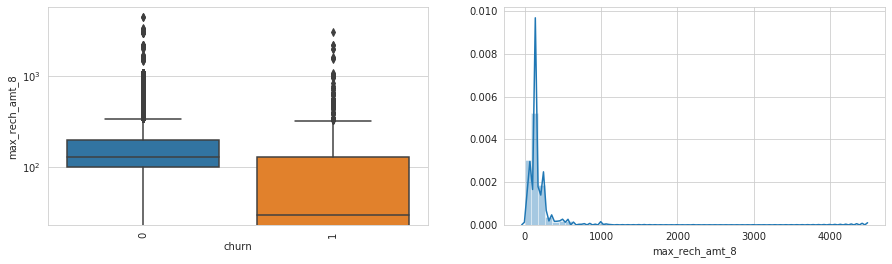

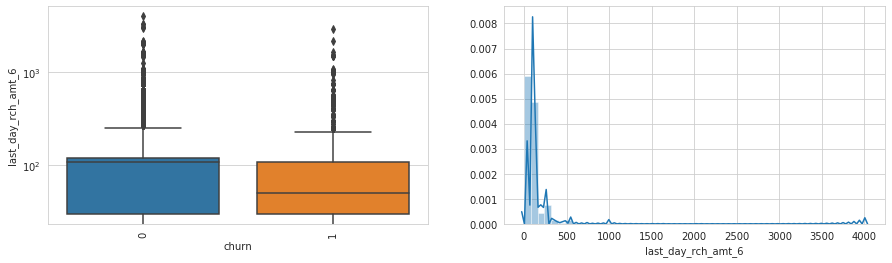

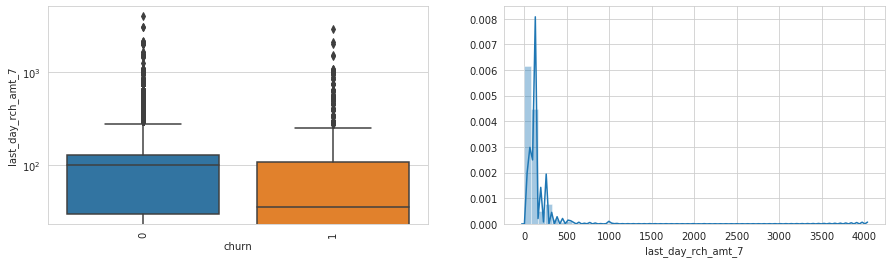

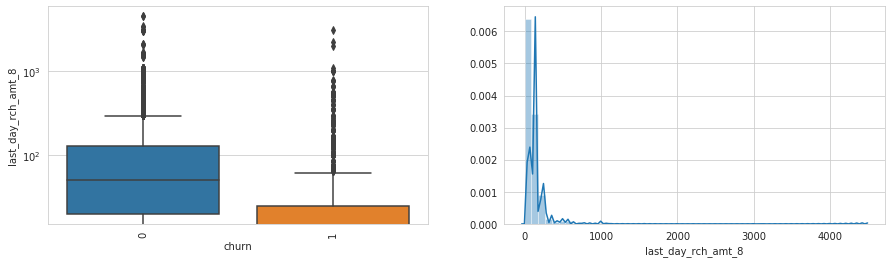

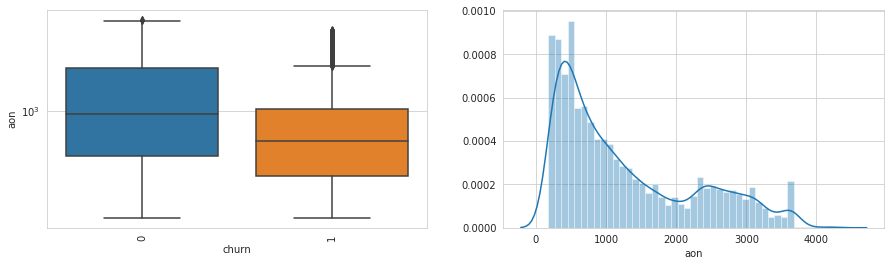

In [27]:
plot_num(col_list, True)

***Observed beahviour***
1. All the variables gradually decrease in volume for churn customers from June to August.
2. There are outliers in almost all variables which needs to be treated.
3. There is huge variation in ranges of values for the variables and hence normalization will be required.

In [28]:
null_percent(col_list)

loc_ic_mou_8          3.128857
loc_og_t2m_mou_8      3.128857
std_og_t2m_mou_8      3.128857
std_og_mou_8          3.128857
spl_og_mou_8          3.128857
loc_og_mou_8          3.128857
loc_ic_t2t_mou_8      3.128857
loc_ic_t2m_mou_8      3.128857
loc_ic_t2f_mou_8      3.128857
std_ic_t2t_mou_8      3.128857
std_ic_t2m_mou_8      3.128857
std_ic_mou_8          3.128857
std_og_t2t_mou_8      3.128857
loc_og_t2t_mou_8      3.128857
offnet_mou_8          3.128857
onnet_mou_8           3.128857
loc_og_t2m_mou_6      1.054071
loc_ic_mou_6          1.054071
std_og_t2m_mou_6      1.054071
std_og_mou_6          1.054071
spl_og_mou_6          1.054071
onnet_mou_6           1.054071
std_og_t2t_mou_6      1.054071
loc_ic_t2t_mou_6      1.054071
loc_og_mou_6          1.054071
loc_ic_t2m_mou_6      1.054071
loc_ic_t2f_mou_6      1.054071
offnet_mou_6          1.054071
std_ic_t2t_mou_6      1.054071
std_ic_mou_6          1.054071
std_ic_t2m_mou_6      1.054071
loc_og_t2t_mou_6      1.054071
offnet_m

Null values are caped at only 3.2% and hence they can be imputed.

In [29]:
# impute the null values using Iterative Imputer
impute(col_list)

aon                   0.0
std_og_mou_7          0.0
std_og_t2t_mou_7      0.0
std_og_t2t_mou_8      0.0
std_og_t2m_mou_6      0.0
std_og_t2m_mou_7      0.0
std_og_t2m_mou_8      0.0
std_og_mou_6          0.0
std_og_mou_8          0.0
loc_og_mou_8          0.0
spl_og_mou_6          0.0
spl_og_mou_7          0.0
spl_og_mou_8          0.0
total_og_mou_6        0.0
total_og_mou_7        0.0
total_og_mou_8        0.0
std_og_t2t_mou_6      0.0
loc_og_mou_7          0.0
last_day_rch_amt_8    0.0
offnet_mou_7          0.0
arpu_7                0.0
arpu_8                0.0
onnet_mou_6           0.0
onnet_mou_7           0.0
onnet_mou_8           0.0
offnet_mou_6          0.0
offnet_mou_8          0.0
loc_og_mou_6          0.0
loc_og_t2t_mou_6      0.0
loc_og_t2t_mou_7      0.0
loc_og_t2t_mou_8      0.0
loc_og_t2m_mou_6      0.0
loc_og_t2m_mou_7      0.0
loc_og_t2m_mou_8      0.0
loc_ic_t2t_mou_6      0.0
loc_ic_t2t_mou_7      0.0
loc_ic_t2t_mou_8      0.0
total_rech_amt_6      0.0
total_ic_mou

Null percentage is reduced to zero after imputation.

In [30]:
# check skewness 
skewness(col_list)

std_ic_t2t_mou_7      29.967445
std_ic_t2t_mou_6      25.370428
std_ic_t2t_mou_8      23.120400
arpu_7                19.343462
spl_og_mou_8          18.829299
total_rech_amt_8      18.597825
spl_og_mou_7          17.769632
total_rech_amt_7      17.739059
std_ic_t2m_mou_8      16.966934
spl_og_mou_6          16.102560
arpu_8                16.085306
total_rech_amt_6      14.610165
std_ic_t2m_mou_6      13.720659
loc_og_t2t_mou_8      13.378524
arpu_6                13.343765
std_ic_mou_7          13.090879
std_ic_mou_8          12.628792
std_ic_t2m_mou_7      12.093149
std_ic_mou_6          11.752122
loc_ic_t2t_mou_7      11.674132
loc_ic_t2t_mou_6      11.442015
loc_ic_t2f_mou_7      11.124941
loc_ic_t2f_mou_8      10.806646
loc_ic_t2f_mou_6      10.473607
loc_ic_t2t_mou_8      10.324574
loc_og_t2t_mou_7      10.201020
loc_og_t2t_mou_6       9.092020
last_day_rch_amt_8     7.891323
std_og_t2m_mou_8       6.903548
last_day_rch_amt_6     6.764793
max_rech_amt_8         6.298709
last_day

Data is highly skewed for most of the variables which is not expected by algorithms.

In [31]:
# transform data using Quantile Transformer to achieve normal distribution
transform(col_list)

arpu_8                0.025877
arpu_6                0.005638
arpu_7                0.003365
spl_og_mou_6         -0.047365
aon                  -0.049175
spl_og_mou_8         -0.120164
total_rech_num_6     -0.190652
spl_og_mou_7         -0.204359
std_ic_t2t_mou_8     -0.296996
std_ic_t2t_mou_6     -0.319955
total_rech_num_7     -0.355843
std_ic_t2t_mou_7     -0.381170
std_og_t2t_mou_8     -0.415206
std_og_t2t_mou_7     -0.527990
std_og_t2t_mou_6     -0.530774
loc_ic_t2f_mou_6     -0.607326
loc_ic_t2f_mou_8     -0.691315
loc_ic_t2f_mou_7     -0.697637
std_og_t2m_mou_8     -0.904666
last_day_rch_amt_8   -0.922321
std_ic_t2m_mou_8     -0.951924
offnet_mou_6         -1.000483
offnet_mou_7         -1.076066
total_rech_amt_6     -1.106451
max_rech_amt_6       -1.122674
std_ic_t2m_mou_6     -1.126371
std_og_t2m_mou_7     -1.147883
std_ic_t2m_mou_7     -1.149922
std_og_t2m_mou_6     -1.180216
total_rech_amt_7     -1.292376
max_rech_amt_7       -1.300616
std_og_mou_8         -1.323063
total_re

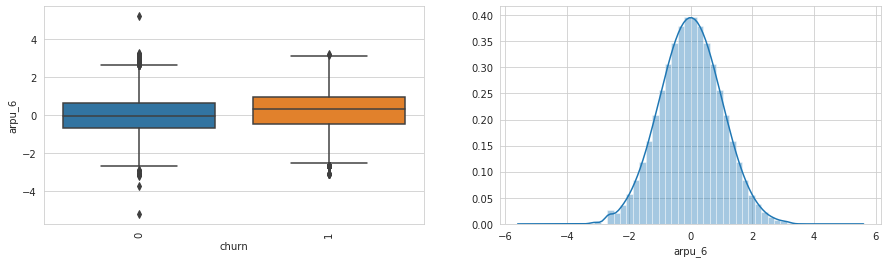

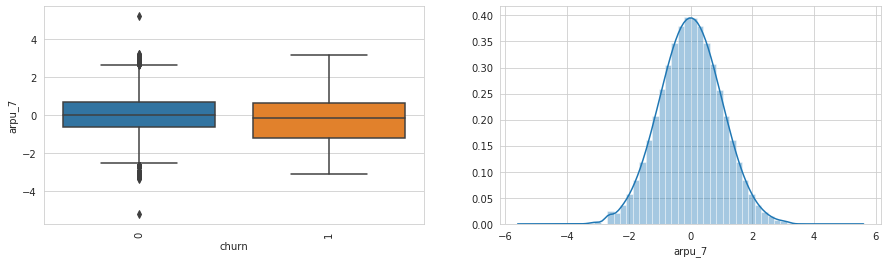

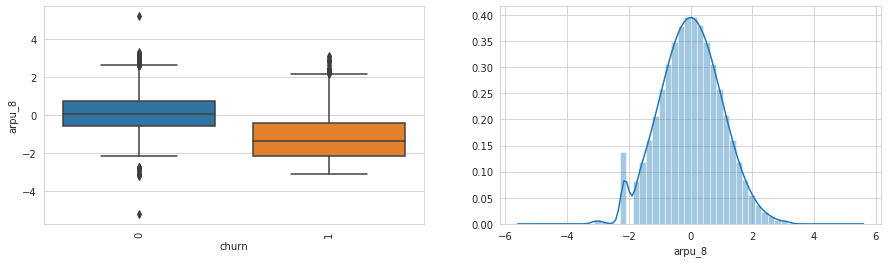

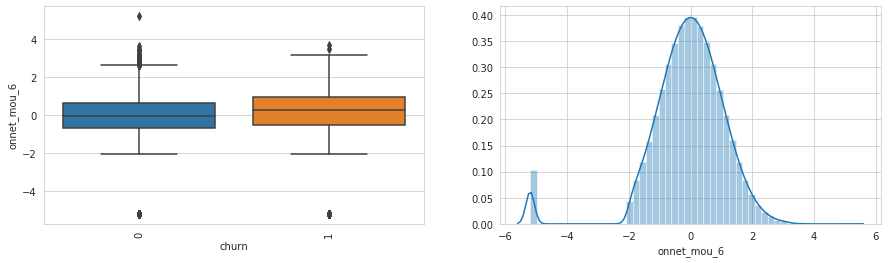

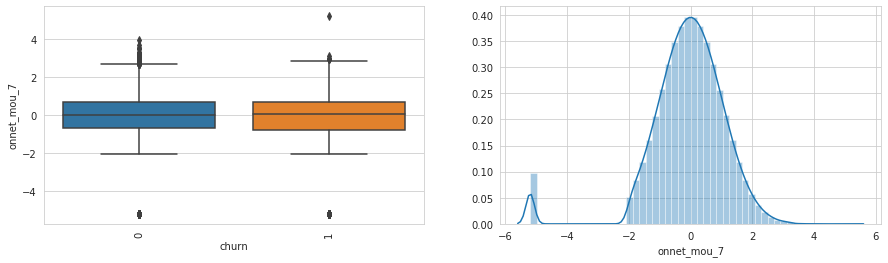

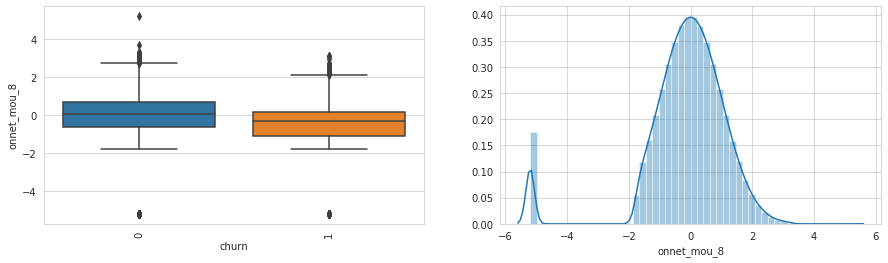

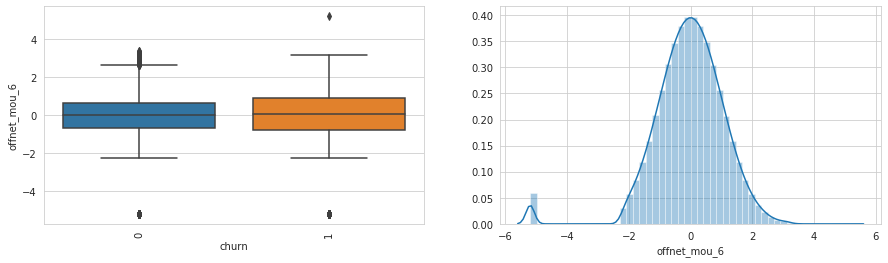

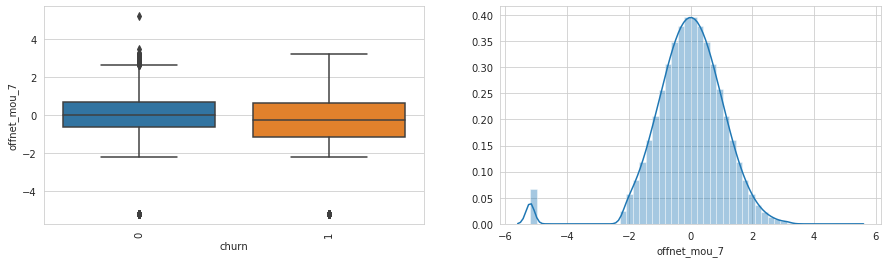

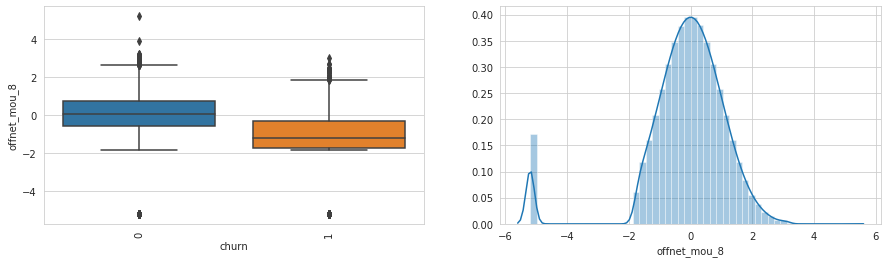

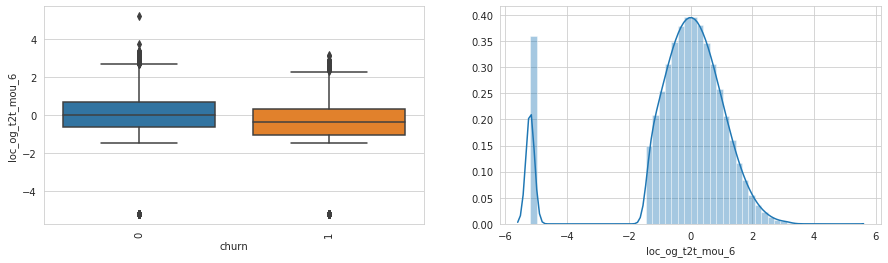

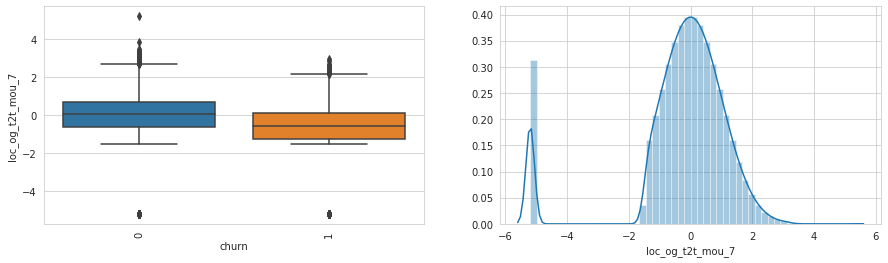

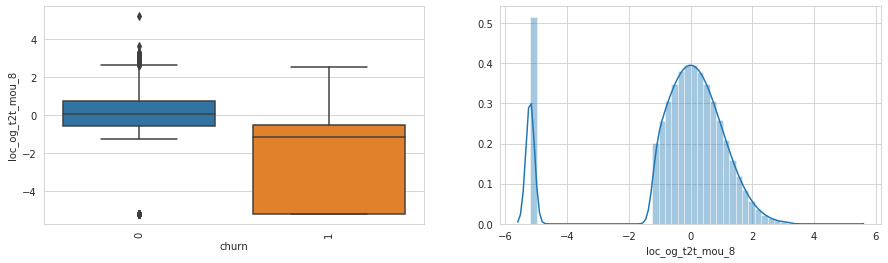

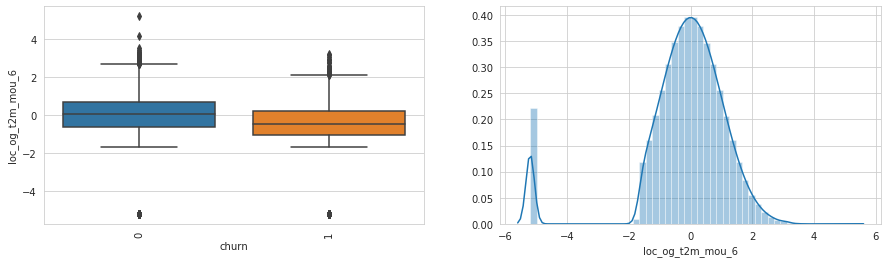

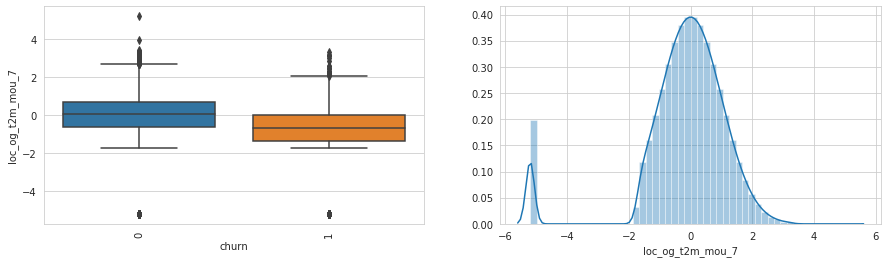

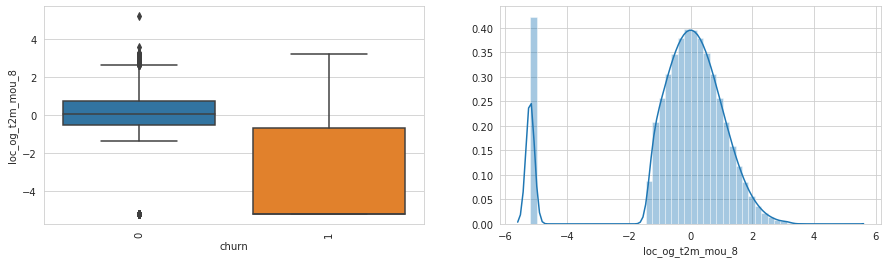

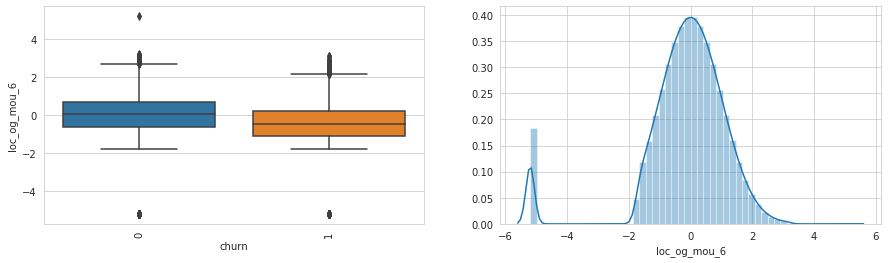

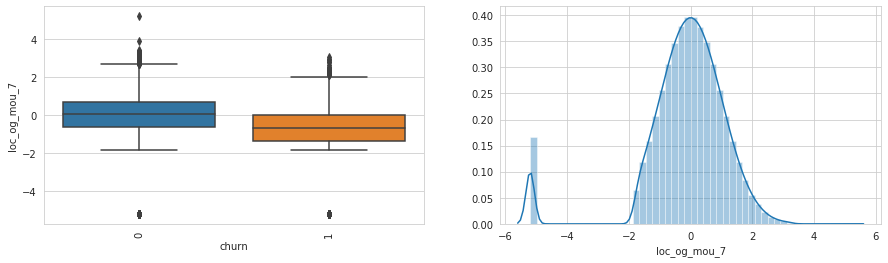

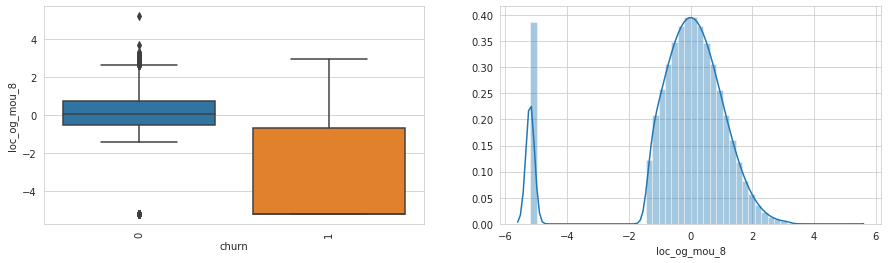

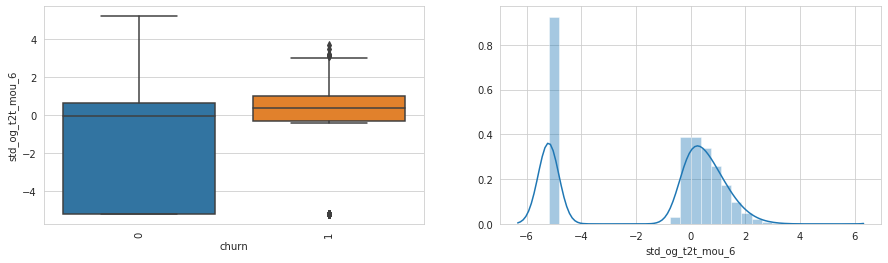

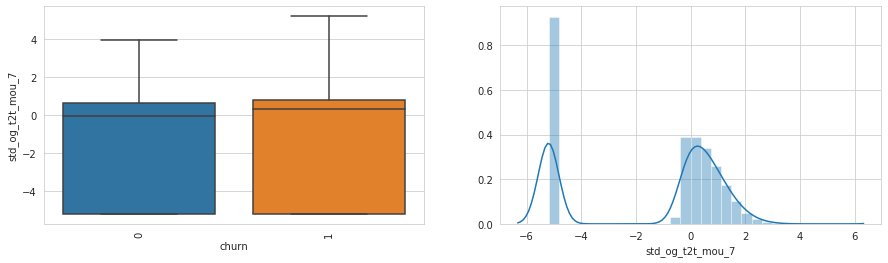

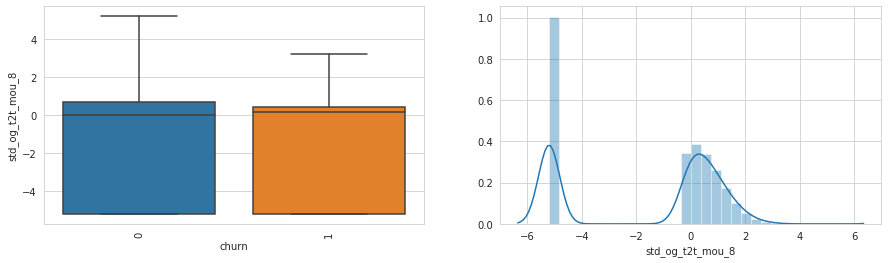

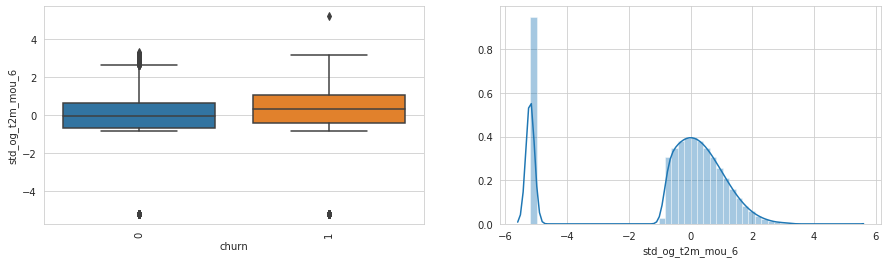

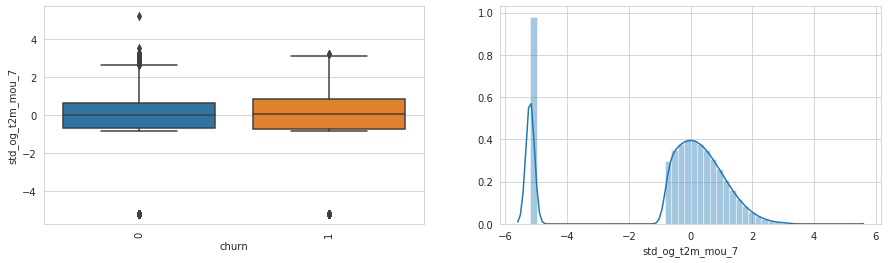

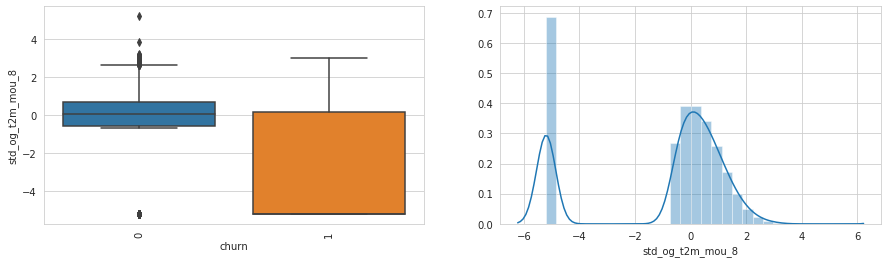

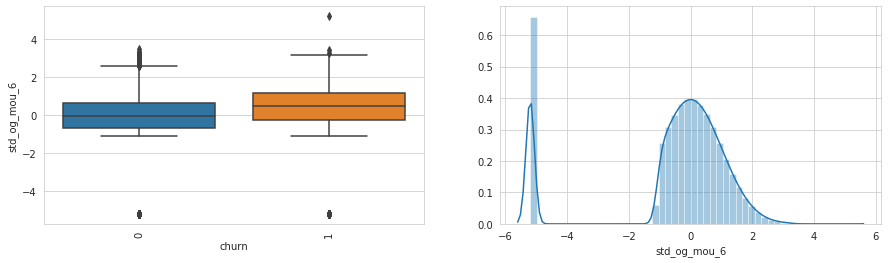

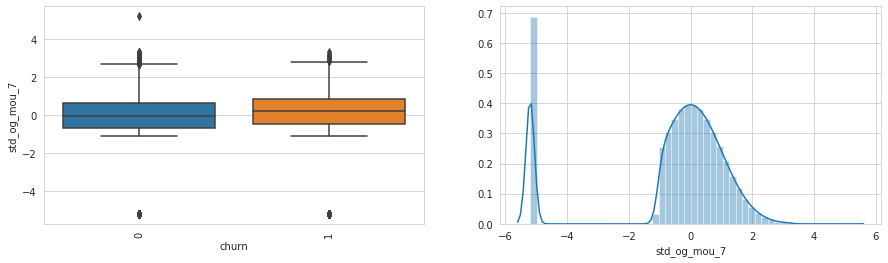

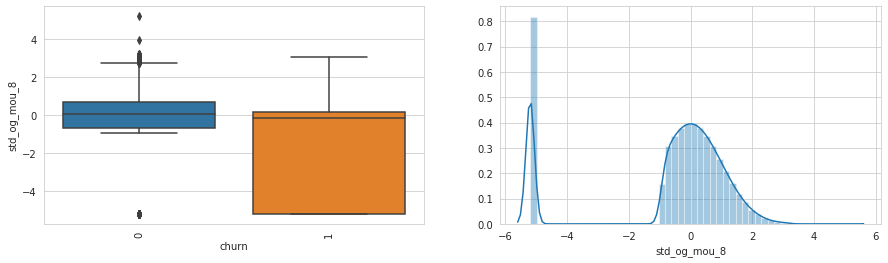

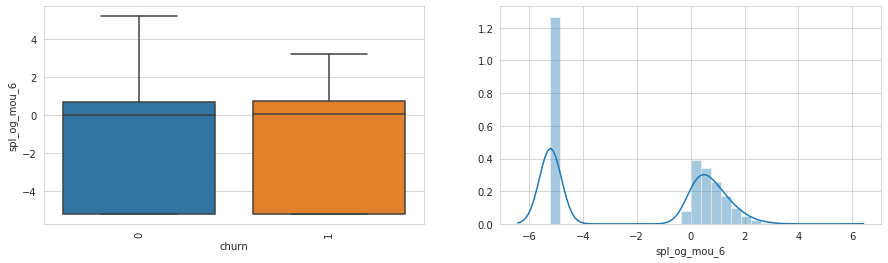

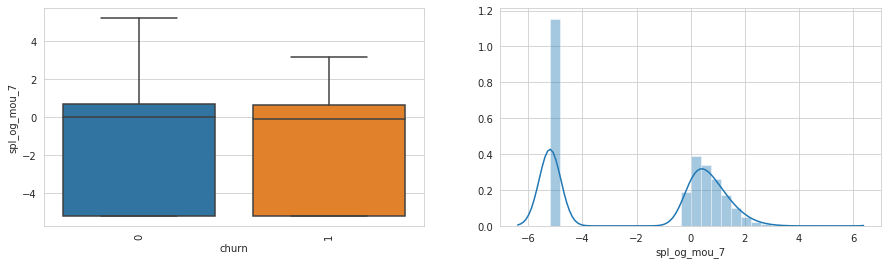

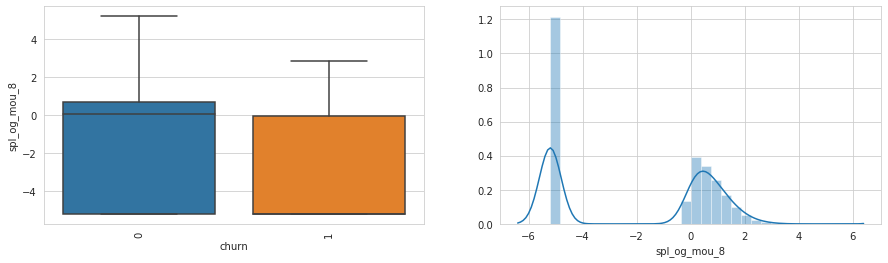

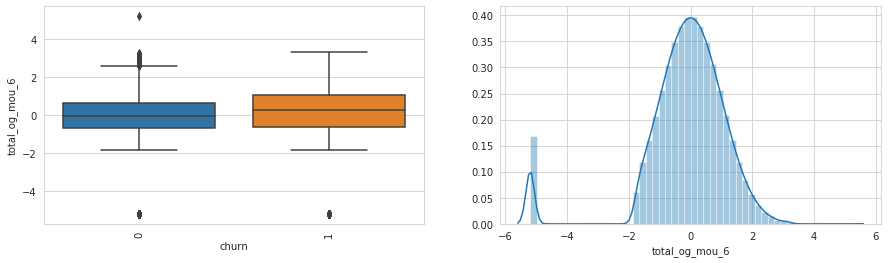

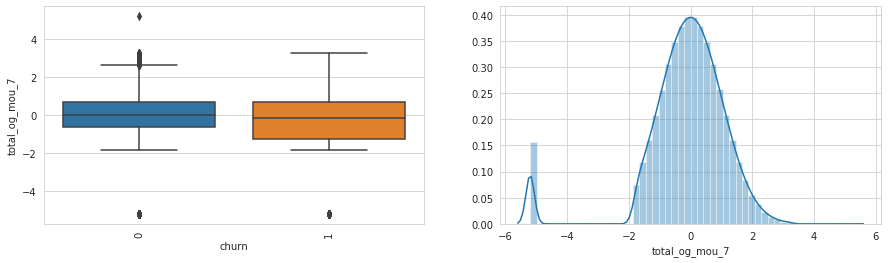

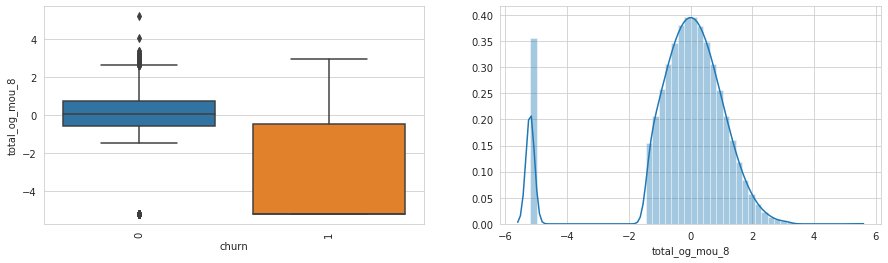

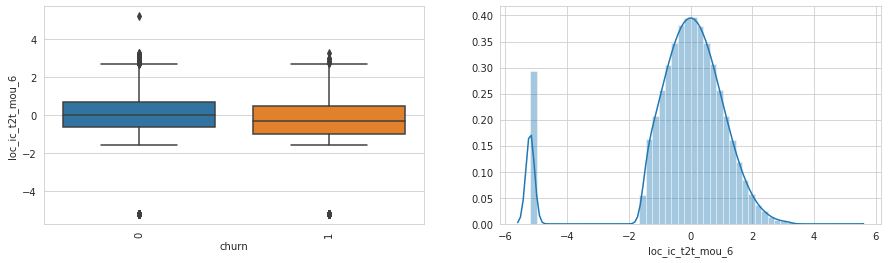

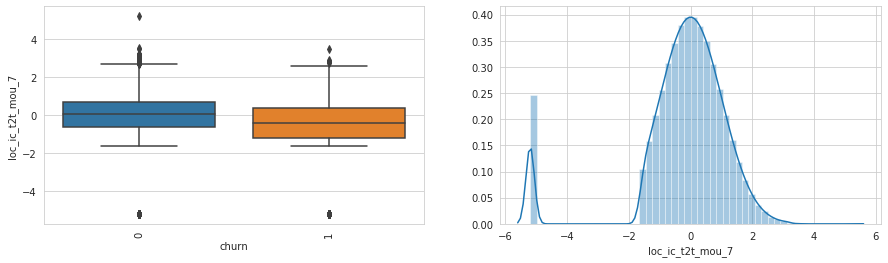

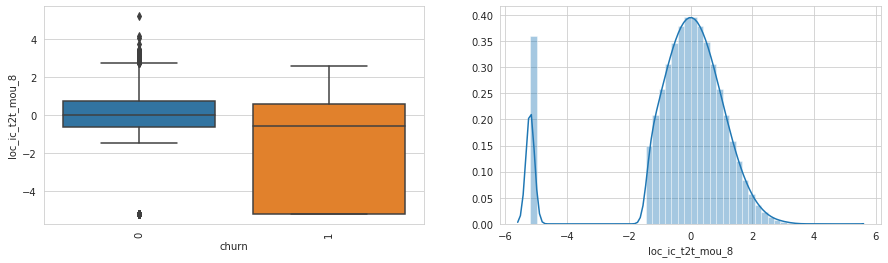

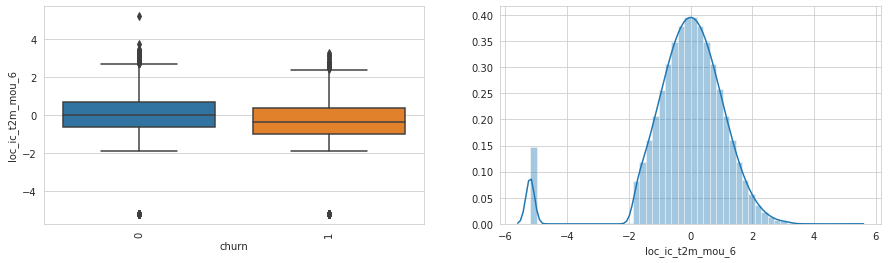

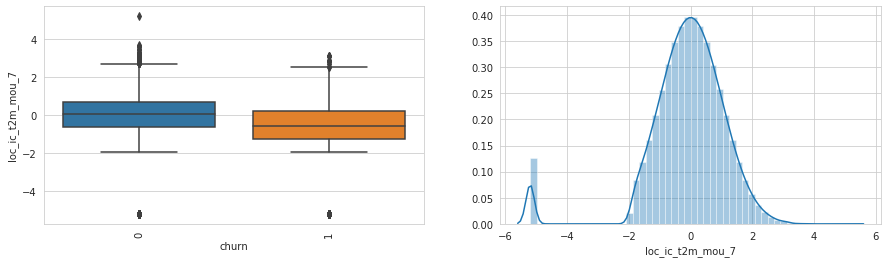

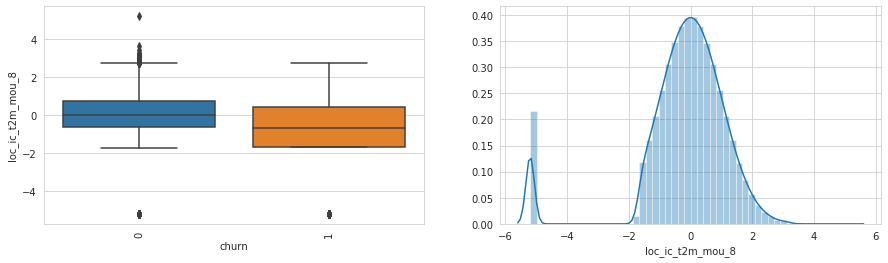

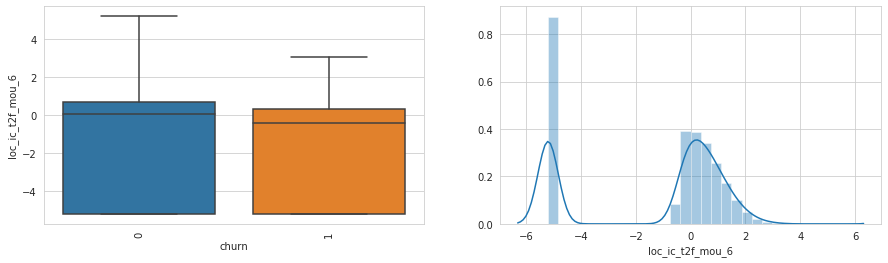

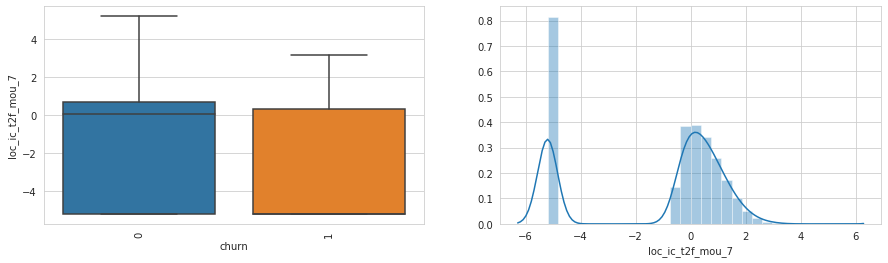

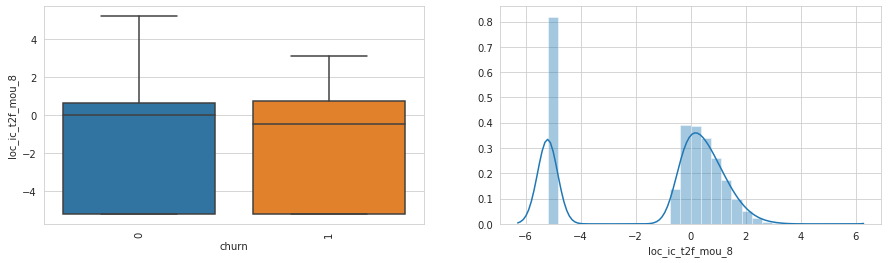

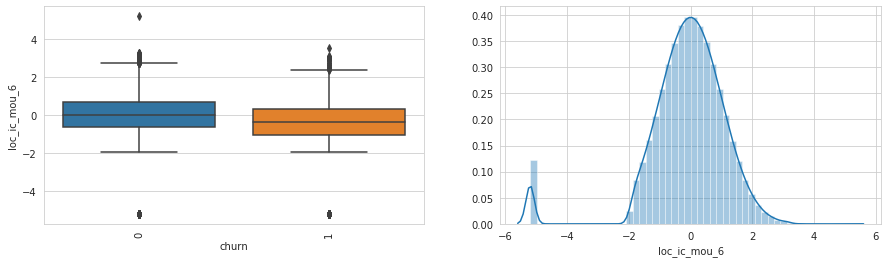

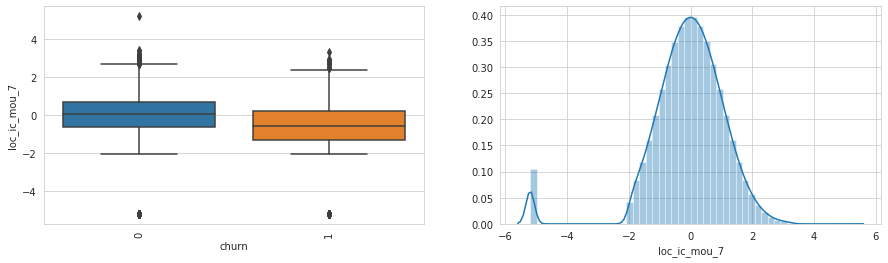

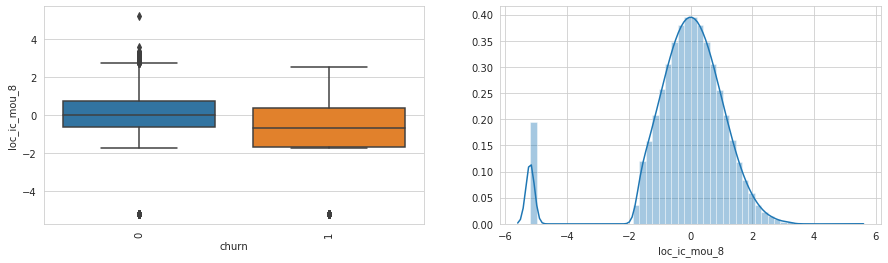

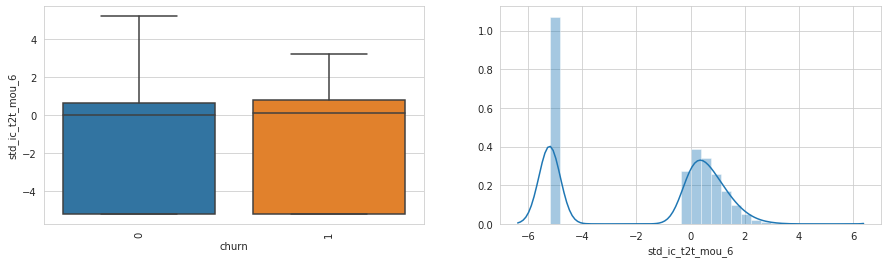

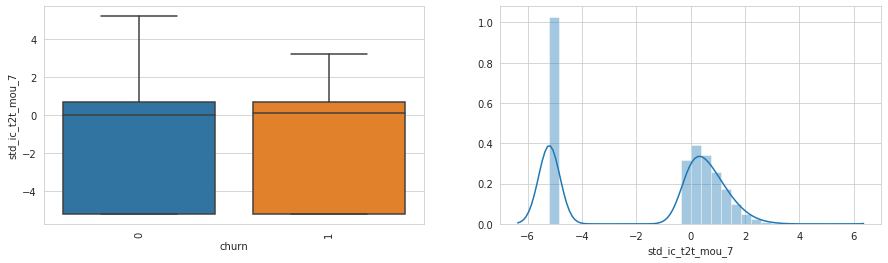

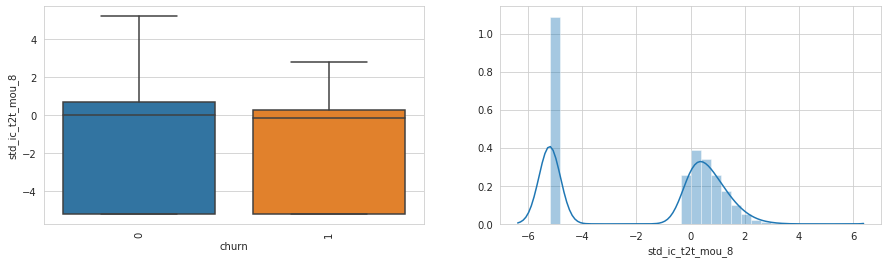

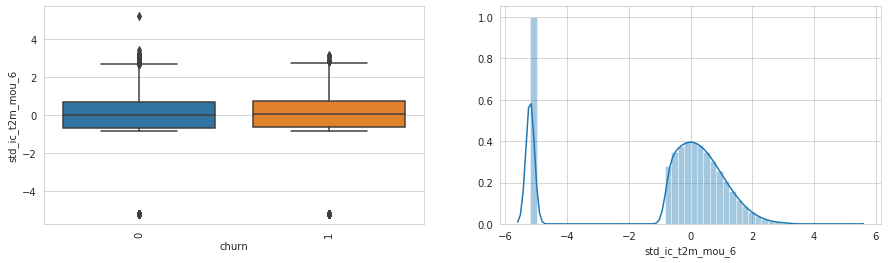

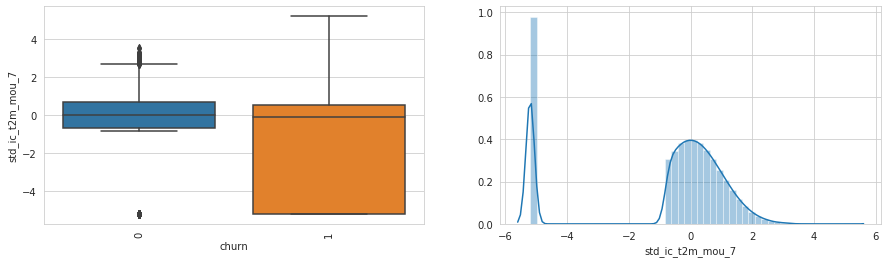

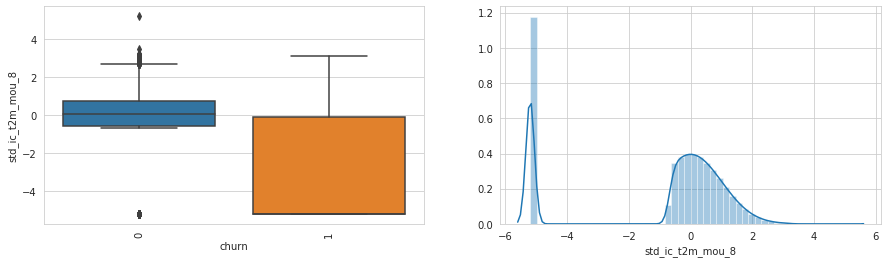

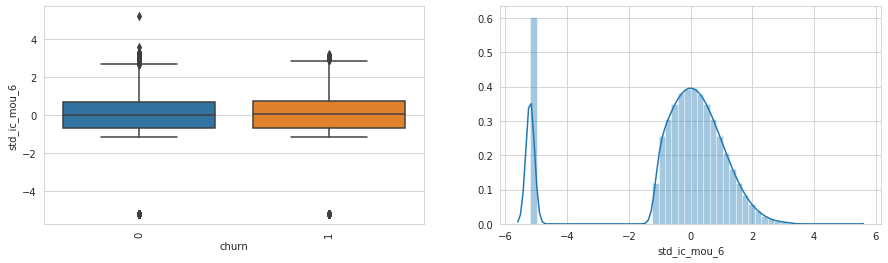

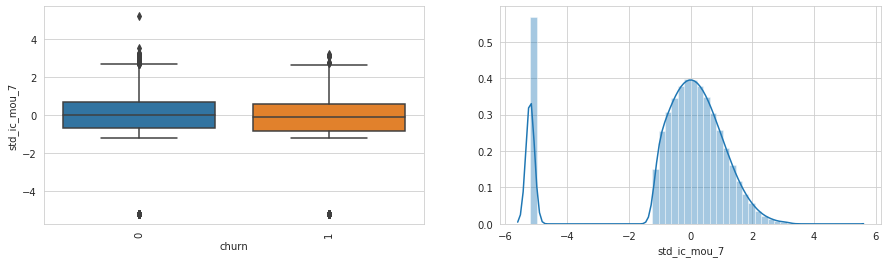

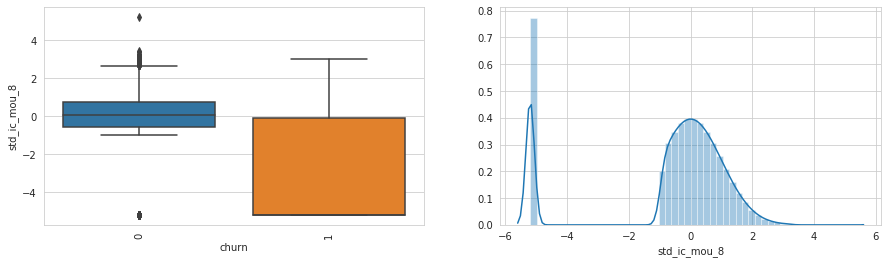

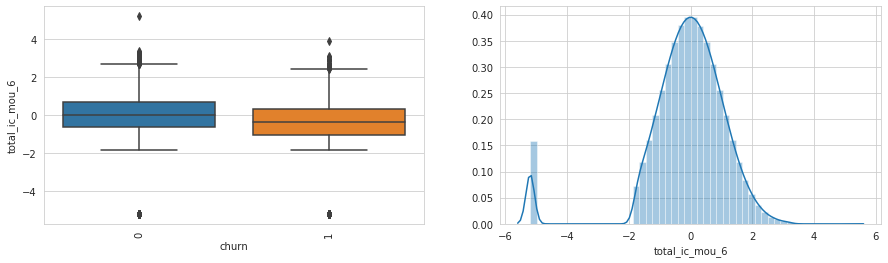

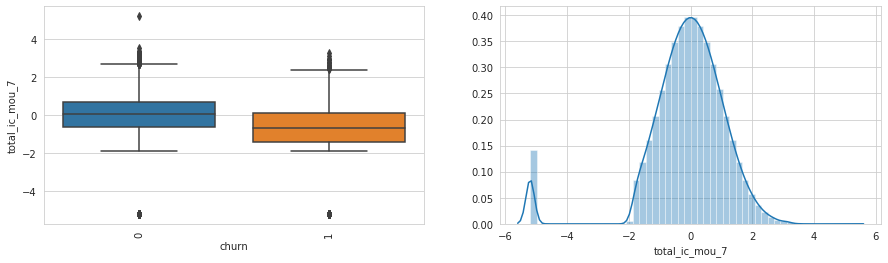

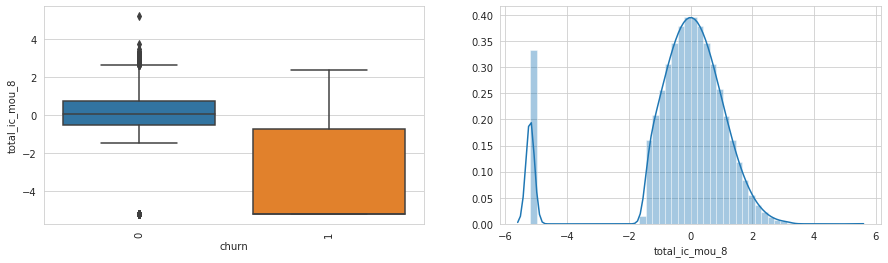

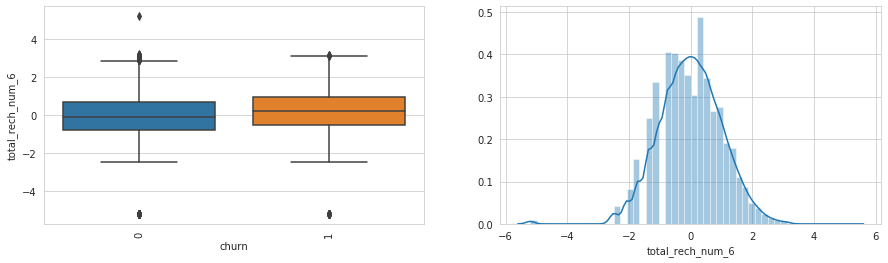

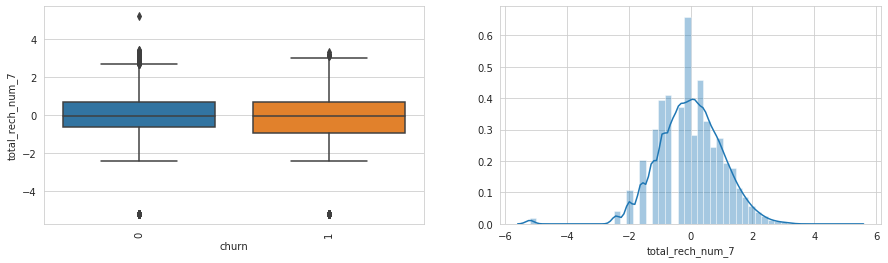

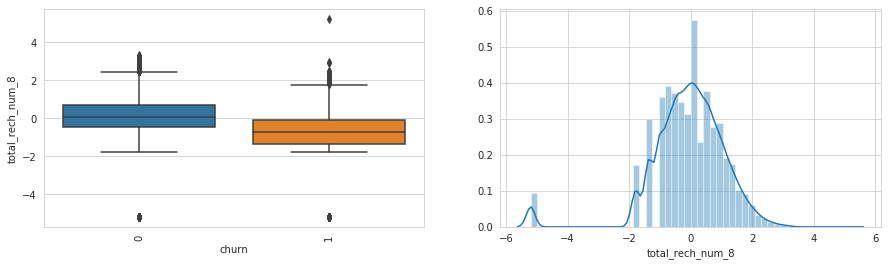

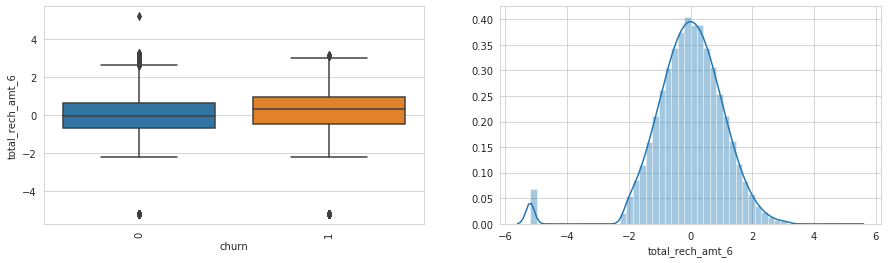

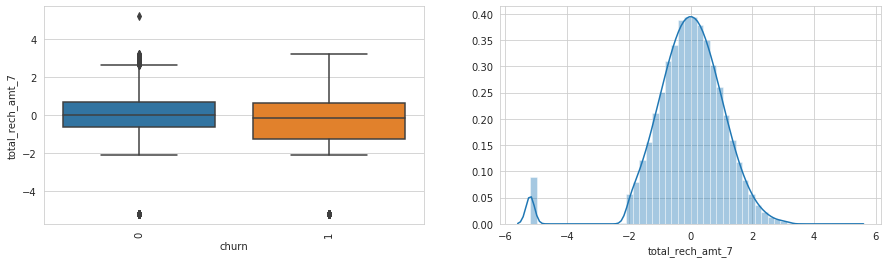

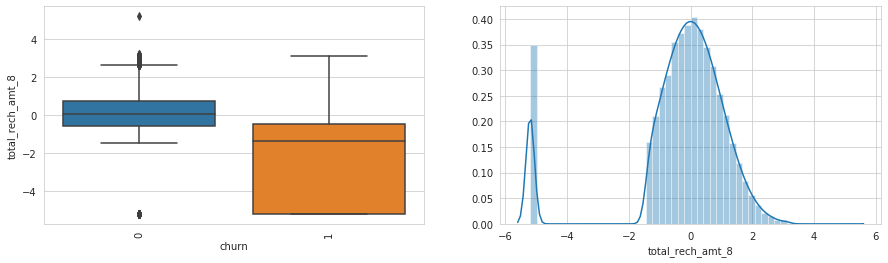

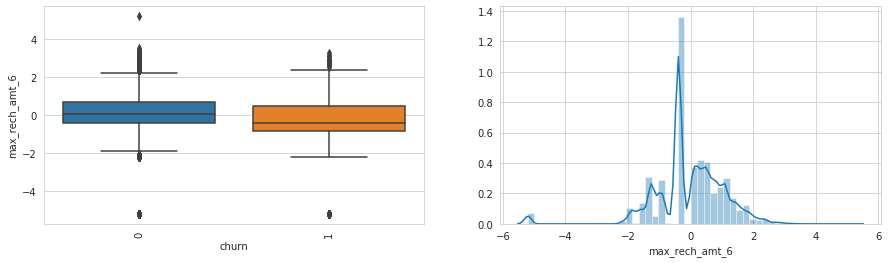

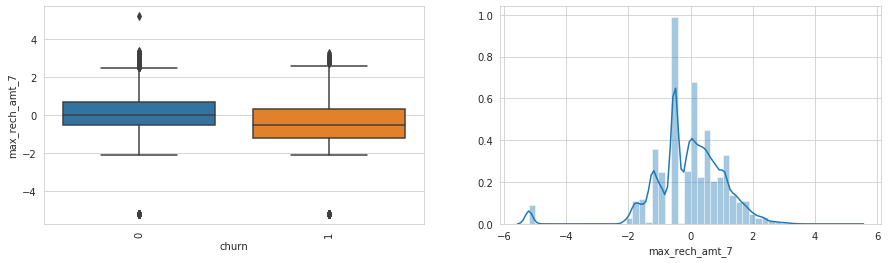

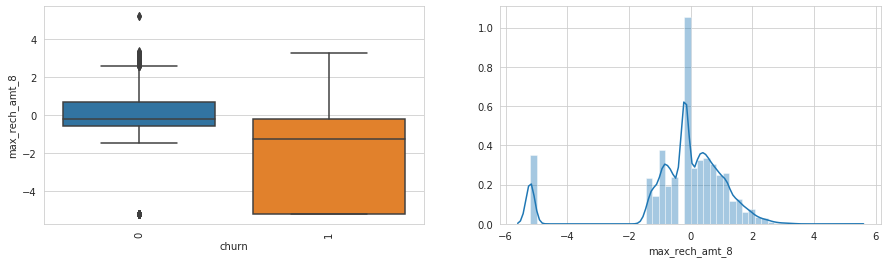

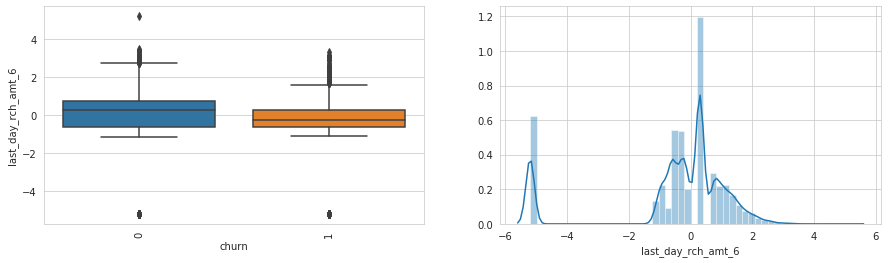

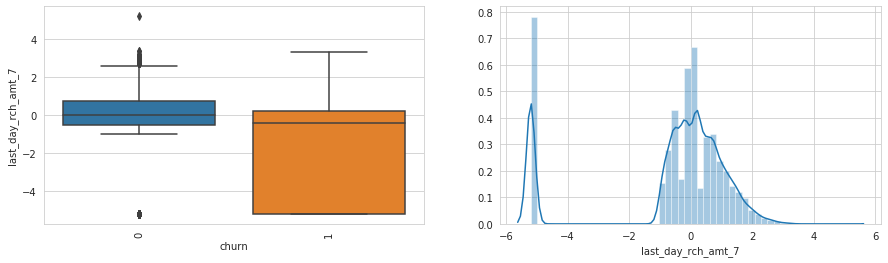

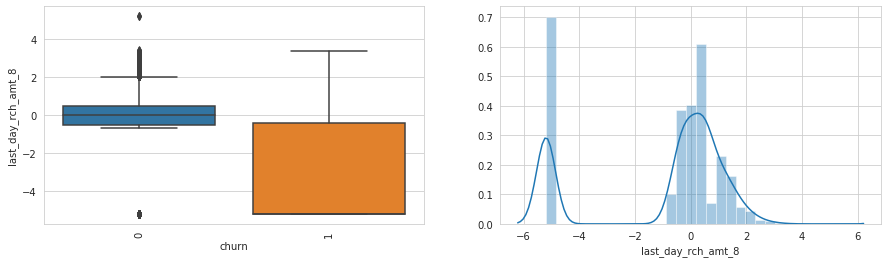

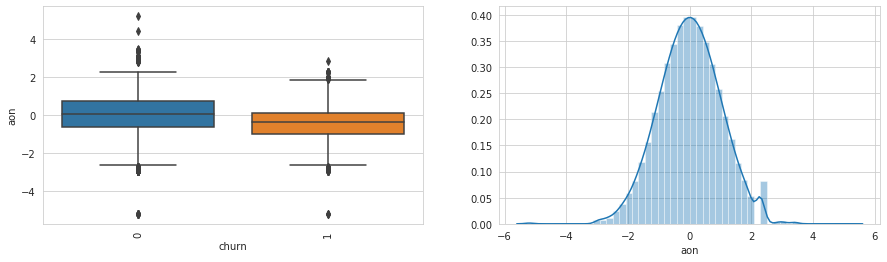

In [32]:
plot_num(col_list, False)

As we can see, we were able to achieve normal distribution, normalize range of variables and handle outliers using transformer.

***Handling date variables***

In [33]:
col_list = ['date_of_last_rech_6','date_of_last_rech_7','date_of_last_rech_8','date_of_last_rech_data_6',
            'date_of_last_rech_data_7','date_of_last_rech_data_8']

In [34]:
len(col_list)

6

In [35]:
# check null percentage
null_percent(col_list)

date_of_last_rech_data_6    62.016745
date_of_last_rech_data_7    61.132793
date_of_last_rech_data_8    60.835918
date_of_last_rech_8          1.981387
date_of_last_rech_7          0.380266
date_of_last_rech_6          0.206811
dtype: float64

There are lot of missing values for these variables but missing values may indicate churn behaviour.

In [36]:
max_count(col_list)

date_of_last_rech_6         (6/30/2014, 29.070349244471128)
date_of_last_rech_7         (7/31/2014, 26.418492945061544)
date_of_last_rech_8         (8/31/2014, 22.232229227125654)
date_of_last_rech_data_6    (6/30/2014, 3.0921645151606123)
date_of_last_rech_data_7    (7/31/2014, 2.9720804563194236)
date_of_last_rech_data_8     (8/31/2014, 3.349010974348711)
dtype: object

Majority of people prefer recharging at the last date of the month.

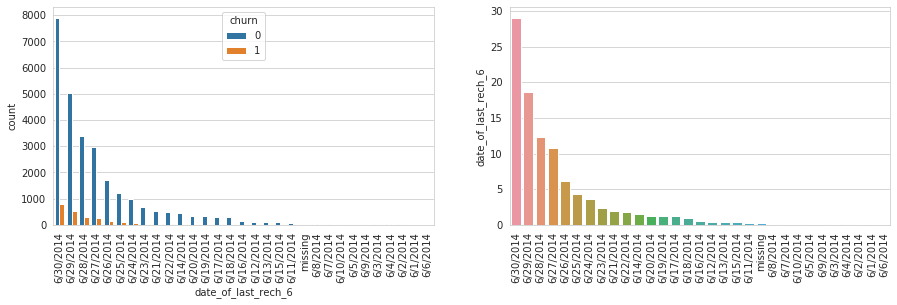

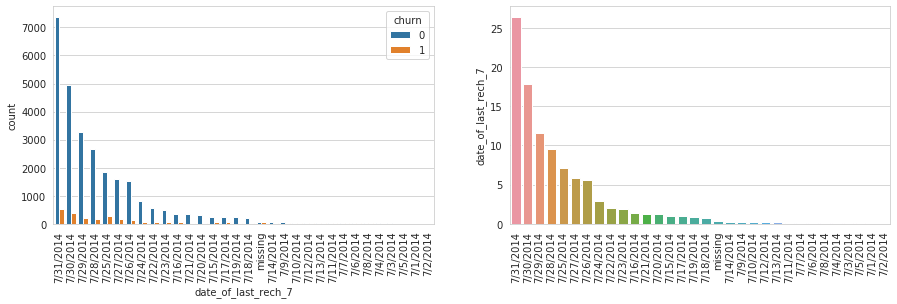

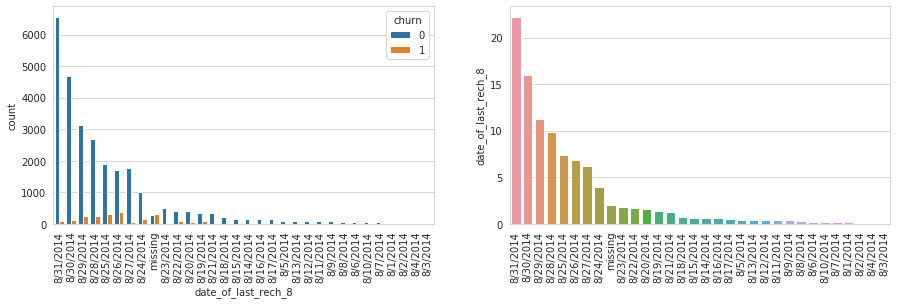

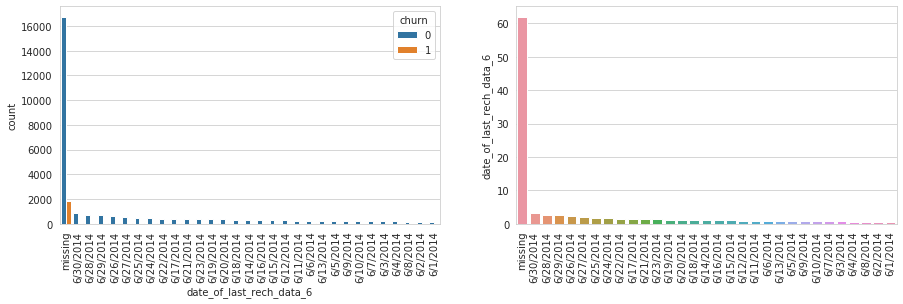

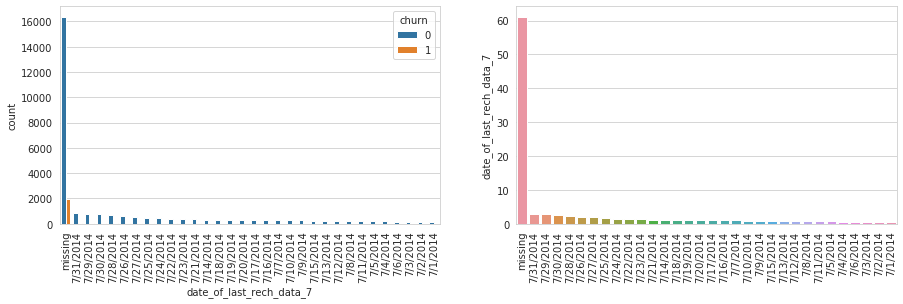

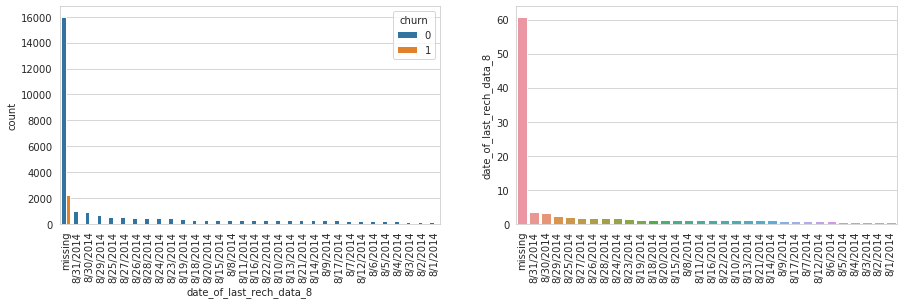

In [37]:
plot_cat(col_list)

There are lots of dates in the columns but most of them have very less count so we will mask dates having less than 60 percentile count with others.

In [38]:
for col in col_list:
    series = high_valued[col].value_counts(normalize=True)*100
    mask = (series/series.sum() * 100).lt(series.quantile(0.6))
    high_valued[col] = np.where(high_valued[col].isin(series[mask].index),'other',high_valued[col])

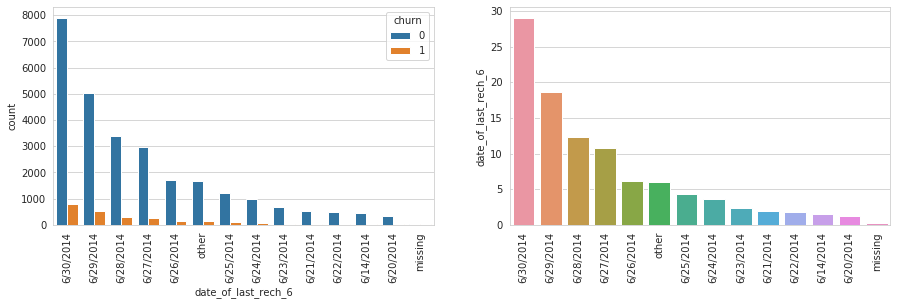

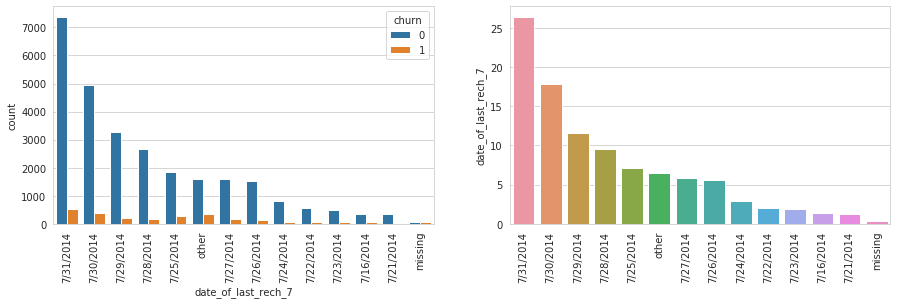

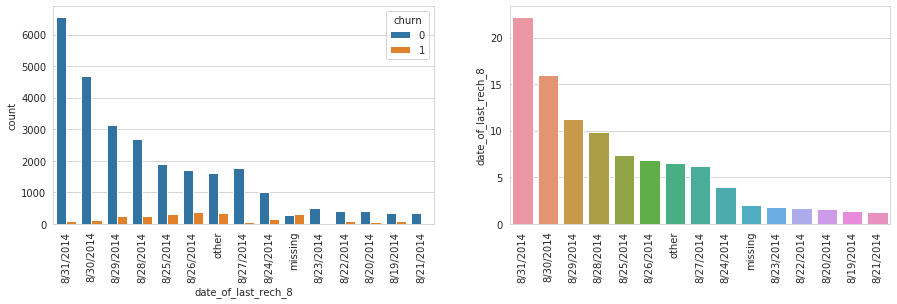

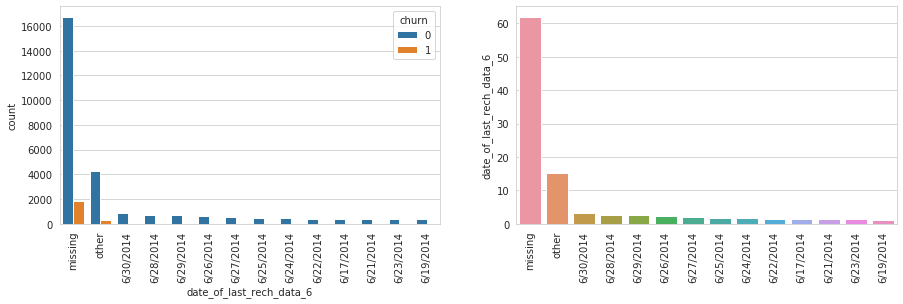

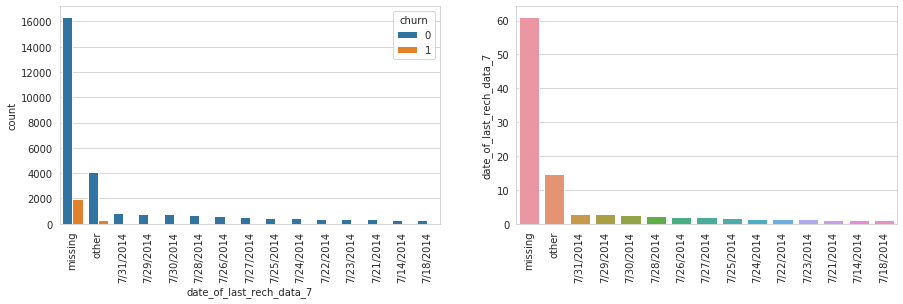

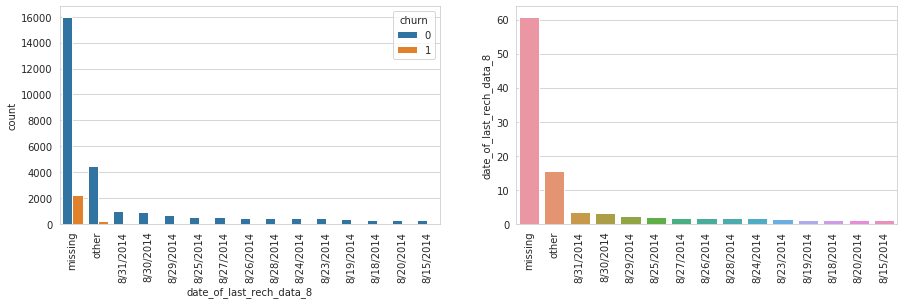

In [39]:
plot_cat(col_list)

Algorithms require numerical data for processing hence we will convert date columns to dummy data.

In [40]:
dummy = pd.get_dummies(high_valued[col_list],drop_first=True,dummy_na=True)
dummy.head()

date_of_last_rech_6_6/20/2014  date_of_last_rech_6_6/21/2014  \
0                              0                              0   
1                              0                              0   
2                              1                              0   
3                              0                              0   
4                              0                              0   

   date_of_last_rech_6_6/22/2014  date_of_last_rech_6_6/23/2014  \
0                              0                              0   
1                              0                              0   
2                              0                              0   
3                              0                              0   
4                              0                              0   

   date_of_last_rech_6_6/24/2014  date_of_last_rech_6_6/25/2014  \
0                              0                              0   
1                              0                              1   
2                              0                              0   
3                              0                              0   
4                              0                              0   

   date_of_last_rech_6_6/26/2014  date_of_last_rech_6_6/27/2014  \
0                              0                              1   
1                              0                              0   
2                              0                              0   
3                              0                              0   
4                              0                              0   

   date_of_last_rech_6_6/28/2014  date_of_last_rech_6_6/29/2014  ...  \
0                              0                              0  ...   
1                              0                              0  ...   
2                              0                              0  ...   
3                              0                              0  ...   
4                              0                              0  ...   

   date_of_last_rech_data_8_8/24/2014  date_of_last_rech_data_8_8/25/2014  \
0                                   0                                   0   
1                                   0                                   0   
2                                   0                                   0   
3                                   0                                   0   
4                                   0                                   0   

   date_of_last_rech_data_8_8/26/2014  date_of_last_rech_data_8_8/27/2014  \
0                                   0                                   0   
1                                   0                                   0   
2                                   0                                   0   
3                                   0                                   0   
4                                   0                                   0   

   date_of_last_rech_data_8_8/28/2014  date_of_last_rech_data_8_8/29/2014  \
0                                   0                                   0   
1                                   0                                   0   
2                                   0                                   0   
3                                   0                                   0   
4                                   0                                   0   

   date_of_last_rech_data_8_8/30/2014  date_of_last_rech_data_8_8/31/2014  \
0                                   0                                   0   
1                                   0                                   0   
2                                   1                                   0   
3                                   0                                   0   
4                                   0                                   0   

   date_of_last_rech_data_8_other  date_of_last_rech_data_8_nan  
0                               0       

In [41]:
high_valued = pd.concat([high_valued, dummy], axis=1)
drop_col(col_list)

(29979, 152)

## III. Spliting and PCA<a id='III'></a>

***Split data into train and test so that we can validate results on unseen data after training.***

In [42]:
O_X_train, O_X_test, O_y_train, O_y_test = train_test_split(high_valued.drop('churn',axis=1), high_valued['churn'],
                                                            train_size = 0.70,stratify=high_valued['churn'],random_state=100)

In [43]:
O_y_train = O_y_train.values.reshape((-1,1))
O_y_test = O_y_test.values.reshape((-1,1))
O_X_train = O_X_train.values.copy(order='C')
O_X_test = O_X_test.values.copy(order='C')
print('O_X_train shape: ',O_X_train.shape)
print('O_X_test shape: ',O_X_test.shape)
print('O_y_train shape: ',O_y_train.shape)
print('O_y_test shape: ',O_y_test.shape)

O_X_train shape:  (20985, 151)
O_X_test shape:  (8994, 151)
O_y_train shape:  (20985, 1)
O_y_test shape:  (8994, 1)


***Perform Principal component analysis (PCA) on data to reduce dimentionality***

In [44]:
pca = PCA(random_state=100)
pca.fit(O_X_train)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=100,
    svd_solver='auto', tol=0.0, whiten=False)

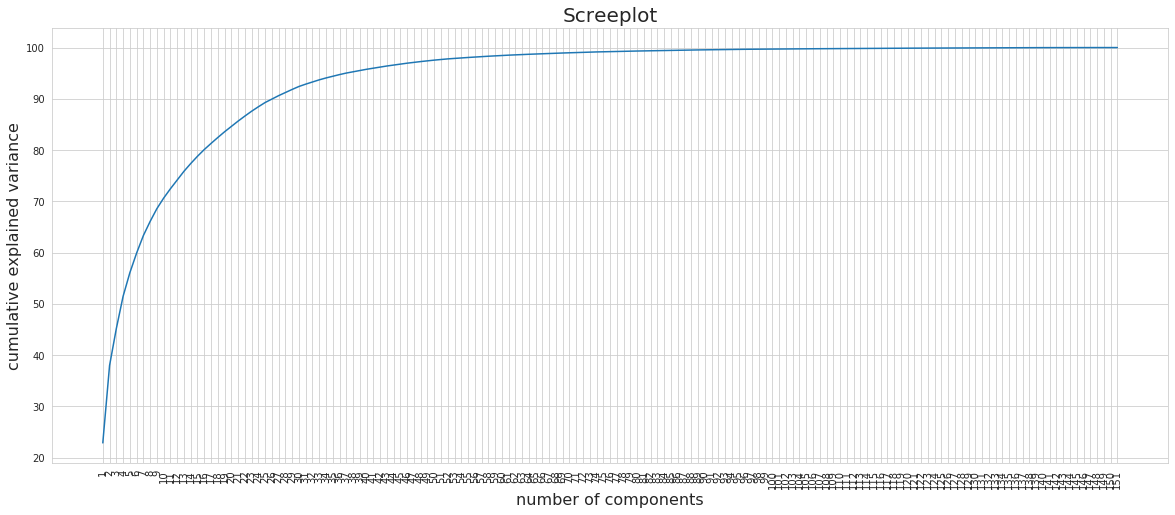

In [45]:
# plot scree plot to identify number of important PCs
%matplotlib inline
sns.set_style('whitegrid')
fig = plt.figure(figsize = (20,8))
ax = plt.plot(np.cumsum(pca.explained_variance_ratio_ * 100))
plt.xlabel('number of components', fontsize=16)
plt.ylabel('cumulative explained variance', fontsize=16)
plt.title('Screeplot', fontsize=20)
plt.xticks(range(pca.n_components_),range(1,pca.n_components_+1))
plt.xticks(rotation=90)
plt.show()

50 components explain about 98% of the variance in the date so lets keep only 50 components.

In [46]:
np.cumsum(pca.explained_variance_ratio_ * 100)[50]

97.67268564227315

In [47]:
# fit PCA and transform train data
pca = PCA(n_components=50,random_state=100)
X_train = pca.fit_transform(O_X_train)
y_train = O_y_train
X_train.shape

(20985, 50)

In [48]:
# transform test data that is previously fitted on train data
X_test = pca.transform(O_X_test)
y_test = O_y_test
X_test.shape

(8994, 50)

## IV. Model Building<a id='IV'></a>

### Metrics and Evaluation

We will use Roc_auc as our prime metric for model evaluation because it involves 2 things
1. True Positive Rate - how good are we at capturing positive cases (reduces churn)
2. False Positive Rate - how good are we at avoiding false positives (saves money)

Also as secondary metric we'll use recall because we want to identify and retain as many customers as possible.

Before we start building models lets define the evaluation function.

In [49]:
# evaluation function that uses Stratified KFold croassvalidation and returns all classification metrics

skf = StratifiedKFold(n_splits=5,shuffle=True,random_state=100)
all_result = pd.DataFrame(columns=['accuracy','precision','recall','f1','auc'])
def basic_eval(classifiers,X=X_train,y=y_train):
  global all_result
  accuracy_lst = []
  precision_lst = []
  recall_lst = []
  f1_lst = []
  auc_lst = []
  result = pd.DataFrame(columns=['accuracy','precision','recall','f1','auc'])

  start = time()
  for key, classifier in classifiers.items():
      for train, test in skf.split(X, y):

          pipeline = make_pipeline(SMOTE(n_jobs=-1,random_state=100), classifier)
          pipeline.fit(X[train], y[train])
          prediction = pipeline.predict(X[test])

          accuracy_lst.append(accuracy_score(y[test], prediction))
          precision_lst.append(precision_score(y[test], prediction))
          recall_lst.append(recall_score(y[test], prediction))
          f1_lst.append(f1_score(y[test], prediction))
          auc_lst.append(roc_auc_score(y[test], prediction))
          
      s = pd.Series([round(np.mean(accuracy_lst),3),round(np.mean(precision_lst),3),round(np.mean(recall_lst),3),round(np.mean(f1_lst),3),
                      round(np.mean(auc_lst),3)], index=result.columns)
      s.name = key
      result = result.append(s)
      
      all_result = all_result.append(s)

      '''print('-' * 45)
      print(key)
      print('-' * 45)
      print("accuracy: {}".format(np.mean(accuracy_lst)))
      print("precision: {}".format(np.mean(precision_lst)))
      print("recall: {}".format(np.mean(recall_lst)))
      print("f1: {}".format(np.mean(f1_lst)))
      print("auc: {}".format(np.mean(auc_lst)))
      print('-' * 45)'''
  end = time()
  #print('Time taken: ',round(end-start,2),' seconds')
  #result = result.set_index('algorithm').sort_values(by='auc',ascending=False)
  #del result.index.name
  return result.sort_values(by='auc',ascending=False)

Lets start with exploring the best model that can be used to predict churn.

In [50]:
# evaluating all class of models to identify best classes for further analysis
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier

classifiers = {
    "LogisiticRegression": LogisticRegression(random_state=100),
    "KNeighborsClassifier": KNeighborsClassifier(),
    "SupportVectorClassifier": SVC(random_state=100),
    "DecisionTreeClassifier": DecisionTreeClassifier(random_state=100),
    "RandomForestClassifier": RandomForestClassifier(random_state=100),
    "GaussianNB": GaussianNB(),
    "XGBClassifier": XGBClassifier(random_state=100)
}

# uncomment the below line to run code which on average takes 1010 seconds or use below markdown as reference
#basic_eval(classifiers)

<table>
<thead>
<tr><th>                       </th><th style="text-align: right;">  accuracy</th><th style="text-align: right;">  precision</th><th style="text-align: right;">  recall</th><th style="text-align: right;">   f1</th><th style="text-align: right;">  auc</th></tr>
</thead>
<tbody>
<tr><td>LogisiticRegression    </td><td style="text-align: right;">     0.873</td><td style="text-align: right;">      0.383</td><td style="text-align: right;">   0.765</td><td style="text-align: right;">0.51 </td><td style="text-align: right;">0.824</td></tr>
<tr><td>KNeighborsClassifier   </td><td style="text-align: right;">     0.844</td><td style="text-align: right;">      0.33 </td><td style="text-align: right;">   0.741</td><td style="text-align: right;">0.455</td><td style="text-align: right;">0.797</td></tr>
<tr><td>SupportVectorClassifier</td><td style="text-align: right;">     0.87 </td><td style="text-align: right;">      0.415</td><td style="text-align: right;">   0.61 </td><td style="text-align: right;">0.449</td><td style="text-align: right;">0.752</td></tr>
<tr><td>XGBClassifier          </td><td style="text-align: right;">     0.874</td><td style="text-align: right;">      0.404</td><td style="text-align: right;">   0.605</td><td style="text-align: right;">0.457</td><td style="text-align: right;">0.752</td></tr>
<tr><td>GaussianNB             </td><td style="text-align: right;">     0.872</td><td style="text-align: right;">      0.403</td><td style="text-align: right;">   0.584</td><td style="text-align: right;">0.447</td><td style="text-align: right;">0.741</td></tr>
<tr><td>DecisionTreeClassifier </td><td style="text-align: right;">     0.863</td><td style="text-align: right;">      0.38 </td><td style="text-align: right;">   0.587</td><td style="text-align: right;">0.427</td><td style="text-align: right;">0.738</td></tr>
<tr><td>RandomForestClassifier </td><td style="text-align: right;">     0.875</td><td style="text-align: right;">      0.417</td><td style="text-align: right;">   0.57 </td><td style="text-align: right;">0.448</td><td style="text-align: right;">0.737</td></tr>
</tbody>
</table>

***Observations***
1. Accuracy of every model is almost at par with each other.
2. Linear and Neighbor based models such as Logistic regression and KNeighborsClassifier is performing best in terms of auc and recall.
3. Ensemble and boosting models are performing best in terms of precision.

In [51]:
# linears
from sklearn.linear_model.stochastic_gradient import SGDClassifier
from sklearn.linear_model.ridge import RidgeClassifier
from sklearn.linear_model.passive_aggressive import PassiveAggressiveClassifier
from sklearn.linear_model import Perceptron

linears = {
    "SGDClassifier": SGDClassifier(random_state=100),
    "RidgeClassifier": RidgeClassifier(random_state=100),
    "PassiveAggressiveClassifier": PassiveAggressiveClassifier(random_state=100),
    "Perceptron": Perceptron(random_state=100)
}

# uncomment the below line to run code which on average takes 15 seconds or use below markdown as reference
#basic_eval(linears)

<table>
<thead>
<tr><th>                           </th><th style="text-align: right;">  accuracy</th><th style="text-align: right;">  precision</th><th style="text-align: right;">  recall</th><th style="text-align: right;">   f1</th><th style="text-align: right;">  auc</th></tr>
</thead>
<tbody>
<tr><td>RidgeClassifier            </td><td style="text-align: right;">     0.867</td><td style="text-align: right;">      0.377</td><td style="text-align: right;">   0.764</td><td style="text-align: right;">0.503</td><td style="text-align: right;">0.821</td></tr>
<tr><td>SGDClassifier              </td><td style="text-align: right;">     0.858</td><td style="text-align: right;">      0.361</td><td style="text-align: right;">   0.77 </td><td style="text-align: right;">0.488</td><td style="text-align: right;">0.818</td></tr>
<tr><td>PassiveAggressiveClassifier</td><td style="text-align: right;">     0.828</td><td style="text-align: right;">      0.333</td><td style="text-align: right;">   0.768</td><td style="text-align: right;">0.457</td><td style="text-align: right;">0.801</td></tr>
<tr><td>Perceptron                 </td><td style="text-align: right;">     0.816</td><td style="text-align: right;">      0.313</td><td style="text-align: right;">   0.758</td><td style="text-align: right;">0.436</td><td style="text-align: right;">0.79 </td></tr>
</tbody>
</table>

RidgeClassifier is at par with Logistic Regression and can be considered for further tuning.

In [52]:
# neighbors
np.random.seed(100)
from sklearn.neighbors import NearestCentroid

neighbors = {
    "NearestCentroid": NearestCentroid()
}

# uncomment the below line to run code which on average takes 50 seconds or use below markdown as reference
#basic_eval(neighbors)

<table>
<thead>
<tr><th>                    </th><th style="text-align: right;">  accuracy</th><th style="text-align: right;">  precision</th><th style="text-align: right;">  recall</th><th style="text-align: right;">   f1</th><th style="text-align: right;">  auc</th></tr>
</thead>
<tbody>
<tr><td>NearestCentroid</td><td style="text-align: right;">     0.813</td><td style="text-align: right;">      0.276</td><td style="text-align: right;">   0.714</td><td style="text-align: right;">0.398</td><td style="text-align: right;">0.768</td></tr>
</tbody>
</table>

Neighbor algorithms doesnot require to be evaluated further.

In [53]:
# ensembles
np.random.seed(100)
from sklearn.ensemble.weight_boosting import AdaBoostClassifier
from sklearn.ensemble.gradient_boosting import GradientBoostingClassifier
from sklearn.ensemble.bagging import BaggingClassifier
from sklearn.ensemble.forest import ExtraTreesClassifier
from sklearn.ensemble.forest import RandomForestClassifier
from xgboost import XGBClassifier

ensembles = {
    "AdaBoostClassifier": AdaBoostClassifier(random_state=100),
    "GradientBoostingClassifier": GradientBoostingClassifier(random_state=100),
    "BaggingClassifier": BaggingClassifier(random_state=100),
    "ExtraTreesClassifier": ExtraTreesClassifier(random_state=100)
}

# uncomment the below line to run code which on average takes 350 seconds or use below markdown as reference
#basic_eval(ensembles)

<table>
<thead>
<tr><th>                          </th><th style="text-align: right;">  accuracy</th><th style="text-align: right;">  precision</th><th style="text-align: right;">  recall</th><th style="text-align: right;">   f1</th><th style="text-align: right;">  auc</th></tr>
</thead>
<tbody>
<tr><td>GradientBoostingClassifier</td><td style="text-align: right;">     0.867</td><td style="text-align: right;">      0.369</td><td style="text-align: right;">   0.73 </td><td style="text-align: right;">0.489</td><td style="text-align: right;">0.805</td></tr>
<tr><td>AdaBoostClassifier        </td><td style="text-align: right;">     0.849</td><td style="text-align: right;">      0.33 </td><td style="text-align: right;">   0.723</td><td style="text-align: right;">0.453</td><td style="text-align: right;">0.792</td></tr>
<tr><td>BaggingClassifier         </td><td style="text-align: right;">     0.883</td><td style="text-align: right;">      0.418</td><td style="text-align: right;">   0.663</td><td style="text-align: right;">0.5  </td><td style="text-align: right;">0.784</td></tr>

<tr><td>ExtraTreesClassifier      </td><td style="text-align: right;">     0.894</td><td style="text-align: right;">      0.464</td><td style="text-align: right;">   0.616</td><td style="text-align: right;">0.507</td><td style="text-align: right;">0.768</td></tr>
</tbody>
</table>

GradientBoostingClassifier performs good in terms of recall, f1 and auc.

### Hyper-paramerter tuning

In [54]:
# function to perform grid search cross validation over the given param grid and return the best estimator
def hyper_eval(classifier, params):
  model = make_pipeline(SMOTE(n_jobs=-1,random_state=100), classifier)
  model_cv = GridSearchCV(model, param_grid=params, scoring='roc_auc', cv=skf, return_train_score=True, verbose=1, n_jobs=-1, 
                          iid=False)
  model_cv.fit(X_train, y_train)
  return model_cv.best_estimator_.steps[1][1]

***LogisticRegression***

In [55]:
params = {'logisticregression__penalty': ['l1','l2'], 'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 
          'logisticregression__class_weight': ['balanced',None], 'logisticregression__solver': ['liblinear','saga']}
classifier = LogisticRegression(n_jobs=-1,random_state=100)

# uncomment the below line to run code or use below estimator as reference
#best_LGR = hyper_eval(classifier, params)

In [56]:
best_LGR = LogisticRegression(C=0.001, class_weight='balanced', dual=False, fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                              max_iter=100, multi_class='warn', n_jobs=-1, penalty='l2', random_state=100, solver='liblinear',
                              tol=0.0001, verbose=0, warm_start=False)

In [57]:
# uncomment the below line to run code or use below markdown as reference
#basic_eval({'Best_LogisticRegression': best_LGR})

<table>
<thead>
<tr><th>                       </th><th style="text-align: right;">  accuracy</th><th style="text-align: right;">  precision</th><th style="text-align: right;">  recall</th><th style="text-align: right;">   f1</th><th style="text-align: right;">  auc</th></tr>
</thead>
<tbody>
<tr><td>Best_LogisticRegression</td><td style="text-align: right;">     0.863</td><td style="text-align: right;">      0.363</td><td style="text-align: right;">   0.782</td><td style="text-align: right;">0.496</td><td style="text-align: right;">0.826</td></tr>
</tbody>
</table>

***RidgeClassifier***

In [58]:
params = {'ridgeclassifier__alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'ridgeclassifier__class_weight': ['balanced',None], 
          'ridgeclassifier__solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']}
classifier = RidgeClassifier(random_state=100)

# uncomment the below line to run code or use below estimator as reference
#best_RGC = hyper_eval(classifier, params)

In [59]:
best_RGC = RidgeClassifier(alpha=1000, class_weight='balanced', copy_X=True, fit_intercept=True, max_iter=None, normalize=False, 
                           random_state=100, solver='saga', tol=0.001)

In [60]:
# uncomment the below line to run code or use below markdown as reference
#basic_eval({'Best_RidgeClassifier': best_RGC})

<table>
<thead>
<tr><th>                    </th><th style="text-align: right;">  accuracy</th><th style="text-align: right;">  precision</th><th style="text-align: right;">  recall</th><th style="text-align: right;">  f1</th><th style="text-align: right;">  auc</th></tr>
</thead>
<tbody>
<tr><td>Best_RidgeClassifier</td><td style="text-align: right;">     0.886</td><td style="text-align: right;">      0.411</td><td style="text-align: right;">   0.749</td><td style="text-align: right;">0.531</td><td style="text-align: right;">0.824</td></tr>
</tbody>
</table>

***GradientBoostingClassifier***

In [61]:
params = {'gradientboostingclassifier__max_depth': [2, 3, 4, 5],
          'gradientboostingclassifier__n_estimators': [10, 50, 100, 500, 1000]}
classifier = GradientBoostingClassifier(random_state=100)

# uncomment the below line to run code or use below estimator as reference
#best_GBC = hyper_eval(classifier, params)

In [62]:
best_GBC = GradientBoostingClassifier(criterion='friedman_mse', init=None, learning_rate=0.1, loss='deviance', max_depth=3, 
                                      max_features=None, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None,
                                      min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators=50,
                                      n_iter_no_change=None, presort='auto', random_state=100, subsample=1.0, tol=0.0001,
                                      validation_fraction=0.1, verbose=0, warm_start=False)

In [63]:
# uncomment the below line to run code or use below markdown as reference
#basic_eval({'Best_GradientBoostingClassifier': best_GBC})

<table>
<thead>
<tr><th>                               </th><th style="text-align: right;">  accuracy</th><th style="text-align: right;">  precision</th><th style="text-align: right;">  recall</th><th style="text-align: right;">   f1</th><th style="text-align: right;">  auc</th></tr>
</thead>
<tbody>
<tr><td>Best_GradientBoostingClassifier</td><td style="text-align: right;">     0.878</td><td style="text-align: right;">      0.391</td><td style="text-align: right;">    0.74</td><td style="text-align: right;">0.512</td><td style="text-align: right;">0.816</td></tr>
</tbody>
</table>

***XGBClassifier***

In [64]:
params = {'xgbclassifier__max_depth': [2, 3, 4, 5], 'xgbclassifier__n_estimators': [10, 50, 100, 500, 1000]}
classifier = XGBClassifier(random_state=100,n_jobs=-1)

# uncomment the below line to run code or use below estimator as reference
#best_XGB = hyper_eval(classifier, params)

In [65]:
best_XGB = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1, gamma=0, 
                         learning_rate=0.1, max_delta_step=0, max_depth=4, min_child_weight=1, missing=None, n_estimators=50, 
                         n_jobs=-1, nthread=None, objective='binary:logistic', random_state=100, reg_alpha=0, reg_lambda=1, 
                         scale_pos_weight=1, seed=None, silent=None, subsample=1, verbosity=1)

In [66]:
# uncomment the below line to run code or use below markdown as reference
#basic_eval({'Best_XGBClassifier': best_XGB})

<table>
<thead>
<tr><th>                  </th><th style="text-align: right;">  accuracy</th><th style="text-align: right;">  precision</th><th style="text-align: right;">  recall</th><th style="text-align: right;">   f1</th><th style="text-align: right;">  auc</th></tr>
</thead>
<tbody>
<tr><td>Best_XGBClassifier</td><td style="text-align: right;">     0.886</td><td style="text-align: right;">      0.411</td><td style="text-align: right;">   0.729</td><td style="text-align: right;">0.525</td><td style="text-align: right;">0.815</td></tr>
</tbody>
</table>

***RandomForestClassifier***

In [67]:
params = {'randomforestclassifier__max_depth': [2, 3, 4, 5], 
          'randomforestclassifier__n_estimators': [10, 50, 100, 500, 1000]}
classifier = RandomForestClassifier(random_state=100,n_jobs=-1)

# uncomment the below line to run code or use below estimator as reference
#best_RFC = hyper_eval(classifier, params)

In [68]:
best_RFC = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini', max_depth=5, max_features='auto', 
                                  max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=1, 
                                  min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1, oob_score=False, 
                                  random_state=100, verbose=0, warm_start=False)

In [69]:
# uncomment the below line to run code or use below markdown as reference
#basic_eval({'Best_RandomForestClassifier': best_RFC})

<table>
<thead>
<tr><th>                           </th><th style="text-align: right;">  accuracy</th><th style="text-align: right;">  precision</th><th style="text-align: right;">  recall</th><th style="text-align: right;">  f1</th><th style="text-align: right;">  auc</th></tr>
</thead>
<tbody>
<tr><td>Best_RandomForestClassifier</td><td style="text-align: right;">     0.894</td><td style="text-align: right;">      0.429</td><td style="text-align: right;">   0.695</td><td style="text-align: right;">0.53</td><td style="text-align: right;">0.804</td></tr>
</tbody>
</table>

### Evaluation WOPCA - Without PCA

In [70]:
# uncomment the below line to run code or use below markdown as reference
#basic_eval({'Best_LogisticRegression_WOPCA': best_LGR}, O_X_train, O_y_train)

<table>
<thead>
<tr><th>                             </th><th style="text-align: right;">  accuracy</th><th style="text-align: right;">  precision</th><th style="text-align: right;">  recall</th><th style="text-align: right;">   f1</th><th style="text-align: right;">  auc</th></tr>
</thead>
<tbody>
<tr><td>Best_LogisticRegression_WOPCA</td><td style="text-align: right;">     0.878</td><td style="text-align: right;">      0.396</td><td style="text-align: right;">   0.791</td><td style="text-align: right;">0.528</td><td style="text-align: right;">0.838</td></tr>
</tbody>
</table>

In [71]:
# uncomment the below line to run code or use below markdown as reference
#basic_eval({'Best_RidgeClassifier_WOPCA': best_RGC}, O_X_train, O_y_train)

<table>
<thead>
<tr><th>                          </th><th style="text-align: right;">  accuracy</th><th style="text-align: right;">  precision</th><th style="text-align: right;">  recall</th><th style="text-align: right;">   f1</th><th style="text-align: right;">  auc</th></tr>
</thead>
<tbody>
<tr><td>Best_RidgeClassifier_WOPCA</td><td style="text-align: right;">     0.894</td><td style="text-align: right;">      0.438</td><td style="text-align: right;">   0.786</td><td style="text-align: right;">0.562</td><td style="text-align: right;">0.845</td></tr>
</tbody>
</table>

In [72]:
# uncomment the below line to run code or use below markdown as reference
#basic_eval({'Best_GradientBoostingClassifier_WOPCA': best_GBC}, O_X_train, O_y_train)

<table>
<thead>
<tr><th>                                     </th><th style="text-align: right;">  accuracy</th><th style="text-align: right;">  precision</th><th style="text-align: right;">  recall</th><th style="text-align: right;">   f1</th><th style="text-align: right;">  auc</th></tr>
</thead>
<tbody>
<tr><td>Best_GradientBoostingClassifier_WOPCA</td><td style="text-align: right;">     0.924</td><td style="text-align: right;">      0.552</td><td style="text-align: right;">   0.648</td><td style="text-align: right;">0.596</td><td style="text-align: right;">0.799</td></tr>
</tbody>
</table>

In [73]:
# uncomment the below line to run code or use below markdown as reference
#basic_eval({'Best_XGBClassifier_WOPCA': best_XGB}, O_X_train, O_y_train)

<table>
<thead>
<tr><th>                        </th><th style="text-align: right;">  accuracy</th><th style="text-align: right;">  precision</th><th style="text-align: right;">  recall</th><th style="text-align: right;">   f1</th><th style="text-align: right;">  auc</th></tr>
</thead>
<tbody>
<tr><td>Best_XGBClassifier_WOPCA</td><td style="text-align: right;">     0.929</td><td style="text-align: right;">      0.581</td><td style="text-align: right;">   0.634</td><td style="text-align: right;">0.606</td><td style="text-align: right;">0.795</td></tr>
</tbody>
</table>

In [74]:
# uncomment the below line to run code or use below markdown as reference
#basic_eval({'Best_RandomForestClassifier_WOPCA': best_RFC}, O_X_train, O_y_train)

<table>
<thead>
<tr><th>                                 </th><th style="text-align: right;">  accuracy</th><th style="text-align: right;">  precision</th><th style="text-align: right;">  recall</th><th style="text-align: right;">   f1</th><th style="text-align: right;">  auc</th></tr>
</thead>
<tbody>
<tr><td>Best_RandomForestClassifier_WOPCA</td><td style="text-align: right;">     0.911</td><td style="text-align: right;">      0.488</td><td style="text-align: right;">   0.699</td><td style="text-align: right;">0.575</td><td style="text-align: right;">0.815</td></tr>
</tbody>
</table>

### Evaluating model performance on test data

In [75]:
# function to evaluate and return different metrics on given data

all_result_test = pd.DataFrame(columns=['accuracy','precision','recall','f1','auc'])
def get_scores(key,y_test,y_pred):
  global all_result_test
  result = pd.DataFrame(columns=['accuracy','precision','recall','f1','auc'])
  s = pd.Series([round(accuracy_score(y_test,y_pred),3),round(precision_score(y_test,y_pred),3),round(recall_score(y_test,y_pred),3),
                 round(f1_score(y_test,y_pred),3),round(roc_auc_score(y_test,y_pred),3)], index=result.columns)
  s.name = key
  result = result.append(s)
  
  all_result_test = all_result_test.append(s)
  return result

In [76]:
# function to evaluate scores on test data with and without PCA

def test_scores(classifier):
  pipeline = make_pipeline(SMOTE(n_jobs=-1,random_state=100), classifier)
  pipeline.fit(X_train,y_train)
  y_pred = pipeline.predict(X_test)
  print('-'*30)
  print('With PCA')
  print(get_scores(classifier.__class__.__name__+'_Test',y_test,y_pred))
  pipeline.fit(O_X_train,O_y_train)
  y_pred = pipeline.predict(O_X_test)
  print('-'*30)
  print('Without PCA')
  print(get_scores(classifier.__class__.__name__+'_Test_WOPCA',y_test,y_pred))
  print('-'*30)

***LogisticRegression***

In [77]:
# uncomment the below line to run code or use below markdown as reference
#test_scores(best_LGR)

<table>
<thead>
<tr><th>                       </th><th style="text-align: right;">  accuracy</th><th style="text-align: right;">  precision</th><th style="text-align: right;">  recall</th><th style="text-align: right;">   f1</th><th style="text-align: right;">  auc</th></tr>
</thead>
<tbody>
<tr><td>LogisticRegression_Test</td><td style="text-align: right;">     0.863</td><td style="text-align: right;">      0.364</td><td style="text-align: right;">   0.781</td><td style="text-align: right;">0.496</td><td style="text-align: right;">0.826</td></tr>
<tr><td>LogisticRegression_Test_WOPCA</td><td style="text-align: right;">     0.874</td><td style="text-align: right;">      0.389</td><td style="text-align: right;">   0.792</td><td style="text-align: right;">0.521</td><td style="text-align: right;">0.837</td></tr>
</tbody>
</table>

***RidgeClassifier***

In [78]:
# uncomment the below line to run code or use below markdown as reference
#test_scores(best_RGC)

<table>
<thead>
<tr><th>                    </th><th style="text-align: right;">  accuracy</th><th style="text-align: right;">  precision</th><th style="text-align: right;">  recall</th><th style="text-align: right;">   f1</th><th style="text-align: right;">  auc</th></tr>
</thead>
<tbody>
<tr><td>RidgeClassifier_Test</td><td style="text-align: right;">      0.89</td><td style="text-align: right;">      0.424</td><td style="text-align: right;">   0.764</td><td style="text-align: right;">0.545</td><td style="text-align: right;">0.833</td></tr>
<tr><td>RidgeClassifier_Test_WOPCA</td><td style="text-align: right;">     0.896</td><td style="text-align: right;">      0.443</td><td style="text-align: right;">    0.79</td><td style="text-align: right;">0.568</td><td style="text-align: right;">0.848</td></tr>
</tbody>
</table>

***GradientBoostingClassifier***

In [79]:
# uncomment the below line to run code or use below markdown as reference
#test_scores(best_GBC)

<table>
<thead>
<tr><th>                               </th><th style="text-align: right;">  accuracy</th><th style="text-align: right;">  precision</th><th style="text-align: right;">  recall</th><th style="text-align: right;">   f1</th><th style="text-align: right;">  auc</th></tr>
</thead>
<tbody>
<tr><td>GradientBoostingClassifier_Test</td><td style="text-align: right;">     0.939</td><td style="text-align: right;">      0.741</td><td style="text-align: right;">   0.457</td><td style="text-align: right;">0.565</td><td style="text-align: right;">0.721</td></tr>
<tr><td>GradientBoostingClassifier_Test_WOPCA</td><td style="text-align: right;">     0.942</td><td style="text-align: right;">      0.732</td><td style="text-align: right;">   0.524</td><td style="text-align: right;">0.611</td><td style="text-align: right;">0.753</td></tr>
</tbody>
</table>

***XGBClassifier***

In [80]:
# uncomment the below line to run code or use below markdown as reference
#test_scores(best_XGB)

<table>
<thead>
<tr><th>                  </th><th style="text-align: right;">  accuracy</th><th style="text-align: right;">  precision</th><th style="text-align: right;">  recall</th><th style="text-align: right;">   f1</th><th style="text-align: right;">  auc</th></tr>
</thead>
<tbody>
<tr><td>XGBClassifier_Test</td><td style="text-align: right;">     0.939</td><td style="text-align: right;">      0.743</td><td style="text-align: right;">   0.457</td><td style="text-align: right;">0.566</td><td style="text-align: right;">0.721</td></tr>
<tr><td>XGBClassifier_Test_WOPCA</td><td style="text-align: right;">     0.943</td><td style="text-align: right;">       0.74</td><td style="text-align: right;">   0.517</td><td style="text-align: right;">0.609</td><td style="text-align: right;"> 0.75</td></tr>
</tbody>
</table>

***RandomForestClassifier***

In [81]:
# uncomment the below line to run code or use below markdown as reference
#test_scores(best_RFC)

<table>
<thead>
<tr><th>                           </th><th style="text-align: right;">  accuracy</th><th style="text-align: right;">  precision</th><th style="text-align: right;">  recall</th><th style="text-align: right;">   f1</th><th style="text-align: right;">  auc</th></tr>
</thead>
<tbody>
<tr><td>RandomForestClassifier_Test</td><td style="text-align: right;">     0.929</td><td style="text-align: right;">      0.843</td><td style="text-align: right;">   0.214</td><td style="text-align: right;">0.341</td><td style="text-align: right;">0.605</td></tr>
<tr><td>RandomForestClassifier_Test_WOPCA</td><td style="text-align: right;">     0.939</td><td style="text-align: right;">      0.765</td><td style="text-align: right;">   0.427</td><td style="text-align: right;">0.548</td><td style="text-align: right;">0.707</td></tr>
</tbody>
</table>

## V. Model Performance<a id='V'></a>

In [82]:
# uncomment the below line and all basic_eval line above to run code or use below markdown as reference
#all_result

<table>
<thead>
<tr><th>                                     </th><th style="text-align: right;">  accuracy</th><th style="text-align: right;">  precision</th><th style="text-align: right;">  recall</th><th style="text-align: right;">   f1</th><th style="text-align: right;">  auc</th></tr>
</thead>
<tbody>
<tr><td>LogisiticRegression                  </td><td style="text-align: right;">     0.874</td><td style="text-align: right;">      0.384</td><td style="text-align: right;">   0.767</td><td style="text-align: right;">0.512</td><td style="text-align: right;">0.825</td></tr>
<tr><td>KNeighborsClassifier                 </td><td style="text-align: right;">     0.843</td><td style="text-align: right;">      0.329</td><td style="text-align: right;">   0.738</td><td style="text-align: right;">0.454</td><td style="text-align: right;">0.796</td></tr>
<tr><td>SupportVectorClassifier              </td><td style="text-align: right;">     0.87 </td><td style="text-align: right;">      0.416</td><td style="text-align: right;">   0.611</td><td style="text-align: right;">0.45 </td><td style="text-align: right;">0.753</td></tr>
<tr><td>DecisionTreeClassifier               </td><td style="text-align: right;">     0.862</td><td style="text-align: right;">      0.38 </td><td style="text-align: right;">   0.588</td><td style="text-align: right;">0.427</td><td style="text-align: right;">0.738</td></tr>
<tr><td>RandomForestClassifier               </td><td style="text-align: right;">     0.874</td><td style="text-align: right;">      0.417</td><td style="text-align: right;">   0.573</td><td style="text-align: right;">0.449</td><td style="text-align: right;">0.738</td></tr>
<tr><td>GaussianNB                           </td><td style="text-align: right;">     0.872</td><td style="text-align: right;">      0.404</td><td style="text-align: right;">   0.586</td><td style="text-align: right;">0.448</td><td style="text-align: right;">0.742</td></tr>
<tr><td>XGBClassifier                        </td><td style="text-align: right;">     0.874</td><td style="text-align: right;">      0.405</td><td style="text-align: right;">   0.606</td><td style="text-align: right;">0.46 </td><td style="text-align: right;">0.753</td></tr>
<tr><td>SGDClassifier                        </td><td style="text-align: right;">     0.86 </td><td style="text-align: right;">      0.355</td><td style="text-align: right;">   0.747</td><td style="text-align: right;">0.48 </td><td style="text-align: right;">0.809</td></tr>
<tr><td>RidgeClassifier                      </td><td style="text-align: right;">     0.873</td><td style="text-align: right;">      0.382</td><td style="text-align: right;">   0.747</td><td style="text-align: right;">0.505</td><td style="text-align: right;">0.816</td></tr>
<tr><td>PassiveAggressiveClassifier          </td><td style="text-align: right;">     0.834</td><td style="text-align: right;">      0.332</td><td style="text-align: right;">   0.747</td><td style="text-align: right;">0.454</td><td style="text-align: right;">0.795</td></tr>
<tr><td>Perceptron                           </td><td style="text-align: right;">     0.807</td><td style="text-align: right;">      0.301</td><td style="text-align: right;">   0.743</td><td style="text-align: right;">0.42 </td><td style="text-align: right;">0.778</td></tr>
<tr><td>NearestCentroid                      </td><td style="text-align: right;">     0.884</td><td style="text-align: right;">      0.397</td><td style="text-align: right;">   0.662</td><td style="text-align: right;">0.496</td><td style="text-align: right;">0.784</td></tr>
<tr><td>AdaBoostClassifier                   </td><td style="text-align: right;">     0.851</td><td style="text-align: right;">      0.334</td><td style="text-align: right;">   0.735</td><td style="text-align: right;">0.459</td><td style="text-align: right;">0.798</td></tr>
<tr><td>GradientBoostingClassifier           </td><td style="text-align: right;">     0.869</td><td style="text-align: right;">      0.375</td><td style="text-align: right;">   0.736</td><td style="text-align: right;">0.496</td><td style="text-align: right;">0.809</td></tr>
<tr><td>BaggingClassifier                    </td><td style="text-align: right;">     0.884</td><td style="text-align: right;">      0.416</td><td style="text-align: right;">   0.661</td><td style="text-align: right;">0.498</td><td style="text-align: right;">0.783</td></tr>
<tr><td>ExtraTreesClassifier                 </td><td style="text-align: right;">     0.896</td><td style="text-align: right;">      0.47 </td><td style="text-align: right;">   0.614</td><td style="text-align: right;">0.509</td><td style="text-align: right;">0.768</td></tr>
<tr><td>Best_LogisticRegression              </td><td style="text-align: right;">     0.863</td><td style="text-align: right;">      0.363</td><td style="text-align: right;">   0.782</td><td style="text-align: right;">0.496</td><td style="text-align: right;">0.826</td></tr>
<tr><td>Best_RidgeClassifier                 </td><td style="text-align: right;">     0.886</td><td style="text-align: right;">      0.411</td><td style="text-align: right;">   0.749</td><td style="text-align: right;">0.531</td><td style="text-align: right;">0.824</td></tr>
<tr><td>Best_GradientBoostingClassifier      </td><td style="text-align: right;">     0.878</td><td style="text-align: right;">      0.391</td><td style="text-align: right;">   0.74 </td><td style="text-align: right;">0.512</td><td style="text-align: right;">0.816</td></tr>
<tr><td>Best_XGBClassifier                   </td><td style="text-align: right;">     0.886</td><td style="text-align: right;">      0.411</td><td style="text-align: right;">   0.729</td><td style="text-align: right;">0.525</td><td style="text-align: right;">0.815</td></tr>
<tr><td>Best_RandomForestClassifier          </td><td style="text-align: right;">     0.894</td><td style="text-align: right;">      0.429</td><td style="text-align: right;">   0.695</td><td style="text-align: right;">0.53 </td><td style="text-align: right;">0.804</td></tr>
<tr><td>Best_LogisticRegression_WOPCA        </td><td style="text-align: right;">     0.878</td><td style="text-align: right;">      0.396</td><td style="text-align: right;">   0.791</td><td style="text-align: right;">0.528</td><td style="text-align: right;">0.838</td></tr>
<tr><td>Best_RidgeClassifier_WOPCA           </td><td style="text-align: right;">     0.894</td><td style="text-align: right;">      0.438</td><td style="text-align: right;">   0.786</td><td style="text-align: right;">0.562</td><td style="text-align: right;">0.845</td></tr>
<tr><td>Best_GradientBoostingClassifier_WOPCA</td><td style="text-align: right;">     0.924</td><td style="text-align: right;">      0.552</td><td style="text-align: right;">   0.648</td><td style="text-align: right;">0.596</td><td style="text-align: right;">0.799</td></tr>
<tr><td>Best_XGBClassifier_WOPCA             </td><td style="text-align: right;">     0.929</td><td style="text-align: right;">      0.581</td><td style="text-align: right;">   0.634</td><td style="text-align: right;">0.606</td><td style="text-align: right;">0.795</td></tr>
<tr><td>Best_RandomForestClassifier_WOPCA    </td><td style="text-align: right;">     0.911</td><td style="text-align: right;">      0.488</td><td style="text-align: right;">   0.699</td><td style="text-align: right;">0.575</td><td style="text-align: right;">0.815</td></tr>
</tbody>
</table>

In [83]:
# uncomment the below line and all test_scores line above to run code or use below markdown as reference
#all_result_test

<table>
<thead>
<tr><th>                                     </th><th style="text-align: right;">  accuracy</th><th style="text-align: right;">  precision</th><th style="text-align: right;">  recall</th><th style="text-align: right;">   f1</th><th style="text-align: right;">  auc</th></tr>
</thead>
<tbody>
<tr><td>LogisticRegression_Test              </td><td style="text-align: right;">     0.863</td><td style="text-align: right;">      0.364</td><td style="text-align: right;">   0.781</td><td style="text-align: right;">0.496</td><td style="text-align: right;">0.826</td></tr>
<tr><td>LogisticRegression_Test_WOPCA        </td><td style="text-align: right;">     0.874</td><td style="text-align: right;">      0.389</td><td style="text-align: right;">   0.792</td><td style="text-align: right;">0.521</td><td style="text-align: right;">0.837</td></tr>
<tr><td>RidgeClassifier_Test                 </td><td style="text-align: right;">     0.89 </td><td style="text-align: right;">      0.424</td><td style="text-align: right;">   0.764</td><td style="text-align: right;">0.545</td><td style="text-align: right;">0.833</td></tr>
<tr><td>RidgeClassifier_Test_WOPCA           </td><td style="text-align: right;">     0.896</td><td style="text-align: right;">      0.443</td><td style="text-align: right;">   0.79 </td><td style="text-align: right;">0.568</td><td style="text-align: right;">0.848</td></tr>
<tr><td>GradientBoostingClassifier_Test      </td><td style="text-align: right;">     0.939</td><td style="text-align: right;">      0.741</td><td style="text-align: right;">   0.457</td><td style="text-align: right;">0.565</td><td style="text-align: right;">0.721</td></tr>
<tr><td>GradientBoostingClassifier_Test_WOPCA</td><td style="text-align: right;">     0.942</td><td style="text-align: right;">      0.732</td><td style="text-align: right;">   0.524</td><td style="text-align: right;">0.611</td><td style="text-align: right;">0.753</td></tr>
<tr><td>XGBClassifier_Test                   </td><td style="text-align: right;">     0.939</td><td style="text-align: right;">      0.743</td><td style="text-align: right;">   0.457</td><td style="text-align: right;">0.566</td><td style="text-align: right;">0.721</td></tr>
<tr><td>XGBClassifier_Test_WOPCA             </td><td style="text-align: right;">     0.943</td><td style="text-align: right;">      0.74 </td><td style="text-align: right;">   0.517</td><td style="text-align: right;">0.609</td><td style="text-align: right;">0.75 </td></tr>
<tr><td>RandomForestClassifier_Test          </td><td style="text-align: right;">     0.929</td><td style="text-align: right;">      0.843</td><td style="text-align: right;">   0.214</td><td style="text-align: right;">0.341</td><td style="text-align: right;">0.605</td></tr>
<tr><td>RandomForestClassifier_Test_WOPCA    </td><td style="text-align: right;">     0.939</td><td style="text-align: right;">      0.765</td><td style="text-align: right;">   0.427</td><td style="text-align: right;">0.548</td><td style="text-align: right;">0.707</td></tr>
</tbody>
</table>

In [84]:
# uncomment the below line and all basic_eval line above to run code or use below markdown as reference
'''sns.set_style('whitegrid')
plt.figure(figsize=(15,4))
plt.title('Train AUC Score')
plfd = all_result.sort_values(by='auc',ascending=False)
ax = sns.barplot(x=plfd.index,y=plfd.auc,color='b')
plt.xticks(rotation=90)
plt.show()'''

"sns.set_style('whitegrid')\nplt.figure(figsize=(15,4))\nplt.title('Train AUC Score')\nplfd = all_result.sort_values(by='auc',ascending=False)\nax = sns.barplot(x=plfd.index,y=plfd.auc,color='b')\nplt.xticks(rotation=90)\nplt.show()"

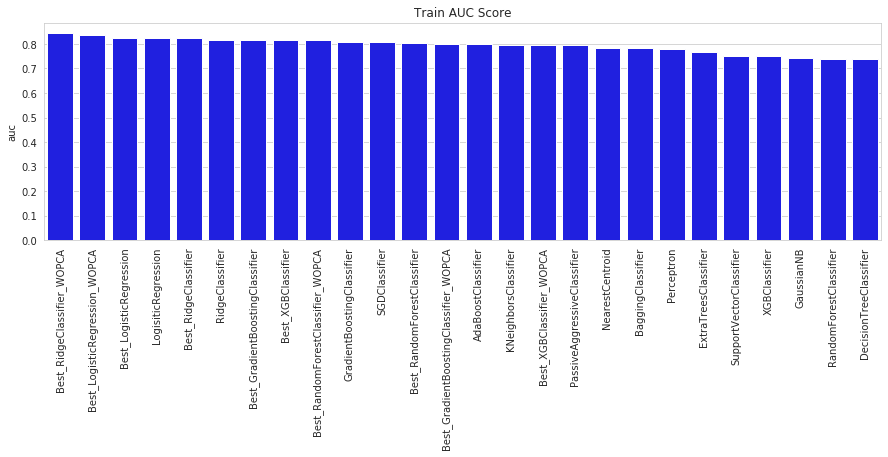

In [85]:
# uncomment the below line and all basic_eval line above to run code or use below markdown as reference
'''sns.set_style('whitegrid')
plt.figure(figsize=(15,4))
plt.title('Train Recall Score')
plfd = all_result.sort_values(by='recall',ascending=False)
ax = sns.barplot(x=plfd.index,y=plfd.recall,color='b')
plt.xticks(rotation=90)
plt.show()'''

"sns.set_style('whitegrid')\nplt.figure(figsize=(15,4))\nplt.title('Train Recall Score')\nplfd = all_result.sort_values(by='recall',ascending=False)\nax = sns.barplot(x=plfd.index,y=plfd.recall,color='b')\nplt.xticks(rotation=90)\nplt.show()"

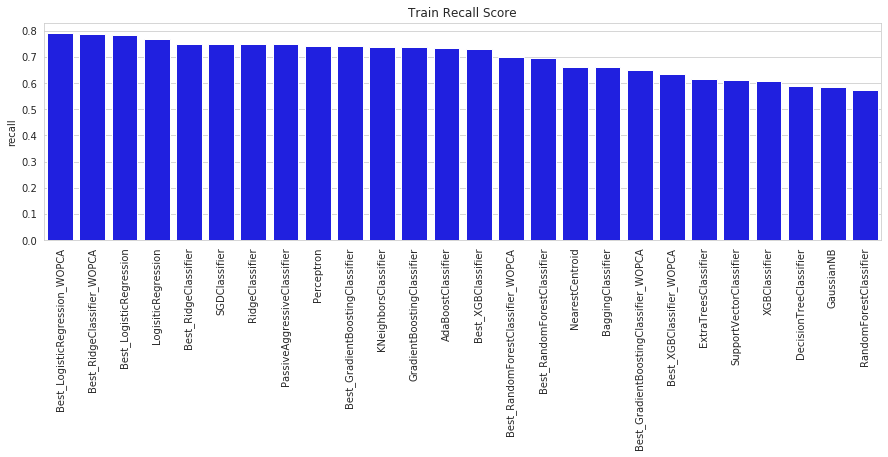

In [86]:
# uncomment the below line and all test_scores line above to run code or use below markdown as reference
'''sns.set_style('whitegrid')
plt.figure(figsize=(8,4))
plt.title('Test AUC Score')
plfd = all_result_test.sort_values(by='auc',ascending=False)
ax = sns.barplot(x=plfd.index,y=plfd.auc,color='b')
plt.xticks(rotation=90)
plt.show()'''

"sns.set_style('whitegrid')\nplt.figure(figsize=(8,4))\nplt.title('Test AUC Score')\nplfd = all_result_test.sort_values(by='auc',ascending=False)\nax = sns.barplot(x=plfd.index,y=plfd.auc,color='b')\nplt.xticks(rotation=90)\nplt.show()"

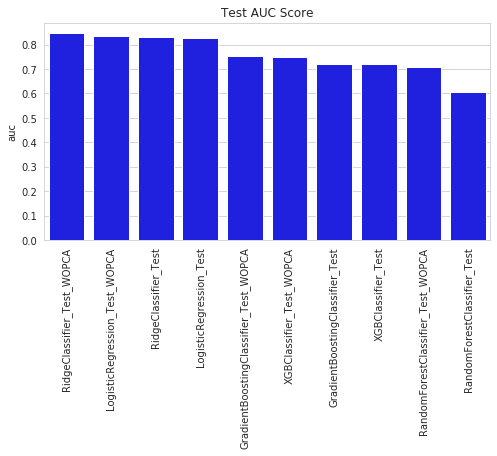

In [87]:
# uncomment the below line and all test_scores line above to run code or use below markdown as reference
'''sns.set_style('whitegrid')
plt.figure(figsize=(8,4))
plt.title('Test Recall Score')
plfd = all_result_test.sort_values(by='recall',ascending=False)
ax = sns.barplot(x=plfd.index,y=plfd.recall,color='b')
plt.xticks(rotation=90)
plt.show()'''

"sns.set_style('whitegrid')\nplt.figure(figsize=(8,4))\nplt.title('Test Recall Score')\nplfd = all_result_test.sort_values(by='recall',ascending=False)\nax = sns.barplot(x=plfd.index,y=plfd.recall,color='b')\nplt.xticks(rotation=90)\nplt.show()"

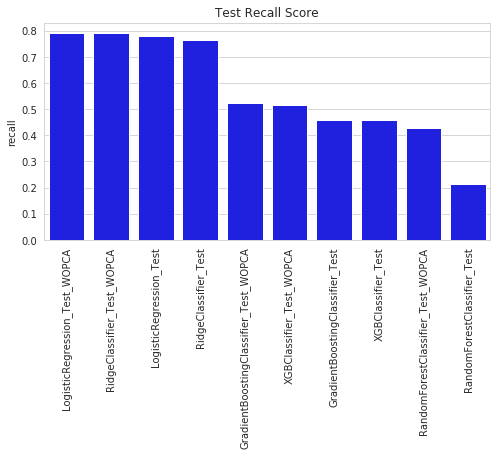

### Conclusion

1. Linear models (Logistic Regression and Ridge Classifier) proved to be best models in terms of auc and recall in case of train as well as test data hence will be used as final predictors.
2. Best score achieved was 0.85 auc and 0.80 recall with Logustic Regression without PCA.
3. Models performed better on data without PCA (mainly becasue there was no multicolinearity in the data).

## VI. Important Variables<a id='VI'></a>

To identify important variables we will use `Logistic Regression` from `statsmodels`. 

In [88]:
X_train,X_test, y_train, y_test = train_test_split(high_valued.drop('churn',axis=1), high_valued['churn'],
                                                train_size = 0.70,stratify=high_valued['churn'],random_state=100)

In [89]:
import statsmodels.api as sm

# Logistic regression model
X_train_sm = sm.add_constant(X_train)
logm1 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
logm1.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  churn   No. Observations:                20985
Model:                            GLM   Df Residuals:                    20833
Model Family:                Binomial   Df Model:                          151
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3383.0
Date:                Mon, 04 Nov 2019   Deviance:                       6766.0
Time:                        19:21:31   Pearson chi2:                 1.78e+04
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
const                                 -4.2302      0.782     -5.406      0.000      -5.764      -2.697
arpu_6                                -0.0017      0.079     -0.021      0.983      -0.156       0.153
arpu_7                                 0.2196      0.072      3.031      0.002       0.078       0.362
arpu_8                                -0.3213      0.075     -4.287      0.000      -0.468      -0.174
onnet_mou_6                            0.0592      0.051      1.165      0.244      -0.040       0.159
onnet_mou_7                            0.0547      0.053      1.038      0.299      -0.049       0.158
onnet_mou_8                            0.0026      0.039      0.066      0.947      -0.074       0.079
offnet_mou_6                           0.1415      0.058      2.459      0.014       0.029       0.254
offnet_mou_7                           0.1843      0.061      3.025      0.002       0.065       0.304
offnet_mou_8                          -0.0445      0.040     -1.100      0.271      -0.124       0.035
loc_og_t2t_mou_6                      -0.0267      0.039     -0.679      0.497      -0.104       0.050
loc_og_t2t_mou_7                       0.0563      0.040      1.400      0.161      -0.022       0.135
loc_og_t2t_mou_8                       0.0248      0.032      0.779      0.436      -0.038       0.087
loc_og_t2m_mou_6                      -0.0578      0.073     -0.792      0.428      -0.201       0.085
loc_og_t2m_mou_7                      -0.0952      0.074     -1.286      0.198      -0.240       0.050
loc_og_t2m_mou_8                       0.0574      0.062      0.922      0.357      -0.065       0.179
loc_og_mou_6                           0.0810      0.087      0.930      0.353      -0.090       0.252
loc_og_mou_7                          -0.1369      0.091     -1.497      0.134      -0.316       0.042
loc_og_mou_8                          -0.0210      0.076     -0.276      0.782      -0.170       0.128
std_og_t2t_mou_6                      -0.0010      0.027     -0.035      0.972      -0.054       0.052
std_og_t2t_mou_7                      -0.0529      0.028     -1.923      0.054      -0.107       0.001
std_og_t2t_mou_8                       0.0547      0.026      2.083      0.037       0.003       0.106
std_og_t2m_mou_6                      -0.0266      0.038     -0.706      0.480      -0.101       0.047
std_og_t2m_mou_7                       0.0299      0.038      0.789      0.430      -0.044       0.104
std_og_t2m_mou_8                      -0.0251      0.032     -0.791      0.429      -0.087       0.037
std_og_mou_6                           0.0519      0.049      1.050      0.294      -0.045       0.149
std_og_mou_7                           0.0131      0.050      0.263      0.793      -0.085      

Variables such as arpu_7, arpu_8, offnet_mou_7, std_og_mou_8, total_og_mou_8, loc_ic_mou_8, total_ic_mou_7, total_ic_mou_8, total_rech_num_8, last_day_rch_amt_8, aon, date_of_last_rech etc. shows good correlations with churn. This is expected from 7th and 8th month beacause this is action phase in which customer shows signs of churn.

### Feature Selection Using RFE

Most of the features do not contribute sugnificantly to prediction hence we'll use Recursive Feature Elimination from sklearn to use only top important variables.

In [90]:
LGR = LogisticRegression()

from sklearn.feature_selection import RFE
rfe = RFE(LGR, 40)
rfe = rfe.fit(X_train, y_train)

In [91]:
col = X_train.columns[rfe.support_]
col

Index(['arpu_7', 'arpu_8', 'total_ic_mou_8', 'total_rech_amt_7',
       'max_rech_amt_7', 'aon', 'date_of_last_rech_6_6/21/2014',
       'date_of_last_rech_6_6/22/2014', 'date_of_last_rech_6_other',
       'date_of_last_rech_6_nan', 'date_of_last_rech_7_7/24/2014',
       'date_of_last_rech_7_7/26/2014', 'date_of_last_rech_7_7/30/2014',
       'date_of_last_rech_7_7/31/2014', 'date_of_last_rech_7_nan',
       'date_of_last_rech_8_8/23/2014', 'date_of_last_rech_8_8/24/2014',
       'date_of_last_rech_8_8/25/2014', 'date_of_last_rech_8_8/27/2014',
       'date_of_last_rech_8_8/28/2014', 'date_of_last_rech_8_8/29/2014',
       'date_of_last_rech_8_8/30/2014', 'date_of_last_rech_8_8/31/2014',
       'date_of_last_rech_8_other', 'date_of_last_rech_8_nan',
       'date_of_last_rech_data_6_6/19/2014',
       'date_of_last_rech_data_6_6/25/2014',
       'date_of_last_rech_data_6_6/30/2014',
       'date_of_last_rech_data_7_7/18/2014',
       'date_of_last_rech_data_7_7/21/2014',
       'date_o

Decline in Average Revenue per User from June and July, Total incoming minutes of usage, Total recharge amount in July, Maximum recharge amount in July and Age on Network might be strong indicator of churn.<br><br>
Also date columns representing last 10 days of the month are important beacause people recharging at the end of the month might be planning to use it in next month whereas users planning to churn will reduce their usage and recharge.

In [92]:
# lets re run the model and reduce features further by evaluating them individually
X_train_sm = sm.add_constant(X_train[col])
logm2 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
logm2.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  churn   No. Observations:                20985
Model:                            GLM   Df Residuals:                    20944
Model Family:                Binomial   Df Model:                           40
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3623.9
Date:                Mon, 04 Nov 2019   Deviance:                       7247.8
Time:                        19:22:37   Pearson chi2:                 1.99e+04
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
const                                 -3.1994      0.114    -28.056      0.000      -3.423      -2.976
arpu_7                                 0.2430      0.057      4.228      0.000       0.130       0.356
arpu_8                                -0.4330      0.044     -9.893      0.000      -0.519      -0.347
total_ic_mou_8                        -0.6020      0.017    -34.951      0.000      -0.636      -0.568
total_rech_amt_7                       0.3000      0.060      4.981      0.000       0.182       0.418
max_rech_amt_7                        -0.2977      0.041     -7.288      0.000      -0.378      -0.218
aon                                   -0.2329      0.034     -6.802      0.000      -0.300      -0.166
date_of_last_rech_6_6/21/2014         -0.5052      0.246     -2.051      0.040      -0.988      -0.022
date_of_last_rech_6_6/22/2014         -0.2613      0.266     -0.983      0.325      -0.782       0.259
date_of_last_rech_6_other             -0.2959      0.140     -2.117      0.034      -0.570      -0.022
date_of_last_rech_6_nan                1.4263      0.400      3.570      0.000       0.643       2.209
date_of_last_rech_7_7/24/2014         -0.3700      0.230     -1.606      0.108      -0.822       0.082
date_of_last_rech_7_7/26/2014         -0.2838      0.153     -1.860      0.063      -0.583       0.015
date_of_last_rech_7_7/30/2014          0.3349      0.091      3.689      0.000       0.157       0.513
date_of_last_rech_7_7/31/2014          0.3751      0.086      4.385      0.000       0.207       0.543
date_of_last_rech_7_nan                0.6981      0.361      1.932      0.053      -0.010       1.406
date_of_last_rech_8_8/23/2014         -0.5897      0.257     -2.295      0.022      -1.093      -0.086
date_of_last_rech_8_8/24/2014         -0.3637      0.149     -2.444      0.015      -0.655      -0.072
date_of_last_rech_8_8/25/2014         -0.2633      0.117     -2.252      0.024      -0.492      -0.034
date_of_last_rech_8_8/27/2014         -0.9526      0.179     -5.315      0.000      -1.304      -0.601
date_of_last_rech_8_8/28/2014         -0.5587      0.119     -4.685      0.000      -0.792      -0.325
date_of_last_rech_8_8/29/2014         -0.6433      0.118     -5.436      0.000      -0.875      -0.411
date_of_last_rech_8_8/30/2014         -1.6430      0.146    -11.268      0.000      -1.929      -1.357
date_of_last_rech_8_8/31/2014         -2.1712      0.151    -14.372      0.000      -2.467      -1.875
date_of_last_rech_8_other              0.2260      0.111      2.031      0.042       0.008       0.444
date_of_last_rech_8_nan                0.5655      0.165      3.418      0.001       0.241       0.890
date_of_last_rech_data_6_6/19/2014     0.8147      0.268      3.043      0.002       0.290      

***Recursively eliminate features with p value greater than 0.05***

To save time variables have been identified recursively but will be dropped togather.

In [93]:
p_col = ['date_of_last_rech_data_8_8/24/2014','date_of_last_rech_data_6_6/30/2014','date_of_last_rech_6_6/22/2014',
         'date_of_last_rech_data_8_8/27/2014','date_of_last_rech_data_7_7/27/2014','date_of_last_rech_data_7_7/18/2014',
         'date_of_last_rech_7_7/24/2014','date_of_last_rech_data_7_7/21/2014','date_of_last_rech_7_7/26/2014',
         'date_of_last_rech_data_6_6/25/2014','date_of_last_rech_data_8_8/29/2014']
X_train_sm = X_train_sm.drop(p_col,axis=1)

In [94]:
logm2 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
logm2 = logm2.fit()
logm2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  churn   No. Observations:                20985
Model:                            GLM   Df Residuals:                    20955
Model Family:                Binomial   Df Model:                           29
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3636.0
Date:                Mon, 04 Nov 2019   Deviance:                       7271.9
Time:                        19:22:37   Pearson chi2:                 1.98e+04
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
const                                 -3.3107      0.109    -30.451      0.000      -3.524      -3.098
arpu_7                                 0.2432      0.057      4.243      0.000       0.131       0.356
arpu_8                                -0.4265      0.044     -9.782      0.000      -0.512      -0.341
total_ic_mou_8                        -0.6014      0.017    -35.006      0.000      -0.635      -0.568
total_rech_amt_7                       0.2960      0.060      4.929      0.000       0.178       0.414
max_rech_amt_7                        -0.2980      0.041     -7.323      0.000      -0.378      -0.218
aon                                   -0.2368      0.034     -6.927      0.000      -0.304      -0.170
date_of_last_rech_6_6/21/2014         -0.4982      0.247     -2.015      0.044      -0.983      -0.014
date_of_last_rech_6_other             -0.2955      0.139     -2.124      0.034      -0.568      -0.023
date_of_last_rech_6_nan                1.4404      0.399      3.612      0.000       0.659       2.222
date_of_last_rech_7_7/30/2014          0.3771      0.089      4.227      0.000       0.202       0.552
date_of_last_rech_7_7/31/2014          0.4195      0.084      5.000      0.000       0.255       0.584
date_of_last_rech_7_nan                0.7283      0.361      2.019      0.043       0.021       1.435
date_of_last_rech_8_8/23/2014         -0.5840      0.256     -2.279      0.023      -1.086      -0.082
date_of_last_rech_8_8/24/2014         -0.3850      0.148     -2.604      0.009      -0.675      -0.095
date_of_last_rech_8_8/25/2014         -0.2518      0.117     -2.159      0.031      -0.480      -0.023
date_of_last_rech_8_8/27/2014         -0.9974      0.176     -5.669      0.000      -1.342      -0.653
date_of_last_rech_8_8/28/2014         -0.5654      0.119     -4.748      0.000      -0.799      -0.332
date_of_last_rech_8_8/29/2014         -0.6938      0.116     -5.957      0.000      -0.922      -0.466
date_of_last_rech_8_8/30/2014         -1.6475      0.146    -11.322      0.000      -1.933      -1.362
date_of_last_rech_8_8/31/2014         -2.1781      0.151    -14.431      0.000      -2.474      -1.882
date_of_last_rech_8_other              0.2359      0.111      2.121      0.034       0.018       0.454
date_of_last_rech_8_nan                0.5615      0.165      3.411      0.001       0.239       0.884
date_of_last_rech_data_6_6/19/2014     0.7750      0.267      2.901      0.004       0.251       1.299
date_of_last_rech_data_7_7/23/2014    -1.2185      0.497     -2.452      0.014      -2.193      -0.244
date_of_last_rech_data_7_7/24/2014    -1.0213      0.432     -2.367      0.018      -1.867      -0.176
date_of_last_rech_data_7_7/25/2014     0.5434      0.244      2.225      0.026       0.065      

Now since all variables have p value < 0.05, they are all relevant.

***Checking Variance Inflation Factor (VIF)***

In [95]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
X_train_sm = X_train_sm.drop('const',axis=1)
vif['Features'] = X_train_sm.columns
vif['VIF'] = [variance_inflation_factor(X_train_sm.values, i) for i in range(X_train_sm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

Features   VIF
3                     total_rech_amt_7  5.70
0                               arpu_7  4.01
28        date_of_last_rech_data_8_nan  2.57
4                       max_rech_amt_7  2.30
1                               arpu_8  2.18
19       date_of_last_rech_8_8/31/2014  1.94
10       date_of_last_rech_7_7/31/2014  1.65
2                       total_ic_mou_8  1.46
18       date_of_last_rech_8_8/30/2014  1.41
9        date_of_last_rech_7_7/30/2014  1.35
16       date_of_last_rech_8_8/28/2014  1.33
17       date_of_last_rech_8_8/29/2014  1.27
27  date_of_last_rech_data_8_8/31/2014  1.25
20           date_of_last_rech_8_other  1.23
21             date_of_last_rech_8_nan  1.22
11             date_of_last_rech_7_nan  1.22
14       date_of_last_rech_8_8/25/2014  1.18
15       date_of_last_rech_8_8/27/2014  1.14
7            date_of_last_rech_6_other  1.11
26  date_of_last_rech_data_8_8/28/2014  1.10
13       date_of_last_rech_8_8/24/2014  1.10
5                                  aon  1.09
12       date_of_last_rech_8_8/23/2014  1.04
6        date_of_last_rech_6_6/21/2014  1.03
22  date_of_last_rech_data_6_6/19/2014  1.02
23  date_of_last_rech_data_7_7/23/2014  1.02
24  date_of_last_rech_data_7_7/24/2014  1.02
25  date_of_last_rech_data_7_7/25/2014  1.02
8              date_of_last_rech_6_nan  1.01

VIF of each variable seems to be in check hence there is minimum presence of multicolinearity.

### Feature Importance using Random Forest Classifier

Lets also consider feature importance given by a tree based algorithm such as `Random Forest Classifier`

In [96]:
# We will use RFC that already has its hyper parameter tuned
best_RFC = best_RFC.fit(X_train,y_train)

In [97]:
features = X_train.columns
importances = best_RFC.feature_importances_
imp_feat = pd.DataFrame({'feature': features,'importance':importances})
imp_feat = imp_feat.sort_values(by='importance',ascending=False).head(15)

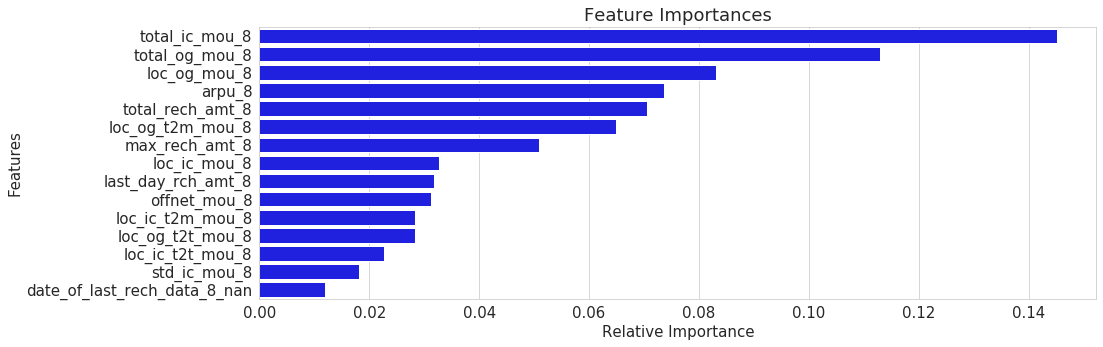

In [98]:
import matplotlib
plt.figure(figsize=(15, 5))
matplotlib.rcParams.update({'font.size': 15})
plt.title('Feature Importances')
ax = sns.barplot(x="importance", y="feature", data=imp_feat, color='b')
plt.xlabel('Relative Importance')
plt.ylabel('Features')
plt.show()

### Conclusion

<h4 style="text-align:center;">The top 15 features ordered according to their importance according to Logistic Regression model and Random Forest model</h4>

<table align="center">
<thead>
<tr><th>Logistic regression          </th><th>Random Forest regression    </th></tr>
</thead>
<tbody>
<tr><td>arpu_7                       </td><td>total_ic_mou_8              </td></tr>
<tr><td>arpu_8                       </td><td>total_og_mou_8              </td></tr>
<tr><td>total_ic_mou_8               </td><td>loc_og_mou_8                </td></tr>
<tr><td>total_rech_amt_7             </td><td>arpu_8                      </td></tr>
<tr><td>max_rech_amt_7               </td><td>total_rech_amt_8            </td></tr>
<tr><td>aon                          </td><td>loc_og_t2m_mou_8            </td></tr>
<tr><td>date_of_last_rech_6_6/21/2014</td><td>max_rech_amt_8              </td></tr>
<tr><td>date_of_last_rech_6_other    </td><td>loc_ic_mou_8                </td></tr>
<tr><td>date_of_last_rech_6_nan      </td><td>last_day_rch_amt_8          </td></tr>
<tr><td>date_of_last_rech_7_7/30/2014</td><td>offnet_mou_8                </td></tr>
<tr><td>date_of_last_rech_7_7/31/2014</td><td>loc_ic_t2m_mou_8            </td></tr>
<tr><td>date_of_last_rech_7_nan      </td><td>loc_og_t2t_mou_8            </td></tr>
<tr><td>date_of_last_rech_8_8/23/2014</td><td>loc_ic_t2t_mou_8            </td></tr>
<tr><td>date_of_last_rech_8_8/24/2014</td><td>std_ic_mou_8                </td></tr>
<tr><td>date_of_last_rech_8_8/25/2014</td><td>date_of_last_rech_data_8_nan</td></tr>
</tbody>
</table>

1. All the important features are data about the month of July and August which are stated as `action phase`. In these months the behaviour of customer starts changing and we can determine weather customer will churn or not.
2. Average revenue per user (arpu) of both July and August plays an important role as it starts declining when user decides to churn (change operator).
3. Total incoming and outgoing calls minutes of usage starts declining as customer decides to churn in July and August.
4. Maximum and total recharge amounts for talktime as well as data also starts declining as customer decides to churn in July and August. As customer spend less and less in its action phase.
5. Decline in all types of incoming minutes of usage may indicate customer has already started switiching to another operator.
6. Age on Network (AON) matters as the older the customer, the more loyal it is expected to be. This is because it might be using it for day to day needs since a long time and switching could disrupt all activities.
7. Last dates of recharge for June, July and August being nan (missing) may indicate that customer have stopped subscribing to monthly services and packs which indicates churn in future.
8. Recharge on other end of the month dates indicate that customer will continue using services in next month too. 